In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import njit, jit, prange, set_num_threads, get_num_threads
import scipy as sp
import time
import sys
import os
from EPRsimfcts import *
from qutip import Bloch
set_num_threads(20)
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
# Add both the Code directory and its parent to Python path


for path in [current_dir, parent_dir]:
    if path not in sys.path:
        sys.path.insert(0, path)  # Insert at beginning of path
# Optional: Visualize the points

## Determine the Rabi frequency

In [2]:
# Define Pauli matrices and identity
sx = np.array([[0, 1], [1, 0]], dtype=complex)
sy = np.array([[0, -1j], [1j, 0]], dtype=complex)
sz = np.array([[1, 0], [0, -1]], dtype=complex)
I2 = np.eye(2, dtype=complex)
@njit
def expm_hamiltonian(H, t):
    """
    Compute the time evolution operator U(t) = exp(-i H t) for a 2x2 Hermitian matrix H,
    using its decomposition into the identity and Pauli matrices.
    
    Parameters:
      H : 2x2 numpy array (Hermitian)
      t : time at which to evaluate U(t)
    
    Returns:
      U : 2x2 numpy array representing the time evolution operator at time t
    """
    # Decompose H = a0 * I + a_vec · sigma.
    # a0 is half the trace of H:
    a0 = 0.5 * np.trace(H)
    
    # Extract the coefficients for the Pauli matrices:
    # a_x = 0.5 * Re(H[0,1] + H[1,0])
    ax = 0.5 * (H[0, 1] + H[1, 0]).real
    # a_y = -0.5 * Im(H[0,1] - H[1,0])
    ay = -0.5 * (H[0, 1] - H[1, 0]).imag
    # a_z = 0.5 * (H[0,0] - H[1,1])
    az = 0.5 * (H[0, 0] - H[1, 1]).real
    a_vec = np.array([ax, ay, az])
    
    # Compute the norm of the vector part
    a_norm = np.linalg.norm(a_vec)
    
    # Overall phase factor from the trace part
    phase = np.exp(-1j * a0 * t)
    
    # If a_norm is nonzero, construct n_dot_sigma, otherwise just return phase*I.
    if a_norm > 1e-12:
        # Build the operator n·sigma using the Pauli matrices.
        n_dot_sigma = (ax * sx + ay * sy + az * sz) / a_norm
        U = phase * ( np.cos(a_norm * t) * I2 - 1j * np.sin(a_norm * t) * n_dot_sigma )
    else:
        U = phase * I2
        
    return U


In [4]:
N_mol = 20001
#chi_01 = np.linspace(0, 2 * np.pi, N_mesh) 
phi_01=np.random.uniform(0, 2*np.pi, N_mol)
chi_01 = np.random.uniform(0, 2 * np.pi, N_mol)
cos_theta_01 = np.random.uniform(-1, 1, N_mol)   # Cosine of polar angle
#cos_theta_01 = np.linspace(-1, 1, N_mesh)
theta_01 = np.arccos(cos_theta_01) 
theta_12 = 0 # Polar angle theta_12 is usually a fixed value for dumbbell model
phi_12 = 0 # Set phi_12=0 for simplicity; but occasionally it is not)

V = 52.16/1000 # Hss coefficient, unit: 2pi*GHz*nm^3
d=2 # distance, unit: nm

#H0 and eigenvectors
D0 = 2.348 #GHz
E0 = 0.458 #GHz
B0 = 0.03 # T
Omega1=50*np.pi*2
gamma=28.02495142
Delta1 = np.zeros([N_mol])*(0+0j)
Delta2 = np.zeros([N_mol])*(0+0j)
Delta3 = np.zeros([N_mol])*(0+0j)
Rabi_freq_xz=np.zeros([N_mol])*(0+0j)
Rabi_freq_yz=np.zeros([N_mol])*(0+0j)
Txz = np.zeros([N_mol])
Tyz = np.zeros([N_mol])
Txy = np.zeros([N_mol])
for i in range(N_mol):
    H_0 = H0(D0, E0, B0, phi_01[i], theta_01[i], chi_01[i])
    E_0, M0=np.linalg.eigh(H_0)
    Txz[i]=E_0[2]-E_0[0]
    Tyz[i]=E_0[1]-E_0[0]
    Txy[i]=E_0[2]-E_0[1]
        
    eigvec=M0.T
    Rabi_freq_xz[i]=Omega1* Rabi_frequency_v2(eigvec[2], eigvec[0], phi_01[i], theta_01[i], chi_01[i])
    Rabi_freq_yz[i]=Omega1* Rabi_frequency_v2(eigvec[1], eigvec[0], phi_01[i], theta_01[i], chi_01[i])
    #Rabi_freq[i]=Rabi_freq_Ave_over_phi_vs_orientation(B0, Omega1/28024.9514242, theta_01[i], chi_01[i])
        #print(E_0, M0)
        #Delta = [0, 0, 0]
    for q in [-1, 0, 1]:
        #for q in [0]:
        if q==-1:
            TS = T1mS(1)
        elif q==0:
            TS = T10S(1)
        elif q==1:
            TS = T1pS(1)
            #print (eigvec[0].conj())
        coef = C_q(q, theta_01[i], chi_01[i], theta_12, phi_12)
        Mat_prod1=np.matmul(eigvec[0].conj(), np.matmul(TS, eigvec[0]))
        Mat_prod2=np.matmul(eigvec[1].conj(), np.matmul(TS, eigvec[1]))
        Mat_prod3=np.matmul(eigvec[2].conj(), np.matmul(TS, eigvec[2]))
        #print(f"{theta_01[i]:.2f}", q, f"{coef:.4f}", f"{Mat_prod1:.4f}", f"{Mat_prod2:.4f}", f"{Mat_prod3:.4f}",)
        Delta1[i]=Delta1[i]+coef*Mat_prod1
        Delta2[i]=Delta2[i]+coef*Mat_prod2
        Delta3[i]=Delta3[i]+coef*Mat_prod3
    if np.abs(Delta1[i])<1e-10:
        Delta1[i]=0
    if np.abs(Delta2[i])<1e-10:
        Delta2[i]=0
    if np.abs(Delta3[i])<1e-10:
        Delta3[i]=0
        #print(f"{V/d**3*Delta1[i,j].real:.4f}", f"{V/d**3*Delta2[i, j].real:.4f}", f"{V/d**3*Delta3[i, j].real:.4f}")
deltaxz=Txz-np.mean(Txz)
deltayz=Tyz-np.mean(Tyz)
deltaxy=Txy-np.mean(Txy)   
Delta1= V/d**3*Delta1*2*np.pi
Delta2= V/d**3*Delta2*2*np.pi
Delta3= V/d**3*Delta3*2*np.pi
Omega_ave=np.mean(np.abs(Rabi_freq))
time_seq=np.linspace(0, 0.1, 200)
v0=np.array([1,0])*(1+0j)
sig=np.zeros([len(time_seq)])*(1+0j)
sz=np.array([[1, 0],[0, -1]])*(1+0j)
scale_factor=1 #Varying the mw poer

for n_i in range(N_mol):
    H_mol=Eff_H(Rabi_freq_xz[n_i]*scale_factor, deltaxz[n_i]*np.pi*2*1000) #Use this code to compute the pi pulse for the Tz-Tx transition
    #H_mol=Eff_H(Rabi_freq_yz[n_i]*scale_factor, deltayz[n_i]) #Use this code to compute the pi pulse for the Tz-Ty transition
    U_0=expm_hamiltonian(H_mol, time_seq[1])
    for t_i in range(len(time_seq)):
        #U_mol=sp.linalg.expm(-1j*H_mol*time_seq[t_i])
        #U_mol=np.linalg.matrix_power(U_0, t_i)
        U_mol=expm_hamiltonian(H_mol, time_seq[t_i])
        v_i=U_mol@v0
        #print(U_mol.trace())
        sig[t_i]+=v_i.conj()@(sz@v_i)
        
plt.plot(time_seq, np.real(sig)/N_mol)
plt.xlabel('t (ns)')
plt.ylabel('Signal')

NameError: name 'Rabi_freq' is not defined

Text(0, 0.5, 'Signal')

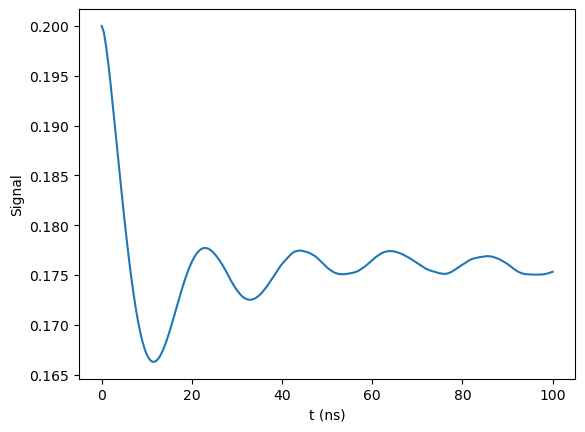

In [162]:
time_seq=np.linspace(0, 0.1, 200)
v0=np.array([1,0])*(1+0j)
rho0=np.array([[0.4, 0],[0, 0.2]])*(1+0j)
sig=np.zeros([len(time_seq)])*(1+0j)
sz=np.array([[1, 0],[0, -1]])*(1+0j)
scale_factor=1 #Varying the mw poer

for n_i in range(len(Rabi_freq_yz)):
    #H_mol=Eff_H(Rabi_freq_xz[n_i]*scale_factor, deltaxz[n_i])
    H_mol=Eff_H(Rabi_freq_yz[n_i]*scale_factor, deltayz[n_i]+(np.mean(Tyz)-2.13)*np.pi*2*1000)
    #H_mol=Eff_H(Rabi_freq_xz[n_i]*scale_factor, deltaxz[n_i]*np.pi*2*1000)
    #H_mol=Eff_H(Rabi_freq_yz[n_i]*scale_factor, deltayz[n_i]*np.pi*2*1000)
    U_0=expm_hamiltonian(H_mol, time_seq[1])
    for t_i in range(len(time_seq)):
        #U_mol=sp.linalg.expm(-1j*H_mol*time_seq[t_i])
        #U_mol=np.linalg.matrix_power(U_0, t_i)
        U_mol=expm_hamiltonian(H_mol, time_seq[t_i])
        #v_i=U_mol@v0
        rhot=U_mol@rho0@U_mol.conj().T
        #print(U_mol.trace())
        #sig[t_i]+=v_i.conj()@(sz@v_i)
        sig[t_i]+=np.trace(rhot@sz)
plt.plot(time_seq*1000, np.real(sig)/len(Rabi_freq_yz))
plt.xlabel('t (ns)')
plt.ylabel('Signal')

In [161]:
len(Rabi_freq_yz)

299940

In [187]:
time_seq[np.argmin(np.real(sig))]

np.float64(0.010552763819095479)

## Simulation for DEER signal

In [ ]:
#Operators definition
#@njit
#@jit(forceobj=True)
def matrix_exponential_diag(A):
    """
    Compute the matrix exponential e^A using the diagonalization method.
    
    This function assumes that the square matrix A is diagonalizable.
    
    Parameters:
        A (np.ndarray): A square matrix (n x n).
        
    Returns:
        expA (np.ndarray): The matrix exponential e^A.
    """
    # Compute eigenvalues and eigenvectors of A.
    eigenvalues, eigenvectors = np.linalg.eig(A)
    
    # Compute the diagonal matrix of the exponentials of the eigenvalues.
    exp_lambda = np.diag(np.exp(eigenvalues))
    
    # Compute the matrix exponential using the formula e^A = V exp(Λ) V^{-1}
    expA = eigenvectors @ exp_lambda @ np.linalg.inv(eigenvectors)
    #expA = eigenvectors @ exp_lambda @ eigenvectors.conj().T
    return expA



@njit
def matrix_exponential_diag_numba(A):
    # Compute eigenvalues and eigenvectors of A.
    eigenvalues, eigenvectors = np.linalg.eig(A)
    
    # Compute the diagonal matrix of the exponentials of the eigenvalues.
    exp_lambda = np.diag(np.exp(eigenvalues))
    
    # Compute the matrix exponential using the formula e^A = V exp(Λ) V^{-1}
    expA = matmul_numba(eigenvectors, matmul_numba(exp_lambda, np.linalg.inv(eigenvectors)))
    #expA = eigenvectors @ exp_lambda @ eigenvectors.conj().T
    return expA    
#Define all the time-evolution operators; 
#functions labelled with t are using analytical formula for the exponential of matrix
@njit
def U_0t(delta1, Dss, t):
    theta=delta1*t/2
    gamma=Dss*t/4
    return np.array([[np.exp(-1j*theta-1j*gamma), 0, 0, 0],
                     [0, np.exp(1j*theta+1j*gamma), 0, 0],
                     [0, 0, np.exp(-1j*theta+1j*gamma), 0],
                     [0, 0, 0, np.exp(1j*theta-1j*gamma)]])

@njit
def U_1t(Omega1, delta1, Dss, t): #time-evolution operator for EYFP MW transition is being addressed
    #Already checked with diagonalization method, this function is correct
    delta_p = delta1+Dss/2
    delta_m = delta1-Dss/2
    Omega_p=np.sqrt(Omega1**2+delta_p**2)
    Omega_m=np.sqrt(Omega1**2+delta_m**2)
    theta_p=Omega_p*t/2
    theta_m=Omega_m*t/2
    M11 = np.cos(theta_p) - 1j*delta_p/Omega_p*np.sin(theta_p)
    M12 = -1j*Omega1*np.sin(theta_p)/Omega_p
    M22 = np.cos(theta_p)+1j*delta_p/Omega_p*np.sin(theta_p)
    M33 = np.cos(theta_m)-1j*delta_m/Omega_m*np.sin(theta_m)
    M34 = -1j*Omega1*np.sin(theta_m)/Omega_m
    M44 = np.cos(theta_m)+1j*delta_m/Omega_m*np.sin(theta_m)
    U = np.array([[M11, M12, 0, 0],
                  [M12, M22, 0, 0],
                  [0, 0, M33, M34],
                  [0, 0, M34, M44]])
    #np.cos(Omega_p*t/2)*I-1j*(delta_p*sigmaz+Omega*sigmax)/Omega_p*np.sin(Omega_p*t/2)
    #U_m = np.cos(Omega_m*t/2)*I-1j*(delta_m*sigmaz+Omega*sigmax)/Omega_m*np.sin(Omega_m*t/2)
    return U

@njit
def U_1(Omega1: complex, delta1:float, Dss:complex, t:float): #time-evolution operator for target spin MW transition is being addressed
    #DO NOT USE scipy, the scipy function sucks
    H0=np.array([[(delta1+Dss/2)/2, Omega1/2, 0,  0],
                 [np.conj(Omega1)/2, (-delta1-Dss/2)/2, 0, 0],
                 [0, 0, (delta1-Dss/2)/2,  Omega1/2],
                 [0, 0, np.conj(Omega1)/2, (-delta1+Dss/2)/2]])
    #print(np.linalg.eigh(H0))
    #print(H0)
    #U=sp.linalg.expm(-1j*H0*t)
    U=matrix_exponential_diag_numba(-1j*H0*t)
    return U

@njit
def U_2_pi_pulse(Omega2, delta1, Dss): #time-evolution operator for pi pulse on target spin is being addressed
    Omega_p=np.sqrt(Omega2**2+Dss**2/4)
    C1=1j*Dss/(2*Omega_p)
    C2=1j*Omega2/Omega_p
    C3=np.exp(1j*delta1*np.pi/(2*Omega_p))
    C4=np.exp(-1j*delta1*np.pi/(2*Omega_p))
    U=np.array([[-C1*C4, 0, -C2*C4, 0],[0, C1*C3, 0, -C2*C3],[-C2*C4, 0, C1*C4, 0],[0, -C2*C3, 0, -C1*C3]])
    return U

@njit
def U_2(Omega2:float, delta1: complex, Dss: complex, t:float): #time-evolution operator for target spin MW transition is being addressed
    #This function using the custom matrix exponential method
    H0=np.array([[(delta1+Dss/2)/2, 0, Omega2/2, 0],
                 [0, (-delta1-Dss/2)/2, 0, Omega2/2],
                 [Omega2/2, 0, (delta1-Dss/2)/2, 0],
                 [0, Omega2/2, 0, (-delta1+Dss/2)/2]])
    #print(np.linalg.eigh(H0))

    #U=sp.linalg.expm(-1j*H0*t)
    U=matrix_exponential_diag_numba(-1j*H0*t)
    return U

@njit
def U_3(Omega1: complex, Omega2:float, delta1: complex, Dss: complex, t:float): #time-evolution operator for both transitions are being addressed
    H0=np.array([[(delta1+Dss/2)/2, Omega1/2, Omega2/2, 0],
                 [np.conj(Omega1)/2, (-delta1-Dss/2)/2, 0, Omega2/2],
                 [Omega2/2, 0, (delta1-Dss/2)/2, Omega1/2],
                 [0, Omega2/2, np.conj(Omega1)/2, (-delta1+Dss/2)/2]])
    #print(np.linalg.eigh(H0))
    #U=sp.linalg.expm(-1j*H0*t)
    U=matrix_exponential_diag_numba(-1j*H0*t)
    return U




In [2]:
    
N_mol = 20001 #Total molecule number
#phi_01, theta_01, chi_01=Generate_molecule_set(N_mol)
#phi_01, theta_01, chi_01=Generate_molecule_set_equidistributed(10000, 30)
phi_01, theta_01, chi_01=Generate_molecule_set_Fibonacci_sphere(10000, 30)


theta_12 = 0.0 # Polar angle theta_12 is usually a fixed value for dumbbell model
phi_12 = 0.0 # Set phi_12=0 for simplicity; but generally it is not)

V = 52.16/1000 # Hss coefficient, unit: 2pi*GHz*nm^3
d=2.0 # distance, unit: nm
D0 = 2.356 #GHz
E0 = 0.458 #GHz
#D0 = 0.0 #GHz
#E0 = 0.0 #GHz
B0 = 0.03 # T
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note
t_pi=0.011055 #pi pulse duration, unit: us, the value is defined from the Rabi oscillation part of this jupyter notebook

Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation_numba(B0, D0, E0, d, Omega1, phi_01, theta_01, chi_01, theta_12, phi_12)
#Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation(B0, 0.0, 0.0, d, Omega1, t_pi, phi_01, theta_01, chi_01, theta_12, phi_12)

### 4-pulse DEER on $T_z$ to $T_x$ transition

In [375]:
#Defining time sequences


@njit(parallel=True)
def DEER_4_pulse_numba(Rabi_freq: complex, t_pi: float, Omega1: float, delta: float, Dss:complex, tau1: float, tau2: float, N_tau:int, n_g:float, n_e:float): #n_g, n_e: population on ground/excited states
    #Numba version of the 4-pulse DEER simulation
    tau_total=tau1+tau2
    tau=np.linspace(0, tau_total, N_tau)
    N_mol=len(Rabi_freq)
    sig_p_all = np.zeros((N_mol, N_tau))
    sig_m_all = np.zeros((N_mol, N_tau))
    #sig_c_all = np.zeros((N_mol, N_tau))
    #print('definition-0')
    sig_p=np.zeros_like(tau) #coupling to spin up
    sig_m=np.zeros_like(tau) #coupling to spin down
    sig_c=np.zeros_like(tau) #no coupling, for comparison only
    #rho_0p = np.zeros((4, 4), dtype=np.complex128)
    #rho_0m = np.zeros((4, 4), dtype=np.complex128)
    Dssi=0.0+0.0j
    

    O_s = np.array([[1/2,0, 0, 0], [0,-1/2, 0, 0],[0,0, 1/2, 0],[0,0, 0, -1/2]]) #Observation operator for EYFP spin
    #print('definition-1')
    for i in prange(N_mol):
        rho_0p = np.zeros((4, 4), dtype=np.complex128)
        rho_0m = np.zeros((4, 4), dtype=np.complex128)
        rho_0p[0, 0] = n_g[i]
        rho_0p[1, 1] = n_e[i]
        rho_0p[2, 2] = 0.0
        rho_0p[3, 3] = 0.0

        rho_0m[0, 0] = 0.0
        rho_0m[1, 1] = 0.0
        rho_0m[2, 2] = n_g[i]
        rho_0m[3, 3] = n_e[i]
        delta_1 = delta[i]
        Dssi = Dss[i]
        for j in range(N_tau):
        
            #print('Start of the (', i, ', ', j, ')th for-loops')
            
            #delta_1 = delta[i] #detuning delta_1 for eYFP MW pumping, unit: MHz
            #Dssi = Dss[i] #Unit: MHz
            #print('Definition of rhos in the (', i, ', ', j, ')th for-loops')
            #Pulse sequence
            U1=U_1t(np.abs(Rabi_freq[i]), delta_1, Dssi, t_pi/2) #pi/2 pulse on EYFP
            U_fe_1= U_0t(delta_1, Dssi, tau1) #'fe' means free evolution
            U2=matmul_numba(U1,U1) # pi pulse on EYFP
            U_fe_2= U_0t(delta_1, Dssi, tau[j])
            U3=U_2_pi_pulse(Omega1, delta_1, Dssi) #the third pi pulse, applied to the target spin
            U_fe_3= U_0t(delta_1, Dssi, tau_total-tau[j])
            U_fe_4= U_0t(delta_1, Dssi, tau2)
            U_DEER_4=matmul_numba(U1, matmul_numba(U_fe_4, matmul_numba(U2, matmul_numba(U_fe_3, matmul_numba(U3, matmul_numba(U_fe_2, matmul_numba(U2,matmul_numba(U_fe_1,U1)))))))) #4-pulse DEER sequence
            #print('Definition of Us in the (', i, ', ', j, ')th for-loops')        
            #U10=U_1t(Rabi_freq[i], delta_1, 0, t_pi/2)
            #U_fe_10= U_0t(delta_1, 0, tau1)
            #U20=matmul_numba(U10,U10) # pi pulse on EYFP
            #U_fe_20= U_0t(delta_1, 0, tau[j])
            #U30=U_2_pi_pulse(Omega1, delta_1, 0) #the third pi pulse, applied to the target spin
            #U_fe_30= U_0t(delta_1, 0, tau_total-tau[j])
            #U_fe_40= U_0t(delta_1, 0, tau2)
            #U_SE = matmul_numba(U10, matmul_numba(U_fe_40, matmul_numba(U20, matmul_numba(U_fe_30, matmul_numba(U30, matmul_numba(U_fe_20, matmul_numba(U20, matmul_numba(U_fe_10,U10))))))))
            #print(U_SE)
            
            #rho_tp =matmul_numba(U_DEER_4, matmul_numba(rho_0p, np.conj(U_DEER_4).T))
            #rho_tm =matmul_numba(U_DEER_4, matmul_numba(rho_0m, np.conj(U_DEER_4).T))
            #rho_t0 =matmul_numba(U_SE, matmul_numba(rho_0p, np.conj(U_SE).T))
            #sig_p[j]+=np.trace(matmul_numba(rho_tp, O_s)).real
            #sig_m[j]+=np.trace(matmul_numba(rho_tm, O_s)).real
            rho_tp = matmul_numba(U_DEER_4, matmul_numba(rho_0p, np.conj(U_DEER_4).T))
            rho_tm = matmul_numba(U_DEER_4, matmul_numba(rho_0m, np.conj(U_DEER_4).T))
            sig_p_all[i, j] = np.trace(matmul_numba(rho_tp, O_s)).real
            sig_m_all[i, j] = np.trace(matmul_numba(rho_tm, O_s)).real
            #sig_c[j]+=np.trace(matmul_numba(rho_t0, O_s)).real
    sig_p = np.sum(sig_p_all, axis=0) / N_mol
    sig_m = np.sum(sig_m_all, axis=0) / N_mol
    sig_c=sig_c/N_mol
    return tau, sig_p, sig_m, sig_c


def DEER_4_pulse(Rabi_freq, Omega1, delta, Dss, tau1, tau2, N_tau, n_g, n_e): #n_g, n_e: population on ground/excited states
    tau_total=tau1+tau2
    tau=np.linspace(0, tau_total, N_tau)
    sig_p=np.zeros_like(tau) #coupling to spin up
    sig_m=np.zeros_like(tau) #coupling to spin down
    sig_c=np.zeros_like(tau) #no coupling, for comparison only
    

    O_s = np.array([[1/2,0, 0, 0], [0,-1/2, 0, 0],[0,0, 1/2, 0],[0,0, 0, -1/2]]) #Observation operator for EYFP spin
    
    for j in range(N_tau):
        for i in range(N_mol):
            rho_0p=np.array([[n_g[i],0, 0, 0],[0,n_e[i], 0, 0], [0,0, 0, 0],[0,0, 0, 0]])
            rho_0m=np.array([[0,0, 0, 0], [0,0, 0, 0],[0,0, n_g[i], 0],[0,0, 0, n_e[i]]])
            delta_1 = delta[i] #detuning delta_1 for eYFP MW pumping, unit: MHz
            Dssi = Dss[i] #Unit: MHz
    
            #Pulse sequence
            U1=U_1t(np.abs(Rabi_freq[i]), delta_1, Dssi, t_pi/2) #pi/2 pulse on EYFP
            U_fe_1= U_0t(delta_1, Dssi, tau1) #'fe' means free evolution
            U2=U1@U1 # pi pulse on EYFP
            U_fe_2= U_0t(delta_1, Dssi, tau[j])
            U3=U_2_pi_pulse(Omega1, delta_1, Dssi) #the third pi pulse, applied to the target spin
            U_fe_3= U_0t(delta_1, Dssi, tau_total-tau[j])
            U_fe_4= U_0t(delta_1, Dssi, tau2)
            U_DEER_4=U1@U_fe_4@U2@U_fe_3@U3@U_fe_2@U2@U_fe_1@U1 #4-pulse DEER sequence
                    
            #U10=U_1t(Rabi_freq[i], delta_1, 0, t_pi/2)
            #U_fe_10= U_0t(delta_1, 0, tau1)
            #U20=U10@U10 # pi pulse on EYFP
            #U_fe_20= U_0t(delta_1, 0, tau[j])
            #U30=U_2_pi_pulse(Omega1, delta_1, 0) #the third pi pulse, applied to the target spin
            #U_fe_30= U_0t(delta_1, 0, tau_total-tau[j])
            #U_fe_40= U_0t(delta_1, 0, tau2)
            #U_SE = U10@U_fe_40@U20@U_fe_30@U30@U_fe_20@U20@U_fe_10@U10

            
            rho_tp =U_DEER_4@rho_0p@U_DEER_4.conj().T
            rho_tm =U_DEER_4@rho_0m@U_DEER_4.conj().T
            #rho_t0 =U_SE@rho_0p@U_SE.conj().T
            sig_p[j]+=np.trace(rho_tp @ O_s).real
            sig_m[j]+=np.trace(rho_tm @ O_s).real
            #sig_c[j]+=np.trace(rho_t0 @ O_s).real
    sig_p=sig_p/N_mol
    sig_m=sig_m/N_mol
    #sig_c=sig_c/N_mol
    return tau, sig_p, sig_m, sig_c

In [3]:
N_tau=201 #Time sequence resolution
tau_eyfp_1=0.05 # fix the tau value for EFYP in the 4-pulse DEER simulation, unit: us
tau_eyfp_2=2.0


In [4]:
#
import time
t0=time.time()
deltaxz_sigmax=deltaxz+(np.mean(Txz)-3.315)*np.pi*2*1000
tau, sig_p, sig_m, sig_c=DEER_4_pulse_numba(Rabi_freq_xz, 0.016, Omega1, deltaxz_sigmax, Dss_zx, tau_eyfp_1, tau_eyfp_2, N_tau, nz, nx)
print(time.time()-t0)
#Note: numba version only take 20 seconds for the simulation for 20000 molecules, 
#while the original version take about 137 seconds - numba version is 7x faster


30.86051869392395


In [658]:
deltayz_sigmax=deltayz+(np.mean(Tyz)-2.13)*np.pi*2*1000
tau, sig_p, sig_m, sig_c=DEER_4_pulse_numba(Rabi_freq_yz, 0.0353, Omega1, deltayz_sigmax, Dss_zy, tau_eyfp_1, tau_eyfp_2, N_tau, nz, ny)

In [372]:
type(Rabi_freq_xz)   # should be np.ndarray, dtype=complex128
#type(deltaxz)        # should be np.ndarray, dtype=float64
#type(Dss_zx)         # should be np.ndarray, dtype=complex128
#type(nz)             # should be np.ndarray, dtype=float64
#type(nx)             # should be np.ndarray, dtype=float64


numpy.ndarray

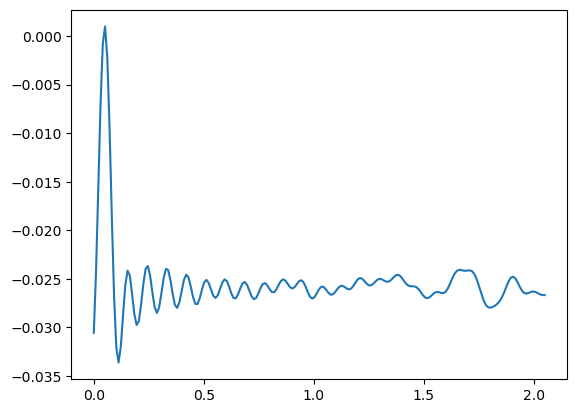

In [6]:

plt.plot(tau,(sig_p+sig_m)/2)
#plt.plot(tau,sig_m)
#plt.plot(tau,sig_c)
#plt.ylim([-1, 1])

In [163]:
tau

array([0.     , 0.01025, 0.0205 , 0.03075, 0.041  , 0.05125, 0.0615 ,
       0.07175, 0.082  , 0.09225, 0.1025 , 0.11275, 0.123  , 0.13325,
       0.1435 , 0.15375, 0.164  , 0.17425, 0.1845 , 0.19475, 0.205  ,
       0.21525, 0.2255 , 0.23575, 0.246  , 0.25625, 0.2665 , 0.27675,
       0.287  , 0.29725, 0.3075 , 0.31775, 0.328  , 0.33825, 0.3485 ,
       0.35875, 0.369  , 0.37925, 0.3895 , 0.39975, 0.41   , 0.42025,
       0.4305 , 0.44075, 0.451  , 0.46125, 0.4715 , 0.48175, 0.492  ,
       0.50225, 0.5125 , 0.52275, 0.533  , 0.54325, 0.5535 , 0.56375,
       0.574  , 0.58425, 0.5945 , 0.60475, 0.615  , 0.62525, 0.6355 ,
       0.64575, 0.656  , 0.66625, 0.6765 , 0.68675, 0.697  , 0.70725,
       0.7175 , 0.72775, 0.738  , 0.74825, 0.7585 , 0.76875, 0.779  ,
       0.78925, 0.7995 , 0.80975, 0.82   , 0.83025, 0.8405 , 0.85075,
       0.861  , 0.87125, 0.8815 , 0.89175, 0.902  , 0.91225, 0.9225 ,
       0.93275, 0.943  , 0.95325, 0.9635 , 0.97375, 0.984  , 0.99425,
       1.0045 , 1.01

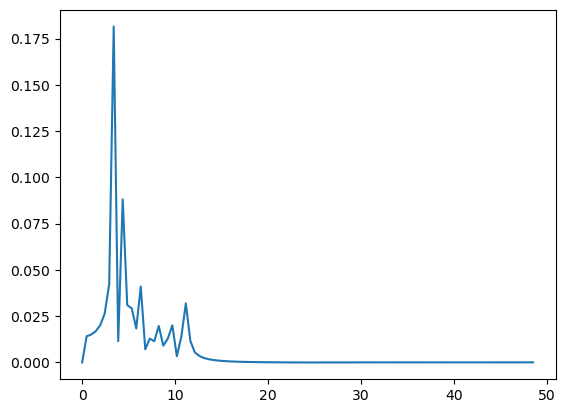

In [660]:
sig_tot=(sig_p+sig_m)/2
freq = np.fft.rfftfreq(len(tau), d=2.05/200)
plt.plot(freq, np.abs(np.real(np.fft.rfft(sig_tot-np.mean(sig_tot))*5)))
#plt.plot(freq, np.abs(np.real(np.fft.rfft(Vsim-np.mean(Vsim)))))

Text(0.5, 0, "$\\tau'(\\mu s)$")

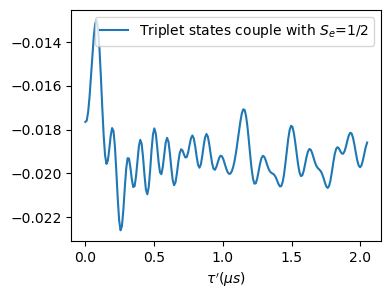

In [541]:
plt.figure(figsize=(4,3))
plt.plot(tau, (sig_p+sig_m)/2, label=r"Triplet states couple with ${S_e}$=1/2")
#plt.plot(tau, 1-sig_m, label=r"Triplet states couple with $m_{S_e}$=-1/2 state")
#plt.plot(tau, 1-sig_c, label=r"eYFP only (Spin $S_e$ removed)")
plt.legend()
plt.xlabel(r"$\tau'(\mu s)$")

## Using Stefan's DEERLab package to analyze the DEER data

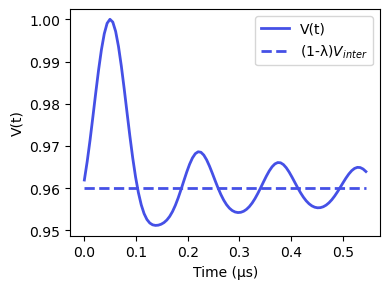

In [642]:
import deerlab as dl
@njit
def gamma_effective(B, D, E):
    p=p_function(B, D, E)
    q=2*D**3/27-2*D*E**2/3
    ang=np.arccos(3*q/(2*p)*np.sqrt(-3/p))/3
    return -2*28.02495142*B*np.cos(2*ang+np.pi*2/3)*np.sqrt(4*p**2/(-4*p**3-27*q**2))

@njit
def gamma_effective_yz(B, D, E):
    p=p_function(B, D, E)
    q=2*D**3/27-2*D*E**2/3
    ang=np.arccos(3*q/(2*p)*np.sqrt(-3/p))/3
    return 2*28.02495142*B*np.cos(2*ang)*np.sqrt(4*p**2/(-4*p**3-27*q**2))

@njit(parallel=True)
def compute_fwhm(x, y):
    n = len(y)
    peak_index = 0
    peak_value = y[0]
    
    # Find peak manually
    for i in prange(1, n):
        if y[i] > peak_value:
            peak_value = y[i]
            peak_index = i

    half_max = peak_value / 2.0

    # Search left side
    x_left = x[0]
    for i in prange(peak_index, 0, -1):
        if y[i] < half_max and y[i+1] >= half_max:
            # linear interpolation
            x1 = x[i]
            x2 = x[i+1]
            y1 = y[i]
            y2 = y[i+1]
            x_left = x1 + (half_max - y1) * (x2 - x1) / (y2 - y1)
            break

    # Search right side
    x_right = x[-1]
    for i in prange(peak_index, n - 1):
        if y[i] >= half_max and y[i+1] < half_max:
            # linear interpolation
            x1 = x[i]
            x2 = x[i+1]
            y1 = y[i]
            y2 = y[i+1]
            x_right = x1 + (half_max - y1) * (x2 - x1) / (y2 - y1)
            break

    fwhm = x_right - x_left
    return fwhm
    
# Simulation parameters
tau1, tau2 = 0.05, 0.5 # Inter-pulse delays, µs
tmin = 0.0            # Start time, μs
Δt = (tau1+tau2)/100           # Time increment, μs

rmean = 2.0           # Mean distance, nm
rstd = 1e-3           # Distance standard deviation, nm
rmin, rmax = 1, 5   # Range of the distance vector, nm
Δr = 0.05             # Distance increment, nm

conc = 0             # Spin concentration, μM
lam = 0.040            # Modulation depth
V0 = 1                # Overall echo amplitude

# Time vector
tmax = tau1+tau2
t = np.arange(tmin, tmax, Δt)

# Distance vector
r = np.arange(rmin, rmax, Δr)

# Construct the 4-pulse DEER model
Vmodel = dl.dipolarmodel(t, r, Pmodel=dl.dd_gauss)

# Simulate the signal with orientation selection
Vsim = Vmodel(mean=rmean, std=rstd, conc=conc, scale=V0, mod=lam, reftime=tau1)

# Scaled background (for plotting)
Vinter = V0*(1-lam)*dl.bg_hom3d(t-tau1, conc, lam)

# Plot the simulated signal
violet = '#4550e6'
plt.figure(figsize=[4,3])
plt.plot(t, Vsim, color=violet, lw=2, label='V(t)')
plt.plot(t, Vinter, '--', color=violet, lw=2, label='(1-λ)$V_{inter}$')
plt.legend()
plt.xlabel('Time (μs)')
plt.ylabel('V(t)')
plt.tight_layout()
plt.show()


In [661]:
Vexp=(sig_p+sig_m)/2
Vexp = (Vexp-np.min(Vexp))/(np.max(Vexp)-np.min(Vexp))     # Rescaling (aesthetic)
#t = t - t[0]                  # Account for zerotime
#t = t + tmin  
t = np.linspace(0, 2.05, 201)  
# Distance vector
r = np.arange(1.0,5.0,0.02) # nm

# Construct the model
Vmodel = dl.dipolarmodel(t,r, experiment = dl.ex_4pdeer(tau1,tau2, pathways=[1,2, 3,4]))

# Fit the model to the data
results = dl.fit(Vmodel,Vexp)

# Print results summary
print(results)

Goodness-of-fit: 
========= ============= ============== ===================== ======= 
 Dataset   Noise level    Reduced 𝛘2    Residual autocorr.    RMSD   
========= ============= ============== ===================== ======= 
   #1         0.033         16.115             1.896          0.128  
========= ============= ============== ===================== ======= 
Model hyperparameters: 
 Regularization parameter  
          0.050            
Model parameters: 
=========== ========== ========================= ====== ====================================== 
 Parameter   Value      95%-Confidence interval   Unit   Description                           
=========== ========== ========================= ====== ====================================== 
 lam1        0.214      (0.00e+00,0.456)                 Amplitude of pathway #1               
 reftime1    0.043      (0.002,0.098)              μs    Refocusing time of pathway #1         
 lam2        0.272      (0.00e+00,0.588)             

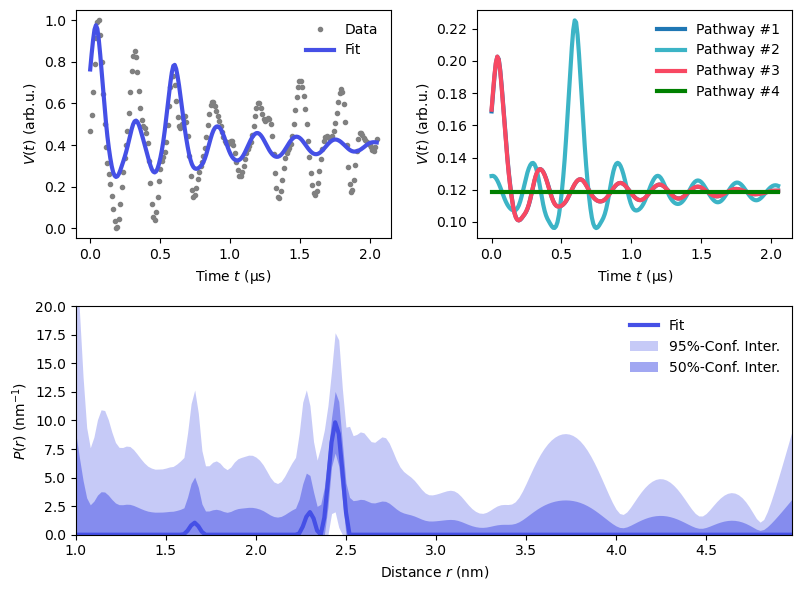

In [662]:
Vfit = results.model

# Extract fitted distance distribution
Pfit = results.P
Pci95 = results.PUncert.ci(95)
Pci50 = results.PUncert.ci(50)

plt.figure(figsize=[8,6])
violet = '#4550e6'
green = '#3cb4c6'
red = '#f84862'
plt.subplot(221)
# Plot experimental data
plt.plot(t,Vexp,'.',color='grey',label='Data')
# Plot the fitted signal
plt.plot(t,Vfit,linewidth=3,color=violet,label='Fit')
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')

plt.subplot(222)
lams = [results.lam1, results.lam2, results.lam3, results.lam4]
reftimes = [results.reftime1, results.reftime2, results.reftime3, results.reftime4]
colors= ['tab:blue',green, red, 'g']
Vinter = results.P_scale*(1-np.sum(lams))*np.prod([dl.bg_hom3d(t-reftime,results.conc,lam) for lam,reftime in zip(lams,reftimes)],axis=0)
for n,(lam,reftime,color) in enumerate(zip(lams,reftimes,colors)):
    Vpath = (1-np.sum(lams) + lam*dl.dipolarkernel(t-reftime,r)@Pfit)*Vinter
    plt.plot(t,Vpath,linewidth=3,label=f'Pathway #{n+1}',color=color)
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')

# Plot the distance distribution
plt.subplot(212)
plt.plot(r,Pfit,linewidth=3,color=violet,label='Fit')
plt.fill_between(r,Pci95[:,0],Pci95[:,1],alpha=0.3,color=violet,label='95%-Conf. Inter.',linewidth=0)
plt.fill_between(r,Pci50[:,0],Pci50[:,1],alpha=0.5,color=violet,label='50%-Conf. Inter.',linewidth=0)
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')
plt.ylim([0, 20])

plt.tight_layout()
plt.show()


In [645]:
#Measured distance d
def Obtain_coupling_strength(r, P, d):
    r_ave=0.0
    r_var=0.0
    dr=r[1]-r[0]
    for i in range(len(P)):
        r_ave+=r[i]*P[i]*dr
    #print(r_ave)
    for i in range(len(P)):
        r_var+=(r[i]-r_ave)**2*P[i]*dr
    gamma_e=(d/r_ave)**3
    gamma_e_unc=np.sqrt(r_var)*3/r_ave*gamma_e
    return r_ave, np.sqrt(r_var), gamma_e, gamma_e_unc

In [664]:
for i in range(len(Pfit)):
    r_3_ave+=r[i]**3*P[i]*dr
#print(r_ave)
for i in range(len(P)):
    r_var+=(r[i]-r_ave)**2*P[i]*dr

NameError: name 'r_3_ave' is not defined

In [668]:
r[np.argmax(Pfit)]

np.float64(2.4400000000000013)

In [665]:
Obtain_coupling_strength(r,Pfit, 2 )

(np.float64(2.3729584249694775),
 np.float64(0.19676117851786487),
 np.float64(0.5987142557671511),
 np.float64(0.14893272632246762))

In [670]:
#Data fitting for D
gamma_effective_yz(0.03, 2.35, 0.468)#**(1/3)*1.753*2**(1/6)

0.30425880313533016

In [655]:
2**(1/6)*1.75

1.9643085845414028

In [264]:
np.mean(Tyz)

np.complex128(2.011791674084006+0j)

In [235]:
gamma_effective_yz(0.03, 2.35, 0.468)

0.30425880313533016

In [41]:
compute_fwhm(r, Pfit)

c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\numba\parfors\parfor.py:2395: NumbaPerformanceWarning: 
prange or pndindex loop will not be executed in parallel due to there being more than one entry to or exit from the loop (e.g., an assertion).

File "..\Users\compt\AppData\Local\Temp\ipykernel_29772\443366518.py", line 37:
<source missing, REPL/exec in use?>

  warnings.warn(
c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\numba\parfors\parfor.py:2395: NumbaPerformanceWarning: 
prange or pndindex loop will not be executed in parallel due to there being more than one entry to or exit from the loop (e.g., an assertion).

File "..\Users\compt\AppData\Local\Temp\ipykernel_29772\443366518.py", line 25:
<source missing, REPL/exec in use?>

  warnings.warn(


0.0019618666139318286

## DEER on Tz-Tx transition

In [5]:
tau, sig_p, sig_m, sig_c=DEER_4_pulse_numba(Rabi_freq_xz, 0.0115, Omega1, deltaxz, Dss_zx, tau_eyfp_1, tau_eyfp_2, 101, nz, nx)

ValueError: x and y must have same first dimension, but have shapes (201,) and (101,)

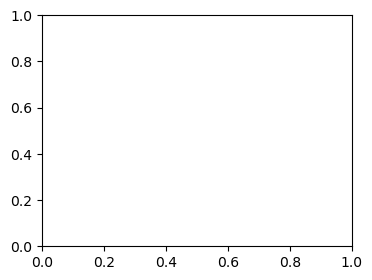

In [128]:
plt.figure(figsize=(4,3))
plt.plot(tau, (sig_p+sig_m)/2, label=r"Triplet states couple with ${S_e}$=1/2")
#plt.plot(tau, 1-sig_m, label=r"Triplet states couple with $m_{S_e}$=-1/2 state")
#plt.plot(tau, 1-sig_c, label=r"eYFP only (Spin $S_e$ removed)")
plt.legend()
plt.xlabel(r"$\tau'(\mu s)$")

In [127]:
N_mol = 20001 #Total molecule number
phi_01, theta_01, chi_01=Generate_molecule_set(N_mol)
N_tau=201 #Time sequence resolution
tau_eyfp_1=0.05 #unit: us
tau_eyfp_2=2 #unit: us
tau_total=tau1+tau2
tau=np.linspace(0, tau_total, N_tau)
#theta_12 = 0 # Polar angle theta_12 is usually a fixed value for dumbbell model
#phi_12 = 0 # Set phi_12=0 for simplicity; but generally it is not)


V = 52.16/1000 # Hss coefficient, unit: 2pi*GHz*nm^3
#d = 2 # distance, unit: nm
D0 = 2.356 #GHz
E0 = 0.458 #GHz
#B0 = 0.03 # T
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note
#t_pi=0.011055 #Tz-Tx pi pulse duration, unit: us, the value is defined from the Rabi oscillation part of this jupyter notebook
t_pi=0.0115 #Tz-Ty pi pulse duration
# Distance vector
r = np.arange(1.5,8,0.02) # nm
# Construct the model
Vmodel = dl.dipolarmodel(tau,r, experiment = dl.ex_4pdeer(tau_eyfp_1,tau_eyfp_2, pathways=[1,2, 3,4]))

N_mesh=15
N_d=7
pi_pulse_list=np.array([0.014,0.012, 0.011, 0.011, 0.015, 0.016, 0.016, 0.018, 0.020, 0.022, 0.025, 0.027, 0.029, 0.03, 0.031])
B0_list=np.array([0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15])
d_list = np.linspace(2, 5, N_d)
all_result_zx = [["" for _ in range(N_d)] for _ in range(N_mesh)]
sim_result_zx = [["" for _ in range(N_d)] for _ in range(N_mesh)]
def simulate_point_zx(i, j):
    B0 = B0_list[i]
    d = d_list[j]
    Txz, Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = \
        Transitions_and_couplings_calculation(B0, D0, E0, d, Omega1, pi_pulse_list[i], phi_01, theta_01, chi_01, theta_12, phi_12)
    
    tau, sig_p, sig_m, sig_c = DEER_4_pulse_numba(Rabi_freq_xz, pi_pulse_list[i], Omega1, deltaxz, Dss_zx, tau_eyfp_1, tau_eyfp_2, N_tau, nz, nx)
    sim_result = [tau, sig_p, sig_m, sig_c]
    
    Vexp_0 = (sig_p + sig_m) / 2
    Vexp = (Vexp_0 - np.min(Vexp_0)) / (np.max(Vexp_0) - np.min(Vexp_0))
    fit_result = dl.fit(Vmodel, Vexp)
    
    return (i, j, sim_result, fit_result)

# Parallel execution
results = Parallel(n_jobs=-1)(
    delayed(simulate_point_zx)(i, j)
    for i in range(N_mesh)
    for j in range(N_d)
)

# Organize results back into 2D lists
for i, j, sim_result, fit_result in results:
    sim_result_zx[i][j] = sim_result
    all_result_zx[i][j] = fit_result

In [115]:
import pickle

with open("sim_result_10000moleQs_10-150mT_2-5nm_2.pkl", "wb") as f:
    pickle.dump(results, f) #Save the whole results as fit_result.pkl

In [116]:
r_all_zx=np.zeros((N_mesh, N_d))
r_all_zx_unc=np.zeros((N_mesh, N_d))
D_eff_all_zx=np.zeros((N_mesh, N_d))
dr=r[1]-r[0]
for i in range(N_mesh):
    for j in range(N_d):
        Pfit=all_result_zx[i][j].P
        for r_i in range(len(r)):
            r_all_zx[i][j]+=r[r_i]*Pfit[r_i]*dr
        D_eff_all_zx[i][j]=(d/r_all_zx[i][j])**3
for i in range(N_mesh):
    for j in range(N_d):
        Pfit=all_result_zx[i][j].P
        for r_i in range(len(r)):
            r_all_zx_unc[i][j]+=(r[r_i]-r_all_zx[i][j])**2*Pfit[r_i]*dr

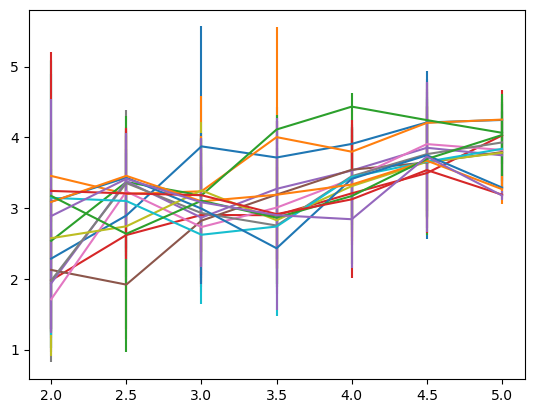

In [120]:
n=1
for n in range(N_mesh): 
    plt.errorbar(d_list, r_all_zx[n], np.sqrt(r_all_zx_unc[n]))
    #print(B_0_list[n])


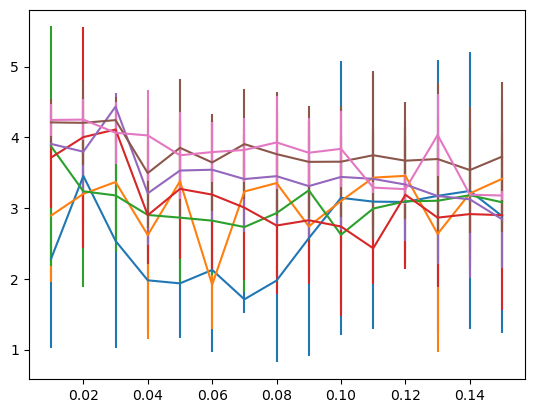

In [119]:
for n in range(N_d): 
    plt.errorbar(B0_list, r_all_zx[:,n], np.sqrt(r_all_zx_unc[:,n]))

In [122]:
len(B0_list)

15

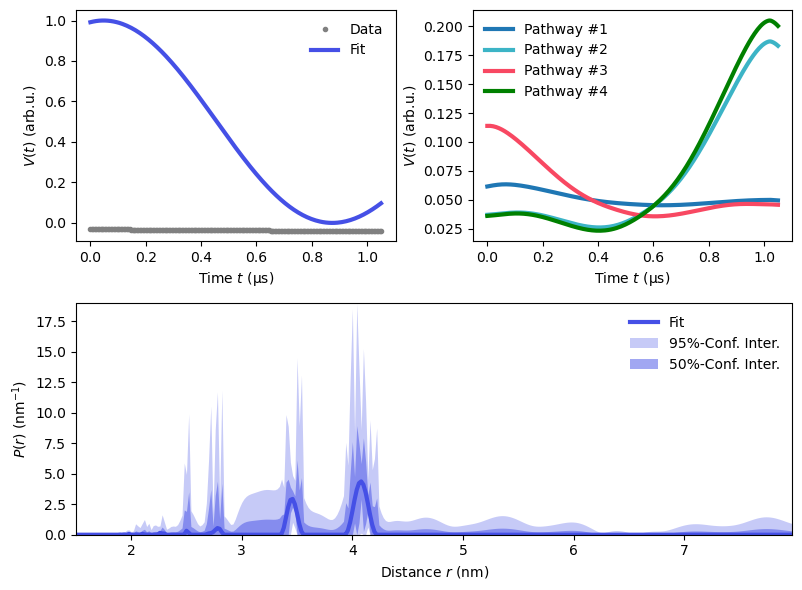

In [126]:
i=5
j=6
Vfit = all_result_zx[i][j].model
Vexp=(sim_result_zx[i][j][1]+sim_result_zx[i][j][2])/2
t=sim_result_zx[i][j][0]

# Extract fitted distance distribution
Pfit = all_result_zx[i][j].P
Pci95 = all_result_zx[i][j].PUncert.ci(95)
Pci50 = all_result_zx[i][j].PUncert.ci(50)

plt.figure(figsize=[8,6])
violet = '#4550e6'
green = '#3cb4c6'
red = '#f84862'
plt.subplot(221)
# Plot experimental data
plt.plot(t,Vexp,'.',color='grey',label='Data')
# Plot the fitted signal
plt.plot(t,Vfit,linewidth=3,color=violet,label='Fit')
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')

plt.subplot(222)
lams = [ all_result_zx[i][j].lam1, all_result_zx[i][j].lam2, all_result_zx[i][j].lam3, all_result_zx[i][j].lam4]
reftimes = [all_result_zx[i][j].reftime1, all_result_zx[i][j].reftime2, all_result_zx[i][j].reftime3, all_result_zx[i][j].reftime4]
colors= ['tab:blue',green, red, 'g']
Vinter = all_result_zx[i][j].P_scale*(1-np.sum(lams))*np.prod([dl.bg_hom3d(t-reftime,all_result_zx[i][j].conc,lam) for lam,reftime in zip(lams,reftimes)],axis=0)
for n,(lam,reftime,color) in enumerate(zip(lams,reftimes,colors)):
    Vpath = (1-np.sum(lams) + lam*dl.dipolarkernel(t-reftime,r)@Pfit)*Vinter
    plt.plot(t,Vpath,linewidth=3,label=f'Pathway #{n+1}',color=color)
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')

# Plot the distance distribution
plt.subplot(212)
plt.plot(r,Pfit,linewidth=3,color=violet,label='Fit')
plt.fill_between(r,Pci95[:,0],Pci95[:,1],alpha=0.3,color=violet,label='95%-Conf. Inter.',linewidth=0)
plt.fill_between(r,Pci50[:,0],Pci50[:,1],alpha=0.5,color=violet,label='50%-Conf. Inter.',linewidth=0)
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')

plt.tight_layout()
plt.show()


## DEER on Tz-Ty transition

### Note: need to run another Rabi oscillation to determine the pi pulse duration for Tz-Ty transition

In [6]:
#t_pi=12.56281407035176 #Note: need to run another Rabi oscillation to determine the pi pulse duration for Tz-Ty transition
tau, sig_p, sig_m, sig_c=DEER_4_pulse_numba(Rabi_freq_yz, 0.0115, Omega1, deltayz, Dss_zy, tau_eyfp_1, tau_eyfp_2, 201, nz, ny)

In [7]:
len(Rabi_freq_yz)

300000

Text(0.5, 0, "$\\tau'(\\mu s)$")

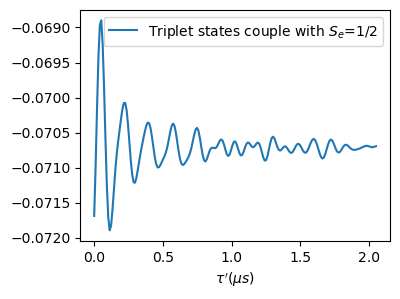

In [8]:
plt.figure(figsize=(4,3))
plt.plot(tau, (sig_p+sig_m)/2, label=r"Triplet states couple with ${S_e}$=1/2")
#plt.plot(tau, 1-sig_m, label=r"Triplet states couple with $m_{S_e}$=-1/2 state")
#plt.plot(tau, 1-sig_c, label=r"eYFP only (Spin $S_e$ removed)")
plt.legend()
plt.xlabel(r"$\tau'(\mu s)$")

In [ ]:
#MW_linewidth=10 #MHz; we assume that we are driving the molecules with detuning less than 2 times of linewidth
N_mol = 10001 #Total molecule number
phi_01, theta_01, chi_01=Generate_molecule_set(N_mol)
N_tau=201 #Time sequence resolution
tau_eyfp_1=0.05 #unit: us
tau_eyfp_2=0.5 #unit: us
tau_total=tau1+tau2
tau=np.linspace(0, tau_total, N_tau)
#theta_12 = 0 # Polar angle theta_12 is usually a fixed value for dumbbell model
#phi_12 = 0 # Set phi_12=0 for simplicity; but generally it is not)


V = 52.16/1000 # Hss coefficient, unit: 2pi*GHz*nm^3
d = 2 # distance, unit: nm
D0 = 2.356 #GHz
E0 = 0.458 #GHz
B0 = 0.05 # T
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note
#t_pi=0.011055 #Tz-Tx pi pulse duration, unit: us, the value is defined from the Rabi oscillation part of this jupyter notebook
t_pi=0.014 #Tz-Ty pi pulse duration
# Distance vector
r = np.arange(1.5,3,0.02) # nm
# Construct the model
Vmodel = dl.dipolarmodel(tau,r, experiment = dl.ex_4pdeer(tau_eyfp_1,tau_eyfp_2, pathways=[1,2, 3,4]))

N_mesh=100
theta_12_array=np.linspace(0, np.pi, N_mesh)
phi_12_array=np.linspace(0, 2*np.pi, N_mesh)

In [ ]:
#Running the simulation in parallel
from joblib import Parallel, delayed
import time

def simulate_point(i, j):
    Txz, Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = \
        Transitions_and_couplings_calculation_numba(
            B0, D0, E0, d, Omega1, phi_01, theta_01, chi_01,
            theta_12_array[i], phi_12_array[j]
        )

    tau, sig_p, sig_m, sig_c = DEER_4_pulse_numba(
        Rabi_freq_yz, 0.015, Omega1, deltayz, Dss_zy,
        tau_eyfp_1, tau_eyfp_2, N_tau, nz, ny
    )

    Vexp_0 = (sig_p + sig_m) / 2
    Vexp = (Vexp_0 - np.min(Vexp_0)) / (np.max(Vexp_0) - np.min(Vexp_0))
    
    results = dl.fit(Vmodel, Vexp)
    
    return i, j, results, [tau, sig_p, sig_m, sig_c]

t0 = time.time()
results = Parallel(n_jobs=-1)(  # use all cores
    delayed(simulate_point)(i, j)
    for i in range(N_mesh)
    for j in range(N_mesh)
)
print("Total time:", time.time() - t0, "s")

gamma_eff = np.zeros((N_mesh, N_mesh))
gamma_eff_unc = np.zeros((N_mesh, N_mesh))
all_result = [["" for _ in range(N_mesh)] for _ in range(N_mesh)]
sim_result = [["" for _ in range(N_mesh)] for _ in range(N_mesh)]

for i, j, fit_result, sim_out in results:
    all_result[i][j] = fit_result
    sim_result[i][j] = sim_out

Total time: 10989.17659497261 s


In [208]:
Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation(B0, D0, E0, d, Omega1, t_pi, phi_01, theta_01, chi_01, 0.0, 0.0)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUntyped global name 'Rabi_frequency_v2':[0m [1m[1mCannot determine Numba type of <class 'function'>[0m
[1m
File "..\Users\compt\AppData\Local\Temp\ipykernel_38540\1666917694.py", line 37:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m
[0m[1mDuring: Pass nopython_type_inference[0m

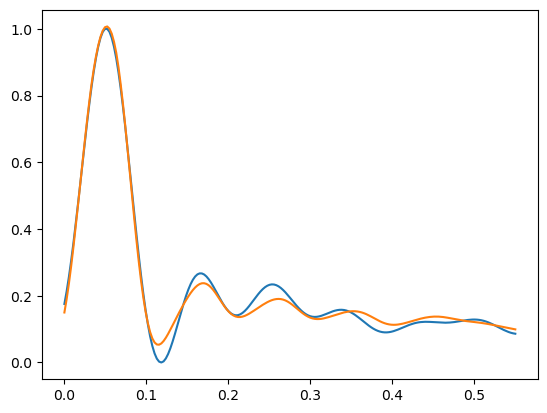

In [53]:
exp_test=(sim_result[0][66][1]+sim_result[0][66][2])/2
plt.plot(sim_result[0][66][0], (exp_test-np.min(exp_test))/(np.max(exp_test)-np.min(exp_test)))
plt.plot(sim_result[0][66][0],all_result[0][66].model)

In [84]:
r_all=np.zeros((N_mesh, N_mesh))
r_all_unc=np.zeros((N_mesh, N_mesh))
D_eff_all=np.zeros((N_mesh, N_mesh))
dr=r[1]-r[0]
for i in range(N_mesh):
    for j in range(N_mesh):
        Pfit=all_result[i][j].P
        for r_i in range(len(r)):
            r_all[i][j]+=r[r_i]*Pfit[r_i]*dr
        D_eff_all[i][j]=(d/r_all[i][j])**3
for i in range(N_mesh):
    for j in range(N_mesh):
        Pfit=all_result[i][j].P
        for r_i in range(len(r)):
            r_all_unc[i][j]+=(r[r_i]-r_all[i][j])**2*Pfit[r_i]*dr

In [93]:
results[0][3][1]

array([-0.06773448, -0.06771325, -0.06768649, -0.06765468, -0.06761848,
       -0.06757871, -0.06753633, -0.06749241, -0.0674481 , -0.0674046 ,
       -0.06736309, -0.06732476, -0.06729068, -0.06726183, -0.06723906,
       -0.06722302, -0.06721417, -0.06721276, -0.06721883, -0.06723216,
       -0.06725235, -0.06727876, -0.06731059, -0.06734688, -0.06738654,
       -0.0674284 , -0.06747126, -0.06751391, -0.06755518, -0.06759399,
       -0.06762937, -0.06766051, -0.06768678, -0.06770775, -0.06772319,
       -0.06773309, -0.06773766, -0.06773728, -0.06773253, -0.06772413,
       -0.06771292, -0.06769983, -0.06768581, -0.06767183, -0.06765881,
       -0.06764762, -0.06763897, -0.06763349, -0.06763159, -0.06763355,
       -0.06763942, -0.06764908, -0.06766224, -0.06767841, -0.06769698,
       -0.06771721, -0.06773825, -0.06775924, -0.06777927, -0.06779746,
       -0.06781299, -0.06782515, -0.06783333, -0.06783707, -0.06783608,
       -0.06783027, -0.06781971, -0.06780466, -0.06778556, -0.06

In [87]:
import pickle

with open("fit_result_100000moleQs_100x100Grid.pkl", "wb") as f:
    pickle.dump(results, f) #Save the whole results as fit_result.pkl

In [752]:
with open("fit_result.pkl", "rb") as f:
    loaded_result = pickle.load(f) #Read the saved file and do not interrupt the type of the object

print(loaded_result)

Goodness-of-fit: 
========= ============= ============= ===================== ======= 
 Dataset   Noise level   Reduced 𝛘2    Residual autocorr.    RMSD   
========= ============= ============= ===================== ======= 
   #1         0.028         1.081             1.655          0.026  
========= ============= ============= ===================== ======= 
Model hyperparameters: 
 Regularization parameter  
          0.012            
Model parameters: 
=========== ========== ========================= ====== ====================================== 
 Parameter   Value      95%-Confidence interval   Unit   Description                           
=========== ========== ========================= ====== ====================================== 
 lam1        0.233      (0.179,0.288)                    Amplitude of pathway #1               
 reftime1    0.072      (0.067,0.077)              μs    Refocusing time of pathway #1         
 lam2        0.406      (0.236,0.577)                    A

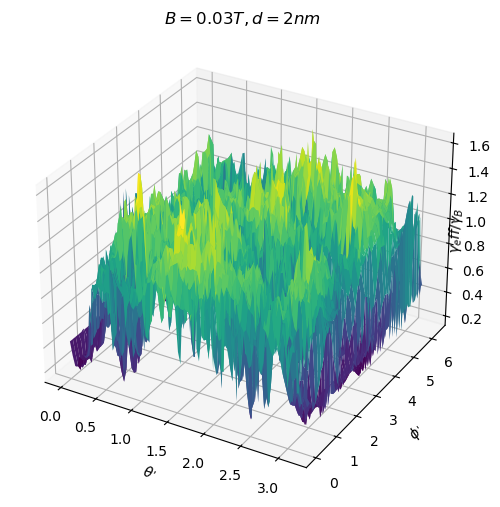

In [85]:
fig = plt.figure(figsize=(6,8))  # Create a figure
ax1 = fig.add_subplot(111, projection='3d')  # Add 3D axes
x, y = np.meshgrid(theta_12_array, phi_12_array)
ax1.set_title(r'$B=0.03T, d = 2nm$')
ax1.plot_surface(x,y, D_eff_all.T, cmap='viridis')
ax1.set_xlabel(r'$\theta^,$')
ax1.set_ylabel(r'$\phi^,$')
ax1.set_zlabel(r'$\gamma_eff/\gamma_B$', labelpad=-18)
ax1.zaxis.label.set_position((3, 6, 0))

In [754]:
with open("DEERLab_fitresult_grid_20-by-20.pkl", "wb") as f:
    pickle.dump(all_result, f)

In [764]:
simulation_configuration=[phi_01, theta_01, chi_01,Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz]
with open("DEERLab_simulation_configuration_20-by-20.pkl", "wb") as f:
    pickle.dump(simulation_configuration, f)

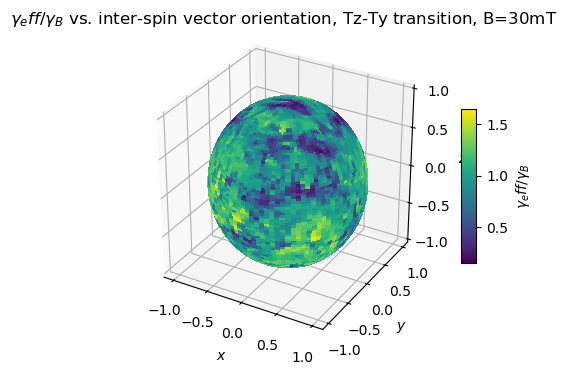

In [86]:
from matplotlib.cm import ScalarMappable
theta, phi = np.meshgrid(theta_12_array, phi_12_array)

# Step 2: Compute Cartesian coordinates for the unit sphere
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)
F = D_eff_all.T
F_norm = (F - F.min()) / (F.max() - F.min())
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
#x,y,z=np.sin(theta_01)*np.cos(chi_01), np.sin(theta_01)*np.sin(chi_01), np.cos(theta_01), 
# Plot the surface and use the colormap to set face colors based on F_norm
surf = ax.plot_surface(
    x, y, z, 
    facecolors=plt.cm.viridis(F_norm), 
    rstride=1, cstride=1, 
    linewidth=0, antialiased=False, shade=False
)

# Step 4: Add a colorbar
mappable = ScalarMappable(cmap='viridis')
mappable.set_array(F)
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10, label=r'$\gamma_eff/\gamma_B$')

# Setting labels and title
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.set_box_aspect([1,1,1])  # Ensure equal scaling

plt.title(r"$\gamma_eff/\gamma_B$ vs. inter-spin vector orientation, Tz-Ty transition, B=30mT")
plt.show()

Grid on the lab orientation

In [ ]:
N_mesh_2 = 5
N_total = N_mesh_2**3

i, j, k = np.indices((N_mesh_2, N_mesh_2, N_mesh_2))

phi_01_2 = (2 * np.pi * i.flatten()) / (N_mesh_2 - 1)
theta_01_2 = (np.pi * j.flatten()) / (N_mesh_2 - 1) 
chi_01_2 = (2 * np.pi * k.flatten()) / (N_mesh_2 - 1)
#theta_01_2 = np.arccos(cos_theta_01_2)

In [100]:
def simulate_point_2(i, j):
    Txz, Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = \
        Transitions_and_couplings_calculation(
            0.03, D0, E0, d, Omega1, t_pi, phi_01_2, theta_01_2, chi_01_2,
            theta_12_array[i], phi_12_array[j]
        )

    tau, sig_p, sig_m, sig_c = DEER_4_pulse_numba(
        Rabi_freq_yz, 0.015, Omega1, deltayz, Dss_zy,
        tau_eyfp_1, tau_eyfp_2, N_tau, nz, ny
    )

    Vexp_0 = (sig_p + sig_m) / 2
    Vexp = (Vexp_0 - np.min(Vexp_0)) / (np.max(Vexp_0) - np.min(Vexp_0))
    
    results = dl.fit(Vmodel, Vexp)
    
    return i, j, results, [tau, sig_p, sig_m, sig_c]

t0 = time.time()
results = Parallel(n_jobs=-1)(  # use all cores
    delayed(simulate_point_2)(i, j)
    for i in range(N_mesh)
    for j in range(N_mesh)
)
print("Total time:", time.time() - t0, "s")

gamma_eff = np.zeros((N_mesh, N_mesh))
gamma_eff_unc = np.zeros((N_mesh, N_mesh))
all_result = [["" for _ in range(N_mesh)] for _ in range(N_mesh)]
sim_result = [["" for _ in range(N_mesh)] for _ in range(N_mesh)]

for i, j, fit_result, sim_out in results:
    all_result[i][j] = fit_result
    sim_result[i][j] = sim_out

KeyboardInterrupt: 

In [ ]:
gamma_eff=np.zeros((N_mesh, N_mesh))
gamma_eff_unc=np.zeros((N_mesh, N_mesh))
all_result = [["" for _ in range(N_mesh)] for _ in range(N_mesh)]
sim_result = [["" for _ in range(N_mesh)] for _ in range(N_mesh)]

t0=time.time()
for i in range(N_mesh):
    for j in range(N_mesh):
        sig_for_signal_configuration=np.zeros((3, N_tau))
        for k in range(N_mesh_2):
            for l in range(N_mesh_2):
                for m in range(N_mesh_2):
                    Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation(B0, D0, E0, d, Omega1, t_pi, phi_01_2[k], theta_01_2[l], chi_01_2[m], theta_12_array[i], phi_12_array[j])
                    tau, sig_p, sig_m, sig_c = DEER_4_pulse_numba(Rabi_freq_yz, 0.014, Omega1, deltayz, Dss_zy, tau_eyfp_1, tau_eyfp_2, N_tau, nz, ny)
                    sig_for_signal_configuration[0]+=sig_p
                    sig_for_signal_configuration[1]+=sig_m
                    #sig_for_signal_configuration[2]+=sig_c
        
        Vexp_0 = (sig_for_signal_configuration[0]+sig_for_signal_configuration[1])/2/N_mesh_2**3
        sim_result[i][j] = [tau, Vexp_0 ]
        Vexp = (Vexp_0-np.min(Vexp_0))/(np.max(Vexp_0)-np.min(Vexp_0))  
        results = dl.fit(Vmodel,Vexp)
        all_result[i][j] = results
        
        print(i, j, time.time()-t0, 's')

TypeError: object of type 'numpy.float64' has no len()

## 2D Rabi oscillation on Tz-Ty transition

Here we will scan over the Tz-Ty transition frequency and obtain a Rabi spectrum for each frequency. Then, we will pile up the spectra to make a 2D Rabi plot.

In [ ]:
#Functions
@njit
def Rabi_frequency_v2_numba(v1:complex, v2:complex, phi:float, theta:float, chi:float):
    C1=matmul_numba(np.conj(v1).reshape((1, 3)),matmul_numba(T1pS(np.exp(1j*chi)*(-1j*np.sin(phi)-np.cos(theta)*np.cos(phi))/np.sqrt(2)),v2.reshape((3, 1))))
    C2=matmul_numba(np.conj(v1).reshape((1, 3)),matmul_numba(T10S(-np.sin(theta)*np.cos(phi)),v2.reshape((3, 1))))
    C3=matmul_numba(np.conj(v1).reshape((1, 3)), matmul_numba(T1mS(np.exp(-1j*chi)*(-1j*np.sin(phi)+np.cos(theta)*np.cos(phi))/np.sqrt(2)),v2.reshape((3, 1))))
    #print(C1)
    return C1[0,0]+C2[0,0]+C3[0,0]

@njit
def E_cubic_root(B_0, D_0, E_0, theta, chi):
    p=p_function(B_0, D_0, E_0)
    q = q_function(B_0, D_0, E_0, theta, chi)
    angle=ang(p,q)
    E_k = np.zeros(3)
    for k in range(3):
        E_k[k] = (2 * np.sqrt(-p / 3) * np.cos(angle+2*np.pi*(k+1)/3))
    return np.sort(E_k)


@njit
def eigenvector_from_eigenvalue(H, lam):
    """
    Given a 3x3 Hermitian matrix H and one of its eigenvalues lam,
    compute the corresponding eigenvector.
    """
    A = H - np.eye(3, dtype=np.complex128) * lam

    # Use cross product of two rows of A as an eigenvector estimate
    r1 = A[0]
    r2 = A[2]

    # The null space direction is orthogonal to both rows
    v = np.cross(r1, r2)

    # If zero vector (rows linearly dependent), try other pair
    if np.all(np.abs(v) < 1e-10):
        r2 = A[1]
        r3 = A[2]
        v = np.cross(r2, r3)
    if np.all(np.abs(v) < 1e-10):
        r1 = A[0]
        r3 = A[1]
        v = np.cross(r1, r3)

    # Normalize
    norm = np.sqrt(np.sum(np.abs(v)**2))
    if norm > 1e-12:
        return v / norm
    else:
        return np.zeros(3, dtype=np.complex128)
    
@njit
def eigenvector_set(H, E):
    M=np.zeros((3,3), dtype=np.complex128)
    for i in range(len(E)):
        M[i]=eigenvector_from_eigenvalue(H, E[i])
    return M.T

@njit(inline='always')
def abs2_dot(a, b):
    result = 0.0 + 0.0j
    for i in range(a.shape[0]):
        result += np.conj(a[i]) * b[i]
    return np.real(result * np.conj(result))


def matrix_exponential_diag(A):
    """
    Compute the matrix exponential e^A using the diagonalization method.
    
    This function assumes that the square matrix A is diagonalizable.
    
    Parameters:
        A (np.ndarray): A square matrix (n x n).
        
    Returns:
        expA (np.ndarray): The matrix exponential e^A.
    """
    # Compute eigenvalues and eigenvectors of A.
    eigenvalues, eigenvectors = np.linalg.eig(A)
    
    # Compute the diagonal matrix of the exponentials of the eigenvalues.
    exp_lambda = np.diag(np.exp(eigenvalues))
    
    # Compute the matrix exponential using the formula e^A = V exp(Λ) V^{-1}
    expA = eigenvectors @ exp_lambda @ np.linalg.inv(eigenvectors)
    #expA = eigenvectors @ exp_lambda @ eigenvectors.conj().T
    return expA



@njit
def matrix_exponential_diag_numba(A):
    # Compute eigenvalues and eigenvectors of A.
    eigenvalues, eigenvectors = np.linalg.eig(A)
    
    # Compute the diagonal matrix of the exponentials of the eigenvalues.
    exp_lambda = np.diag(np.exp(eigenvalues))
    
    # Compute the matrix exponential using the formula e^A = V exp(Λ) V^{-1}
    expA = matmul_numba(eigenvectors, matmul_numba(exp_lambda, np.linalg.inv(eigenvectors)))
    #expA = eigenvectors @ exp_lambda @ eigenvectors.conj().T
    return expA    


@njit(parallel=True)
def Transitions_and_couplings_calculation_numba(B0:float, D0:float, E0:float, d:float, Omega1:float, phi_01:float, theta_01:float, chi_01:float, theta_12:float, phi_12:float):
    #B0: magnetic field, D0, E0: ZFS, d: distance, Omega1: \gamma_B B_1, the Rabi frequency factor, 
    #t_pi: pi pulse duration, phi_01, theta_01, chi_01: Euler angles between Lab frame and D-tensor frame, theta_12, phi_12: inter-spin vector orientation in D-tensor frame
    N_mol=len(theta_01)
    Delta1 = np.zeros(N_mol)*(0+0j)
    Delta2 = np.zeros(N_mol)*(0+0j)
    Delta3 = np.zeros(N_mol)*(0+0j)
    nx = np.zeros(N_mol)
    ny = np.zeros(N_mol)
    nz = np.zeros(N_mol)
    Rabi_freq_xz = np.zeros(N_mol)*(0+0j)
    Rabi_freq_yz = np.zeros(N_mol)*(0+0j)
    Txz = np.zeros(N_mol)*(0+0j)
    Tyz = np.zeros(N_mol)*(0+0j)
    Txy = np.zeros(N_mol)*(0+0j)   
    nx0=0.4
    ny0=0.4
    nz0=0.2
    V = 52.16/1000
    TS_list = [T1mS(1), T10S(1), T1pS(1)]
    qs = [-1, 0, 1]
    for i in prange(N_mol):
        M1=eigenvector_set(H0(D0, E0, 0, 0.0, theta_01[i], chi_01[i]), np.array([-2*D0/3, D0/3-E0, D0/3+E0]))
        H_0 = H0(D0, E0, B0, phi_01[i], theta_01[i], chi_01[i])
        E_0 = E_cubic_root(B0, D0, E0, theta_01[i], chi_01[i])
        
        M0 = eigenvector_set(H_0, E_0)
        
        Txz[i]=E_0[2]-E_0[0]
        Tyz[i]=E_0[1]-E_0[0]
        Txy[i]=E_0[2]-E_0[1]
        
        eigvec=M0.T
        
        Rabi_freq_xz[i]=Omega1 * Rabi_frequency_v2_numba(eigvec[2], eigvec[0], phi_01[i], theta_01[i], chi_01[i])
        Rabi_freq_yz[i]=Omega1 * Rabi_frequency_v2_numba(eigvec[1], eigvec[0], phi_01[i], theta_01[i], chi_01[i])
        
        nx[i] = nx0 * abs2_dot(M1.T[2], M0.T[2]) + \
                ny0 * abs2_dot(M1.T[1], M0.T[2]) + \
                nz0 * abs2_dot(M1.T[0], M0.T[2])

        ny[i] = nx0 * abs2_dot(M1.T[2], M0.T[1]) + \
                ny0 * abs2_dot(M1.T[1], M0.T[1]) + \
                nz0 * abs2_dot(M1.T[0], M0.T[1])

        nz[i] = nx0 * abs2_dot(M1.T[2], M0.T[0]) + \
                ny0 * abs2_dot(M1.T[1], M0.T[0]) + \
                nz0 * abs2_dot(M1.T[0], M0.T[0])


        for q_idx in range(3):
            q = qs[q_idx]
            TS = TS_list[q_idx]
            Mat_prod = C_q(q, theta_01[i], chi_01[i], theta_12, phi_12) * matmul_numba(np.conj(eigvec), matmul_numba(TS, eigvec.T))
            Delta1[i] += Mat_prod[0,0]
            Delta2[i] += Mat_prod[1,1]
            Delta3[i] += Mat_prod[2,2]
        
    Txz_ave = np.mean(Txz)
    Tyz_ave=np.mean(Tyz)
    Dss_zx=V/d**3*(Delta3-Delta1)*1000*2*np.pi # Dipole coupling strength Dss for Tz-Tx transition, unit: MHz
    Dss_zy=V/d**3*(Delta2-Delta1)*1000*2*np.pi # Dipole coupling strength Dss for Tz-Ty transition, unit: MHz
    deltaxz=(Txz-Txz_ave)*1000*2*np.pi #Tz-Tx transition detuning
    deltayz=(Tyz-Tyz_ave)*1000*2*np.pi #Tz-Ty transition detuning
    
    return Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz

In [4]:
N_mol = 10001 #Total molecule number
#phi_01, theta_01, chi_01=Generate_molecule_set(N_mol)
#phi_01, theta_01, chi_01=Generate_molecule_set_equidistributed(10000, 30)
phi_01, theta_01, chi_01=Generate_molecule_set_Fibonacci_sphere(10000, 30)

V = 52.16/1000 # Hss coefficient, unit: 2pi*GHz*nm^3
d = 2 # distance, unit: nm
D0 = 2.356 #GHz
E0 = 0.458 #GHz
B0 = 0.03 # T
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note

Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation_numba(B0, D0, E0, d, Omega1, phi_01, theta_01, chi_01, 0, 0)


In [6]:

# Eff_H(Rabi, delta): returns 2x2 complex Hamiltonian
# expm_hamiltonian(H, t): returns expm(-1j * H * t)
from joblib import Parallel, delayed
def compute_freq_slice(freq_i):
    result = np.zeros(len(time_seq), dtype=np.complex128)
    for n_i in range(len(Rabi_freq_xz)):
        #H_mol = Eff_H(Rabi_freq_yz[n_i]*scale_factor, deltayz[n_i] + freq_pump[freq_i]*1000)
        H_mol = Eff_H(Rabi_freq_xz[n_i]*scale_factor, deltaxz[n_i] + freq_pump[freq_i]*1000*2*np.pi)
        for t_i in range(len(time_seq)):
            U = expm_hamiltonian(H_mol, time_seq[t_i])
            v = U @ v0
            result[t_i] += np.conj(v) @ (sz @ v)
    return freq_i, result

# === Set up ===
time_seq = np.linspace(0, 0.1, 120)
len_freq = 100
v0 = np.array([1, 0], dtype=np.complex128)
sig_2d = np.zeros((len_freq, len(time_seq)), dtype=np.complex128)
sz = np.array([[1, 0], [0, -1]], dtype=np.complex128)
#freq_pump = np.mean(Tyz) - np.linspace(np.min(Tyz), np.max(Tyz), len_freq)
freq_pump = np.mean(Txz) - np.linspace(np.max(Txz), np.min(Txz), len_freq)
scale_factor = 1

# === Run in parallel ===
results = Parallel(n_jobs=-1)(
    delayed(compute_freq_slice)(fi) for fi in range(len_freq)
)

# === Store results back ===
for fi, row in results:
    sig_2d[fi] = row
#plt.plot(freq_pump, time_seq, np.real(sig_2d)/N_mol)
#plt.xlabel('t (ns)')
#plt.ylabel('Signal')

In [617]:
hist, bin_edges=np.histogram(Tyz, bins=1000)
max_freq = np.max(hist)
max_freq_bin_index = np.argmax(hist)
bin_range = (bin_edges[max_freq_bin_index], bin_edges[max_freq_bin_index + 1])

print("Maximum frequency:", max_freq)
print("Corresponding bin range:", bin_range)


Maximum frequency: 1560
Corresponding bin range: (np.complex128(2.1366708960841647+0j), np.complex128(2.137807765944376+0j))


c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\matplotlib\transforms.py:2875: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\matplotlib\transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\matplotlib\transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


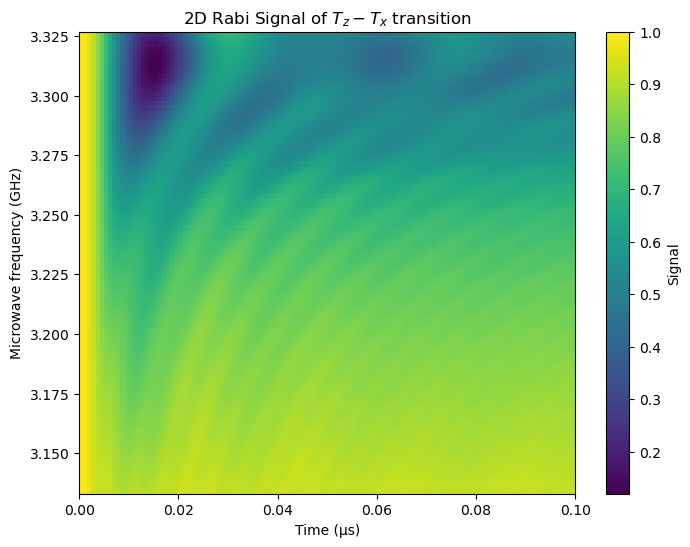

In [7]:
plt.figure(figsize=(8, 6))
plt.imshow(sig_2d.real/300000, aspect='auto', extent=[time_seq[0], time_seq[-1], -freq_pump[-1]+np.mean(Txz), -freq_pump[0]+np.mean(Txz)])
plt.colorbar(label='Signal')
plt.xlabel('Time (µs)')
plt.ylabel('Microwave frequency (GHz)')
plt.title('2D Rabi Signal of $T_z-T_x$ transition')
#plt.scatter(pi_times, -freq_pump+np.mean(Txz), marker='.')
plt.savefig('2D_Rabi_Signal_TzTx.pdf', dpi=300)

In [605]:
np.unravel_index(np.argmin(sig_2d.real/N_mol), sig_2d.real.shape)

(np.int64(6), np.int64(19))

In [606]:
time_seq[19]

np.float64(0.01596638655462185)

In [624]:
-freq_pump[6]+np.mean(Txz)

np.complex128(3.31502768592889+0j)

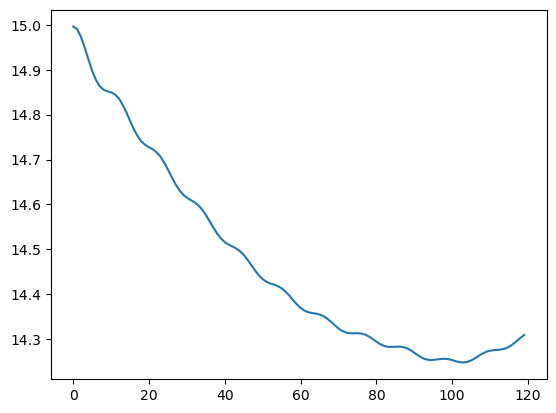

In [147]:
plt.plot((sig_2d[50]/N_mol).real, label=f"Freq={freq_pump[i]:.2f} GHz")

c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


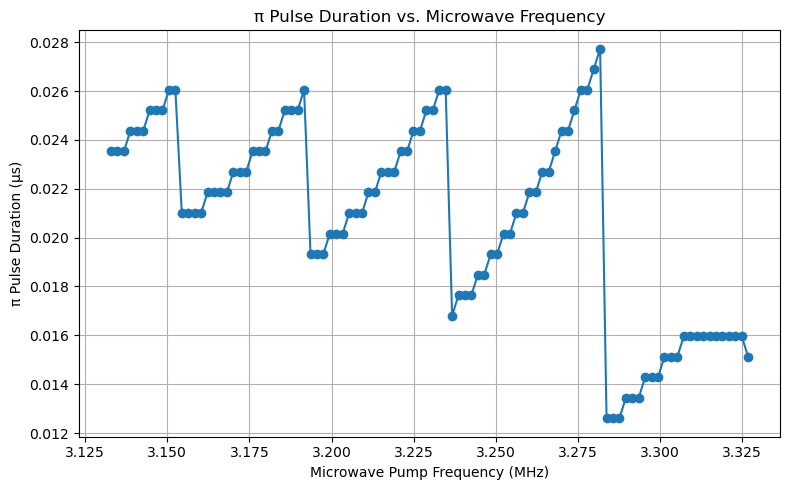

In [626]:
pi_times = np.zeros(len(freq_pump))  # holds time of min signal for each freq

for i in range(len(freq_pump)):
    signal = np.real(sig_2d[i])  # or use np.abs(...) if signal is complex
    min_idx = np.argmin(signal[0:40])  # index of minimum
    pi_times[i] = time_seq[min_idx]  # corresponding time

plt.figure(figsize=(8, 5))
plt.plot(-freq_pump+np.mean(Txz), pi_times, marker='o')
plt.xlabel("Microwave Pump Frequency (MHz)")
plt.ylabel("π Pulse Duration (µs)")
plt.title("π Pulse Duration vs. Microwave Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
from joblib import Parallel, delayed
def compute_freq_slice_yz(freq_i):
    result = np.zeros(len(time_seq), dtype=np.complex128)
    for n_i in range(len(Rabi_freq_yz)):
        #H_mol = Eff_H(Rabi_freq_yz[n_i]*scale_factor, deltayz[n_i] + freq_pump[freq_i]*1000)
        H_mol = Eff_H(Rabi_freq_yz[n_i]*scale_factor, deltayz[n_i] + freq_pump[freq_i]*1000*2*np.pi)
        for t_i in range(len(time_seq)):
            U = expm_hamiltonian(H_mol, time_seq[t_i])
            v = U @ v0
            result[t_i] += np.conj(v) @ (sz @ v)
    return freq_i, result

time_seq = np.linspace(0, 0.1, 120)
len_freq = 200
v0 = np.array([1, 0], dtype=np.complex128)
sig_2d = np.zeros((len_freq, len(time_seq)), dtype=np.complex128)
sz = np.array([[1, 0], [0, -1]], dtype=np.complex128)
freq_pump = np.mean(Tyz) - np.linspace(np.max(Tyz), np.min(Tyz), len_freq)
#freq_pump = np.mean(Txz) - np.linspace(np.min(Txz), np.max(Txz), len_freq)
scale_factor = 1

# === Run in parallel ===
results = Parallel(n_jobs=-1)(
    delayed(compute_freq_slice_yz)(fi) for fi in range(len_freq)
)

# === Store results back ===
for fi, row in results:
    sig_2d[fi] = row
#plt.plot(freq_pump, time_seq, np.real(sig_2d)/N_mol)
#plt.xlabel('t (ns)')
#plt.ylabel('Signal')

c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\matplotlib\transforms.py:2875: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\matplotlib\transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


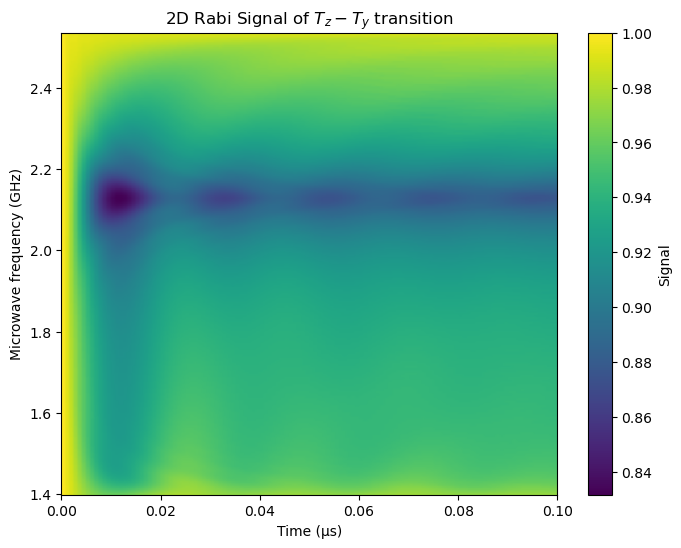

In [9]:
plt.figure(figsize=(8, 6))
plt.imshow(sig_2d.real/300000, aspect='auto', extent=[time_seq[0], time_seq[-1], -freq_pump[-1]+np.mean(Tyz), -freq_pump[0]+np.mean(Tyz)])
plt.colorbar(label='Signal')
plt.xlabel('Time (µs)')
plt.ylabel('Microwave frequency (GHz)')
plt.title('2D Rabi Signal of $T_z-T_y$ transition')
plt.savefig('2D_Rabi_Signal_TzTy.pdf', dpi=300)

In [154]:
np.unravel_index(np.argmin(sig_2d.real/N_mol), sig_2d.real.shape)


(np.int64(71), np.int64(42))

In [155]:
time_seq[42]#Obtain the time of the minimum signal for the Tz-Ty transition, use it as the pi pulse duration for the Tz-Ty transition

np.float64(0.03529411764705882)

In [156]:
freq_pump[71]-np.mean(Tyz)

np.complex128(-2.1300953322193243+0j)

## Generating data set for machine learning


Test1: generating data sets with only three parameters (d, theta_12, phi_12), the magnetic field B0 and microwave pulse are fixed

In [ ]:
@njit
def E_cubic_root(B_0, D_0, E_0, theta, chi):
    p=p_function(B_0, D_0, E_0)
    q = q_function(B_0, D_0, E_0, theta, chi)
    angle=ang(p,q)
    E_k = np.zeros(3)
    for k in range(3):
        E_k[k] = (2 * np.sqrt(-p / 3) * np.cos(angle+2*np.pi*(k+1)/3))
    return np.sort(E_k)


@njit
def eigenvector_from_eigenvalue(H, lam):
    """
    Given a 3x3 Hermitian matrix H and one of its eigenvalues lam,
    compute the corresponding eigenvector.
    """
    A = H - np.eye(3, dtype=np.complex128) * lam

    # Use cross product of two rows of A as an eigenvector estimate
    r1 = A[0]
    r2 = A[2]

    # The null space direction is orthogonal to both rows
    v = np.cross(r1, r2)

    # If zero vector (rows linearly dependent), try other pair
    if np.all(np.abs(v) < 1e-10):
        r2 = A[1]
        r3 = A[2]
        v = np.cross(r2, r3)
    if np.all(np.abs(v) < 1e-10):
        r1 = A[0]
        r3 = A[1]
        v = np.cross(r1, r3)

    # Normalize
    norm = np.sqrt(np.sum(np.abs(v)**2))
    if norm > 1e-12:
        return v / norm
    else:
        return np.zeros(3, dtype=np.complex128)
    
@njit
def eigenvector_set(H, E):
    M=np.zeros((3,3), dtype=np.complex128)
    for i in range(len(E)):
        M[i]=eigenvector_from_eigenvalue(H, E[i])
    return M.T

@njit(inline='always')
def abs2_dot(a, b):
    result = 0.0 + 0.0j
    for i in range(a.shape[0]):
        result += np.conj(a[i]) * b[i]
    return np.real(result * np.conj(result))

@njit(parallel=True)
def Transitions_and_couplings_calculation_numba(B0:float, D0:float, E0:float, d:float, Omega1:float, phi_01:float, theta_01:float, chi_01:float, theta_12:float, phi_12:float):
    #B0: magnetic field, D0, E0: ZFS, d: distance, Omega1: \gamma_B B_1, the Rabi frequency factor, 
    #t_pi: pi pulse duration, phi_01, theta_01, chi_01: Euler angles between Lab frame and D-tensor frame, theta_12, phi_12: inter-spin vector orientation in D-tensor frame
    N_mol=len(theta_01)  
    Delta1 = np.zeros(N_mol)*(0+0j)
    Delta2 = np.zeros(N_mol)*(0+0j)
    Delta3 = np.zeros(N_mol)*(0+0j)
    nx = np.zeros(N_mol)
    ny = np.zeros(N_mol)
    nz = np.zeros(N_mol)
    Rabi_freq_xz = np.zeros(N_mol)*(0+0j)
    Rabi_freq_yz = np.zeros(N_mol)*(0+0j)
    Txz = np.zeros(N_mol)*(0+0j)
    Tyz = np.zeros(N_mol)*(0+0j)
    Txy = np.zeros(N_mol)*(0+0j)   
    nx0=0.4
    ny0=0.4
    nz0=0.2
    TS_list = [T1mS(1), T10S(1), T1pS(1)]
    qs = [-1, 0, 1]
    for i in prange(N_mol):
        M1=eigenvector_set(H0(D0, E0, 0, 0.0, theta_01[i], chi_01[i]), np.array([-2*D0/3, D0/3-E0, D0/3+E0]))
        H_0 = H0(D0, E0, B0, phi_01[i], theta_01[i], chi_01[i])
        E_0 = E_cubic_root(B0, D0, E0, theta_01[i], chi_01[i])
        
        M0 = eigenvector_set(H_0, E_0)
        
        Txz[i]=E_0[2]-E_0[0]
        Tyz[i]=E_0[1]-E_0[0]
        Txy[i]=E_0[2]-E_0[1]
        
        eigvec=M0.T
        
        Rabi_freq_xz[i]=Omega1 * Rabi_frequency_v2_numba(eigvec[2], eigvec[0], phi_01[i], theta_01[i], chi_01[i])
        Rabi_freq_yz[i]=Omega1 * Rabi_frequency_v2_numba(eigvec[1], eigvec[0], phi_01[i], theta_01[i], chi_01[i])
        #nx[i]=nx0*np.abs(np.dot(np.conj(M1.T[2]), M0.T[2]))**2+ny0*np.abs(np.dot(np.conj(M1.T[1]), M0.T[2]))**2+nz0*np.abs(np.dot(np.conj(M1.T[0]), M0.T[2]))**2
        #ny[i]=nx0*np.abs(np.dot(np.conj(M1.T[2]), M0.T[1]))**2+ny0*np.abs(np.dot(np.conj(M1.T[1]), M0.T[1]))**2+nz0*np.abs(np.dot(np.conj(M1.T[0]), M0.T[1]))**2
        #nz[i]=nx0*np.abs(np.dot(np.conj(M1.T[2]), M0.T[0]))**2+ny0*np.abs(np.dot(np.conj(M1.T[1]), M0.T[0]))**2+nz0*np.abs(np.dot(np.conj(M1.T[0]), M0.T[0]))**2
        
        nx[i] = nx0 * abs2_dot(M1.T[2], M0.T[2]) + \
                ny0 * abs2_dot(M1.T[1], M0.T[2]) + \
                nz0 * abs2_dot(M1.T[0], M0.T[2])

        ny[i] = nx0 * abs2_dot(M1.T[2], M0.T[1]) + \
                ny0 * abs2_dot(M1.T[1], M0.T[1]) + \
                nz0 * abs2_dot(M1.T[0], M0.T[1])

        nz[i] = nx0 * abs2_dot(M1.T[2], M0.T[0]) + \
                ny0 * abs2_dot(M1.T[1], M0.T[0]) + \
                nz0 * abs2_dot(M1.T[0], M0.T[0])


        for q_idx in range(3):
            q = qs[q_idx]
            TS = TS_list[q_idx]
            Mat_prod = C_q(q, theta_01[i], chi_01[i], theta_12, phi_12) * matmul_numba(np.conj(eigvec), matmul_numba(TS, eigvec.T))
            Delta1[i] += Mat_prod[0,0]
            Delta2[i] += Mat_prod[1,1]
            Delta3[i] += Mat_prod[2,2]
        
    #Delta1= V/d**3*Delta1 #Dipole coupling strength of Tz state
    #Delta2= V/d**3*Delta2 #Dipole coupling strength of Ty state
    #Delta3= V/d**3*Delta3 #Dipole coupling strength of Tx state
    Txz_ave = np.mean(Txz)
    Tyz_ave=np.mean(Tyz)
    Dss_zx=V/d**3*(Delta3-Delta1)*1000*2*np.pi # Dipole coupling strength Dss for Tz-Tx transition, unit: MHz
    Dss_zy=V/d**3*(Delta2-Delta1)*1000*2*np.pi # Dipole coupling strength Dss for Tz-Ty transition, unit: MHz
    deltaxz=(Txz-Txz_ave)*1000*2*np.pi #Tz-Tx transition detuning
    deltayz=(Tyz-Tyz_ave)*1000*2*np.pi #Tz-Ty transition detuning
    
    return Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz

@njit(parallel=True)
def DEER_4_pulse_numba_samples(Rabi_freq: complex, t_pi: float, Omega1: float, delta: float, Dss:complex, tau1: float, tau2: float, t_i: float, n_g:float, n_e:float): #n_g, n_e: population on ground/excited states
    #Numba version of the 4-pulse DEER simulation
    tau_total=tau1+tau2
    #tau=np.linspace(0, tau_total, N_tau)
    N_mol=len(Rabi_freq)
    N_t_i=len(t_i)
    sig_p_all = np.zeros((N_mol, N_t_i))
    sig_m_all = np.zeros((N_mol, N_t_i))

    sig_p=np.zeros(N_t_i) #coupling to spin up
    sig_m=np.zeros(N_t_i) #coupling to spin down
    #sig_c=np.zeros_like(tau) #no coupling, for comparison only
    Dssi=0.0+0.0j
    

    O_s = np.array([[1/2,0, 0, 0], [0,-1/2, 0, 0],[0,0, 1/2, 0],[0,0, 0, -1/2]]) #Observation operator for EYFP spin
    #print('definition-1')
    for i in prange(N_mol):
        
        rho_0p = np.zeros((4, 4), dtype=np.complex128)
        rho_0m = np.zeros((4, 4), dtype=np.complex128)
        rho_0p[0, 0] = n_g[i]
        rho_0p[1, 1] = n_e[i]
        rho_0p[2, 2] = 0.0
        rho_0p[3, 3] = 0.0

        rho_0m[0, 0] = 0.0
        rho_0m[1, 1] = 0.0
        rho_0m[2, 2] = n_g[i]
        rho_0m[3, 3] = n_e[i]
        delta_1 = delta[i]
        Dssi = Dss[i]
        for j in range(N_t_i):
            #Pulse sequence
            U1=U_1t(np.abs(Rabi_freq[i]), delta_1, Dssi, t_pi/2) #pi/2 pulse on EYFP
            U_fe_1= U_0t(delta_1, Dssi, tau1) #'fe' means free evolution
            U2=matmul_numba(U1,U1) # pi pulse on EYFP
            U_fe_2= U_0t(delta_1, Dssi, t_i[j])
            U3=U_2_pi_pulse(Omega1, delta_1, Dssi) #the third pi pulse, applied to the target spin
            U_fe_3= U_0t(delta_1, Dssi, tau_total-t_i[j])
            U_fe_4= U_0t(delta_1, Dssi, tau2)
            U_DEER_4=matmul_numba(U1, matmul_numba(U_fe_4, matmul_numba(U2, matmul_numba(U_fe_3, matmul_numba(U3, matmul_numba(U_fe_2, matmul_numba(U2,matmul_numba(U_fe_1,U1)))))))) #4-pulse DEER sequence

            rho_tp = matmul_numba(U_DEER_4, matmul_numba(rho_0p, np.conj(U_DEER_4).T))
            rho_tm = matmul_numba(U_DEER_4, matmul_numba(rho_0m, np.conj(U_DEER_4).T))
            sig_p_all[i, j] = np.trace(matmul_numba(rho_tp, O_s)).real
            sig_m_all[i, j] = np.trace(matmul_numba(rho_tm, O_s)).real
    sig_p = np.sum(sig_p_all, axis=0) / N_mol
    sig_m = np.sum(sig_m_all, axis=0) / N_mol
    #sig_c=sig_c/N_mol
    return sig_p, sig_m

In [291]:
eigenvector_set(H0(D0, E0, 0.0, 0.0, 0.0, 0.0), np.array([-2*D0/3, D0/3-E0, D0/3+E0])).T[2]

array([0.70710678-0.j, 0.        +0.j, 0.70710678+0.j])

In [510]:
#Only orientation and distance is changed, so that the calculation of the "Transitions_and_couplings_calculation" is 
N_mol = 20001 #Total molecule number
phi_01, theta_01, chi_01=Generate_molecule_set(N_mol)

V = 52.16/1000 # Hss coefficient, unit: 2pi*GHz*nm^3
d = 2 # distance, unit: nm
D0 = 2.356 #GHz
E0 = 0.458 #GHz
B0 = 0.03 # T
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note
theta_12=np.pi/4
phi_12=np.pi/3

Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation_numba(B0, D0, E0, d, Omega1, phi_01, theta_01, chi_01, theta_12, phi_12)
tau, sig_p_xz, sig_m_xz, sig_c=DEER_4_pulse_numba(Rabi_freq_xz, 0.0115, Omega1, deltaxz, Dss_zx, tau_eyfp_1, tau_eyfp_2, N_tau, nz, nx)
sig_ave_xz=(sig_p_xz+ sig_m_xz)/2
sig_ave_xz_normed=(sig_ave_xz-np.min(sig_ave_xz))/(np.max(sig_ave_xz)-np.min(sig_ave_xz))
tau, sig_p_yz, sig_m_yz, sig_c=DEER_4_pulse_numba(Rabi_freq_yz, 0.014, Omega1, deltayz, Dss_zy, tau_eyfp_1, tau_eyfp_2, N_tau, nz, ny)
sig_ave_yz=(sig_p_yz+ sig_m_yz)/2
sig_ave_yz_normed=(sig_ave_yz-np.min(sig_ave_yz))/(np.max(sig_ave_yz)-np.min(sig_ave_yz))

Text(0.5, 0, "$\\tau' (\\mu s)$")

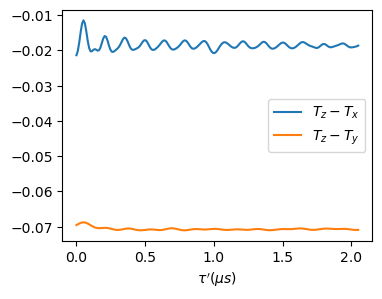

In [511]:
plt.figure(figsize=(4, 3))
plt.plot(tau, sig_ave_xz)
plt.plot(tau, sig_ave_yz)
plt.legend(['$T_z-T_x$', '$T_z-T_y$'])
plt.xlabel('$\\tau\' (\\mu s)$')

In [508]:

N_tau=201

tau_eyfp_1, tau_eyfp_2 = 0.05, 2.00
pi_pulse_xz=0.0115
pi_pulse_yz=0.014

#@njit
def Target_function(tau_exp, target_sig_xz, target_sig_yz, d, theta_12, phi_12):
    Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation_numba(B0, D0, E0, d, Omega1, phi_01, theta_01, chi_01, theta_12, phi_12)
    #samples = np.random.choice(np.arange(N_tau),  size=30, replace=False)#Choose "size" different random data points for fitting each time to avoid trapping local minimum
    sig_p, sig_m=DEER_4_pulse_numba_samples(Rabi_freq_xz, pi_pulse_xz, Omega1, deltaxz, Dss_zx, tau_eyfp_1, tau_eyfp_2, tau_exp, nz, nx)
    sig_ave_xz=(sig_p+ sig_m)/2
    sig_sim_xz=(sig_ave_xz-np.min(sig_ave_xz))/(np.max(sig_ave_xz)-np.min(sig_ave_xz))
    #sig_target_xz_samples=target_sig_xz
    Inner_prod_xz=np.dot(sig_sim_xz,target_sig_xz)/np.sqrt(np.sum(sig_sim_xz**2)*np.sum(target_sig_xz**2))
    sig_p, sig_m=DEER_4_pulse_numba_samples(Rabi_freq_yz, pi_pulse_yz, Omega1, deltayz, Dss_zy, tau_eyfp_1, tau_eyfp_2, tau_exp, nz, ny)
    sig_ave_yz=(sig_p+ sig_m)/2
    sig_sim_yz=(sig_ave_yz-np.min(sig_ave_yz))/(np.max(sig_ave_yz)-np.min(sig_ave_yz))
    #sig_target_yz_samples=target_sig_yz
    #var_yz=np.var(sig_sim_yz-sig_target_yz_samples)
    Inner_prod_yz=np.dot(sig_sim_yz,target_sig_yz)/np.sqrt(np.sum(sig_sim_yz**2)*np.sum(target_sig_yz**2))
    return ((1-Inner_prod_yz)+(1-Inner_prod_xz))/2



def Newton_Raphson_Opimization(tau_exp:float, target_sig_xz: float, target_sig_yz:float, Parameter_to_change:str, Condition_met: bool,  **Parameter_dict:dict):
    t0=time.time()
    Parameter_new=Parameter_dict.copy()
    delta=np.random.uniform(0.001, 0.01)
    accuracy = 1e-6
    Parameter_new[Parameter_to_change]=Parameter_dict[Parameter_to_change]-delta

    F0=Target_function(tau_exp, target_sig_xz, target_sig_yz, **Parameter_dict)
    Fm=Target_function(tau_exp, target_sig_xz, target_sig_yz, **Parameter_new)

    Parameter_new[Parameter_to_change]=Parameter_dict[Parameter_to_change]+delta
    Fp=Target_function(tau_exp, target_sig_xz, target_sig_yz, **Parameter_new)

    Nabla = (Fp-Fm)/(2*delta)
    Laplacian = (Fp+Fm-2*F0)/(delta**2)


    if np.abs(Laplacian) <1e-6:
        Laplacian=1.0 #Avoid gradient explosion

    
    if np.abs(Nabla/Laplacian) > accuracy:
        Stop_fitting = False
        Parameter_new.update({Parameter_to_change:Parameter_dict[Parameter_to_change] - Nabla/Laplacian})
        F_new=Target_function(tau_exp, target_sig_xz, target_sig_yz, **Parameter_new)
        if F_new<F0: 
            Parameter_dict[Parameter_to_change] = Parameter_new[Parameter_to_change]
            #print(Parameter_to_change, Parameter_dict[Parameter_to_change], F_new, time.time()-t0 )
        else:
            Condition_met = True
    
    
    if Parameter_to_change == 'theta_12':
        Parameter_dict['theta_12']=Parameter_dict['theta_12'] % np.pi

    if Parameter_to_change == 'phi_12':
        Parameter_dict['phi_12']=Parameter_dict['phi_12'] % (2*np.pi)

    if Parameter_to_change == 'd':
        if Parameter_dict['d']<1.5 or Parameter_dict['d']>5:
            Parameter_dict['d']=np.random.rand()*3.5+1.5 #Set the range of the distance fitting
        
    Condition_met = Condition_met and Stop_fitting
    return Condition_met, Parameter_dict






In [500]:
N_mol_fit = 10001 #Total molecule number
phi_01_fit, theta_01_fit, chi_01_fit=Generate_molecule_set(N_mol_fit)

d = 2 # distance, unit: nm
D0 = 2.356 #GHz
E0 = 0.458 #GHz
B0 = 0.03 # T
Omega1=2*np.pi*50 


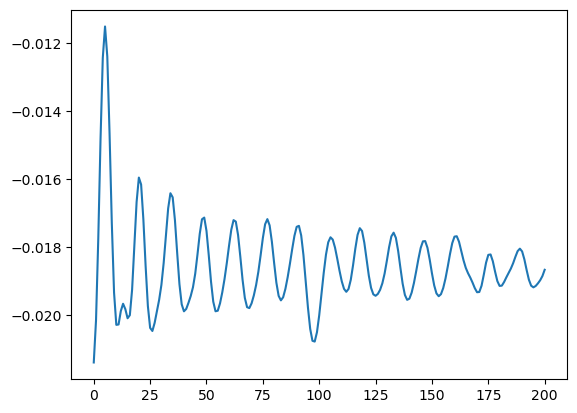

In [512]:
plt.plot(sig_ave_xz)

In [513]:
time0=time.time()
Initial_guess={'d': 2.5, 'theta_12': np.pi/5, 'phi_12': np.pi/7}
accuracy=1e-4
Condition_met=False
F0=Target_function(tau, sig_ave_xz_normed, sig_ave_yz_normed, **Initial_guess)
F0min = F0
Parameter_dict_min = Initial_guess.copy() #Comment out this line for interrupting the while loop without overwritting the parameters
Parameter_dict = Initial_guess.copy()     #Comment out this line for interrupting the while loop without overwritting the parameters
while not(Condition_met) or F0min>accuracy:
    samples = np.random.choice(np.arange(N_tau),  size=10, replace=False)#Choose a batch of random samples for data fitting of each single run
    Condition_met, Parameter_dict = Newton_Raphson_Opimization(tau[samples], sig_ave_xz_normed[samples], sig_ave_yz_normed[samples], 'd', Condition_met, **Parameter_dict)
    Condition_met, Parameter_dict = Newton_Raphson_Opimization(tau[samples], sig_ave_xz_normed[samples], sig_ave_yz_normed[samples], 'theta_12', Condition_met, **Parameter_dict)
    Condition_met, Parameter_dict = Newton_Raphson_Opimization(tau[samples], sig_ave_xz_normed[samples], sig_ave_yz_normed[samples], 'phi_12', Condition_met, **Parameter_dict)
    F0=Target_function(tau, sig_ave_xz_normed, sig_ave_yz_normed, **Parameter_dict)
    if F0<F0min:
        Parameter_dict_min=Parameter_dict.copy()
        F0min=F0
        print(F0min, Parameter_dict_min, time.time()-time0)


0.11061352304451971 {'d': np.float64(2.499826939041335), 'theta_12': np.float64(0.6432166859719164), 'phi_12': np.float64(0.4646576863865497)} 45.26560044288635
0.11019607080589505 {'d': np.float64(2.4498575847998443), 'theta_12': np.float64(0.6354177899419812), 'phi_12': np.float64(0.4537248946955328)} 59.20301818847656
0.10879427550564247 {'d': np.float64(2.4498575847998443), 'theta_12': np.float64(0.6348283494800128), 'phi_12': np.float64(0.4835631497879789)} 66.17818546295166
0.10671217815111061 {'d': np.float64(2.4664946373183647), 'theta_12': np.float64(0.6466040387753378), 'phi_12': np.float64(0.5109543448329317)} 80.27249002456665
0.10194765629962144 {'d': np.float64(2.456478353499377), 'theta_12': np.float64(0.6461965605540692), 'phi_12': np.float64(0.5075632977649224)} 87.40231490135193
0.10173836829778637 {'d': np.float64(2.442803000466835), 'theta_12': np.float64(0.6461965605540692), 'phi_12': np.float64(0.5075632977649224)} 101.67671704292297
0.10156396969055309 {'d': np.f

SystemError: CPUDispatcher(<function DEER_4_pulse_numba_samples at 0x0000022D9D3185E0>) returned a result with an exception set

In [390]:
F0

np.float64(0.04443374139031168)

In [413]:
np.mean(Txz)

np.complex128(3.27904165324499+0j)

In [414]:
np.mean(Tyz)

np.complex128(2.009695703239328+0j)

## DEERLab fitting for single molecules

In [441]:
N_mol = 10000 #Total molecule number
phi_01, theta_01, chi_01=Generate_molecule_set(N_mol)

V = 52.16/1000 # Hss coefficient, unit: 2pi*GHz*nm^3
d = 2 # distance, unit: nm
D0 = 2.356 #GHz
E0 = 0.458 #GHz
B0 = 0.03 # T
Txzmean = 3.2790416532
Tyzmean = 2.009695703
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note

Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation_numba(B0, D0, E0, d, Omega1, phi_01, theta_01, chi_01, 0.0, 0.0)
tau, sig_p_xz, sig_m_xz, sig_c=DEER_4_pulse_numba(Rabi_freq_xz, 0.0115, Omega1, (Txz-Txzmean)*1000*2*np.pi, Dss_zx, tau_eyfp_1, tau_eyfp_2, N_tau, nz, nx)
sig_ave_xz=(sig_p_xz+ sig_m_xz)/2
tau, sig_p_yz, sig_m_yz, sig_c=DEER_4_pulse_numba(Rabi_freq_yz, 0.014, Omega1, (Tyz-Tyzmean)*1000*2*np.pi, Dss_zy, tau_eyfp_1, tau_eyfp_2, N_tau, nz, ny)
sig_ave_yz=(sig_p_yz+ sig_m_yz)/2

In [442]:
print(np.array([phi_01, theta_01, chi_01]).T/np.pi*180)

[[203.32808892  92.26546821  44.23798743]
 [ 93.63041763 116.21372912 155.60021662]
 [321.00392869  97.59438897 293.50801611]
 ...
 [328.39891048  62.16540688  19.341036  ]
 [121.02992488  87.22257493 223.35708644]
 [  5.53411716 120.77828229  97.93071738]]


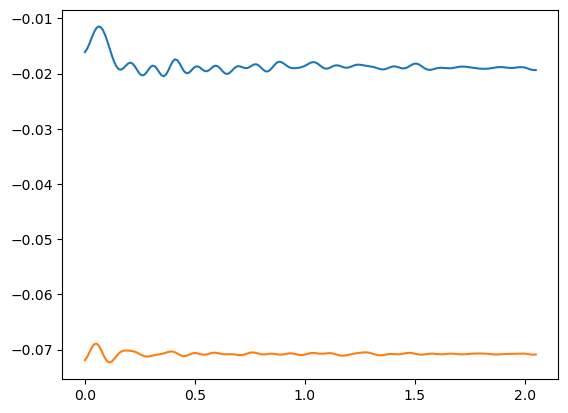

In [443]:
plt.plot(tau, sig_ave_xz)
plt.plot(tau, sig_ave_yz)

## Two dimension 4 pulse DEER simulation

In [ ]:
phi_01, theta_01, chi_01=Generate_molecule_set_equidistributed(10000, 30)
theta_12 = 0.0 # Polar angle theta_12 is usually a fixed value for dumbbell model
phi_12 = 0.0 # Set phi_12=0 for simplicity; but generally it is not)


V = 52.16/1000 # Hss coefficient, unit: 2pi*GHz*nm^3
d=3 # distance, unit: nm
D0 = 2.356 #GHz
E0 = 0.458 #GHz
#D0 = 0.0 #GHz
#E0 = 0.0 #GHz
B0 = 0.03 # T
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note

Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation_numba(B0, D0, E0, d, Omega1, phi_01, theta_01, chi_01, theta_12, phi_12)

In [723]:
t_pi=0.016
freq_list=np.linspace(np.min(Txz), np.max(Txz), 50)
N_tau=201
tau_eyfp_1, tau_eyfp_2 = 0.05, 2.00
sig_p_all = np.zeros((len(freq_list), N_tau))
sig_m_all = np.zeros((len(freq_list), N_tau))
sig_c_all = np.zeros((len(freq_list), N_tau))
sig_p = np.zeros((N_tau)) #coupling to spin up
sig_m = np.zeros((N_tau)) #coupling to spin down
sig_c = np.zeros((N_tau)) #no coupling, for comparison only
sig_ave_xz = np.zeros((N_tau)) #average signal

for i in range(len(freq_list)):
    delta_xz_off_resonance = deltaxz+(np.mean(Txz)-freq_list[i])*1000*2*np.pi #Tz-Tx transition detuning
    tau, sig_p, sig_m, sig_c=DEER_4_pulse_numba(Rabi_freq_xz, 0.016, Omega1, delta_xz_off_resonance, Dss_zx, tau_eyfp_1, tau_eyfp_2, N_tau, nz, nx)
    sig_p_all[i] = sig_p
    sig_m_all[i] = sig_m
    sig_c_all[i] = sig_c
sig_ave_xz = (sig_p_all + sig_m_all) / 2
#sig_ave_xz = (sig_ave_xz - np.min(sig_ave_xz)) / (np.max(sig_ave_xz) - np.min(sig_ave_xz))

c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\matplotlib\transforms.py:2875: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


Text(0.5, 1.0, '2D 4-pulse DEER Signal of $T_z-T_x$ transition')

c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\matplotlib\transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


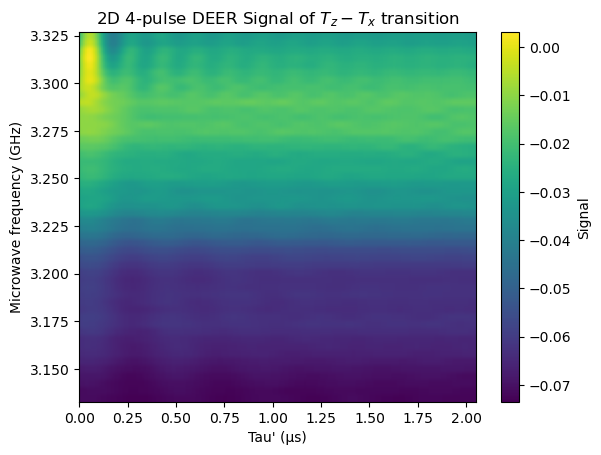

In [727]:
plt.imshow(sig_ave_xz[::-1, :], aspect='auto', extent=[tau[0], tau[-1], -freq_pump[-1]+np.mean(Txz), -freq_pump[0]+np.mean(Txz)])
plt.colorbar(label='Signal')
plt.xlabel('Tau\' (µs)')
plt.ylabel('Microwave frequency (GHz)')
plt.title('2D 4-pulse DEER Signal of $T_z-T_x$ transition')

In [705]:
sig_ave_xz-np.mean(sig_ave_xz, axis=1, keepdims=True)[0]

array([[ 0.00019429,  0.00047431,  0.000739  , ..., -0.00029565,
        -0.00033347, -0.00035221],
       [ 0.00104875,  0.00128853,  0.0015061 , ...,  0.00079213,
         0.000895  ,  0.00098139],
       [ 0.00233035,  0.00270063,  0.0029606 , ...,  0.00158623,
         0.001478  ,  0.00136588],
       ...,
       [ 0.03938218,  0.04610431,  0.05528764, ...,  0.04620692,
         0.04608155,  0.04578698],
       [ 0.0354359 ,  0.04190977,  0.05123701, ...,  0.04444167,
         0.04450341,  0.04439787],
       [ 0.03298661,  0.03950678,  0.04872763, ...,  0.0429178 ,
         0.04316128,  0.04321864]], shape=(50, 201))

Text(0.5, 1.0, '2D 4-pulse DEER Signal of $T_z-T_x$ transition')

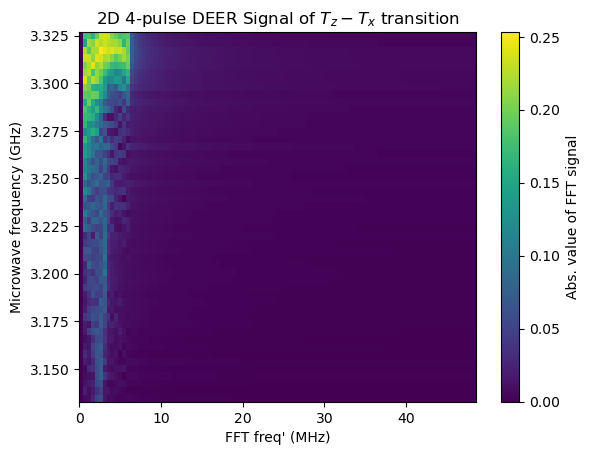

In [728]:
fft_freq=np.fft.rfftfreq(len(tau), tau[1]-tau[0])
sig_fft = np.fft.rfft(sig_ave_xz-np.mean(sig_ave_xz, axis=1, keepdims=True), axis=1)
plt.imshow(np.abs(sig_fft[::-1,:]), aspect='auto', extent=[fft_freq[0], fft_freq[-1], freq_list[0], freq_list[-1]])
plt.colorbar(label='Abs. value of FFT signal')
plt.xlabel('FFT freq\' (MHz)')
plt.ylabel('Microwave frequency (GHz)')
plt.title('2D 4-pulse DEER Signal of $T_z-T_x$ transition')

## DEER simulation for fitting distance under different B fields

In [244]:
@njit
def fibonacci_sphere(n):
    indices = np.arange(0, n)
    phi = np.pi * (3. - np.sqrt(5))  # golden angle
    chi01 = (phi * indices)%(2 * np.pi)  # azimuthal angle
    z = 1 - (2 * indices) / (n - 1)
    theta01=np.arccos(z)
    return np.stack((theta01, chi01), axis=1) 

@njit
def Generate_molecule_set_Fibonacci_sphere(Number_of_B_orientation:int, number_of_Mol_orientations:int):
    phi_01 = np.linspace(0, np.pi, number_of_Mol_orientations) # The first Euler angle
    point_set = fibonacci_sphere(Number_of_B_orientation)  # shape: (N_point_set, 2)
    Actual_number_of_B_orientation = len(point_set) #Sometimes the round-off error will cause the number of points to be less than the number of molecules
    theta_01 = point_set[:, 0]
    chi_01 = point_set[:, 1]
    # Flatten to 1D arrays
    phi_01_all = repeat_1d(phi_01, Actual_number_of_B_orientation)
    theta_01_all = tile_1d(theta_01, number_of_Mol_orientations)
    chi_01_all = tile_1d(chi_01, number_of_Mol_orientations)
    
    return phi_01_all, theta_01_all, chi_01_all

In [245]:
#phi_01, theta_01, chi_01=Generate_molecule_set_equidistributed(10000, 30)
phi_01, theta_01, chi_01=Generate_molecule_set_Fibonacci_sphere(10000, 30)


theta_12 = 0.0 # Polar angle theta_12 is usually a fixed value for dumbbell model
phi_12 = 0.0 # Set phi_12=0 for simplicity; but generally it is not)

V = 52.16/1000 # Hss coefficient, unit: 2pi*GHz*nm^3
d=2.0 # distance, unit: nm
D0 = 2.356 #GHz
E0 = 0.458 #GHz
#D0 = 0.0 #GHz
#E0 = 0.0 #GHz


In [ ]:
I2 = np.eye(2, dtype=np.complex128)

sx = np.array([[0, 1], [1, 0]], dtype=np.complex128)
sy = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
sz = np.array([[1, 0], [0, -1]], dtype=np.complex128)

@njit
def expm_hamiltonian_numba(H, t):
    a0 = 0.5 * (H[0, 0] + H[1, 1]).real
    ax = 0.5 * (H[0, 1] + H[1, 0]).real
    ay = -0.5 * (H[0, 1] - H[1, 0]).imag
    az = 0.5 * (H[0, 0] - H[1, 1]).real
    a_norm = np.sqrt(ax**2 + ay**2 + az**2)

    # Compute phase manually
    phase_real = np.cos(a0 * t)
    phase_imag = -np.sin(a0 * t)

    U = np.zeros((2, 2), dtype=np.complex128)
    
    if a_norm > 1e-12:
        nx, ny, nz = ax / a_norm, ay / a_norm, az / a_norm
        cos_term = np.cos(a_norm * t)
        sin_term = np.sin(a_norm * t)

        n_dot_sigma = nx * sx + ny * sy + nz * sz
        for i in range(2):
            for j in range(2):
                val = cos_term * I2[i, j] - 1j * sin_term * n_dot_sigma[i, j]
                # Apply complex phase: phase = phase_real + i * phase_imag
                U[i, j] = phase_real * val - 1j * phase_imag * val
    else:
        for i in range(2):
            for j in range(2):
                U[i, j] = phase_real * I2[i, j] - 1j * phase_imag * I2[i, j]

    return U

@njit
def compute_rabi_signal(ne, ng, Rabi_freq, delta, T, f_peak, time_seq):
    sig = np.zeros(len(time_seq), dtype=np.complex128)

    for n_i in range(len(ne)):
        rho0 = np.array([[ne[n_i], 0.0], [0.0, ng[n_i]]], dtype=np.complex128)
        delta_i = delta[n_i] + (np.mean(T) - f_peak) * 1000 * 2 * np.pi
        H_mol = Eff_H(Rabi_freq[n_i], delta_i)

        for t_i in range(len(time_seq)):
            U = expm_hamiltonian_numba(H_mol, time_seq[t_i])
            Udag = U.conj().T
            rho_i = matmul_numba(matmul_numba(U, rho0), Udag)
            temp = matmul_numba(rho_i, sz)
            sig[t_i] += temp[0, 0] + temp[1, 1]  # Trace manually


    return sig/len(ne)



In [10]:
#2D DEER signal of Tz-Tx transition
B_list=np.linspace(0.01, 0.3, 30)
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note
rabi_tau_list=np.linspace(0, 0.3, 301)
N_tau=101
tau_eyfp_1, tau_eyfp_2 = 0.05, 2.00
Total_result_DEER = np.zeros((len(B_list), N_tau), dtype=np.complex128)
Total_result_rabi = np.zeros((len(B_list), 301), dtype=np.complex128)
All_spectra = np.zeros((len(B_list), 1000), dtype=np.complex128)
All_frequencies = np.zeros((len(B_list), 1000), dtype=np.complex128)

for i in range(len(B_list)):
    B_i = B_list[i] # 

    Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation_numba(B_i, D0, E0, d, Omega1, phi_01, theta_01, chi_01, theta_12, phi_12)
    gamma_linewidth = 0.01 #GHz, linewidth
    f_axis = np.linspace(np.min(Txz)-gamma_linewidth*5, np.max(Txz)+gamma_linewidth*5, 1000)
    All_frequencies[i] = f_axis #Store the frequency axis for each spectrum
    I_lines = np.ones(len(Txz))/(len(Txz)) #Intensity of each line

    # Simulate spectrum
    spectrum = convolve_spectrum_numba(Txz, I_lines, f_axis, gamma_linewidth)

    All_spectra[i] = spectrum
    f_at_sig_max = f_axis[np.argmax(spectrum)] #Microwave pumping frequency at the maximum signal

    #Rabi simulation to obtain the pi pulse duration
    Total_result_rabi[i] = compute_rabi_signal(nx, nz, Rabi_freq_xz, deltaxz, Txz, f_at_sig_max, rabi_tau_list)
    pi_pulse_duration = rabi_tau_list[np.argmin(Total_result_rabi[i])] #Duration of pi pulse

    #Simulate DEER signal
    detuning_xz = deltaxz + (np.mean(Txz) - f_at_sig_max) * 1000 * 2 * np.pi #Tz-Tx transition detuning
    tau, sig_p_xz, sig_m_xz, sig_c=DEER_4_pulse_numba(Rabi_freq_xz, pi_pulse_duration, Omega1, detuning_xz, Dss_zx, tau_eyfp_1, tau_eyfp_2, N_tau, nz, nx)
    Total_result_DEER[i] = (sig_p_xz + sig_m_xz) / 2
    #Total_result[i] = (Total_result[i] - np.min(Total_result[i])) / (np.max(Total_result[i]) - np.min(Total_result[i])) #Normalization

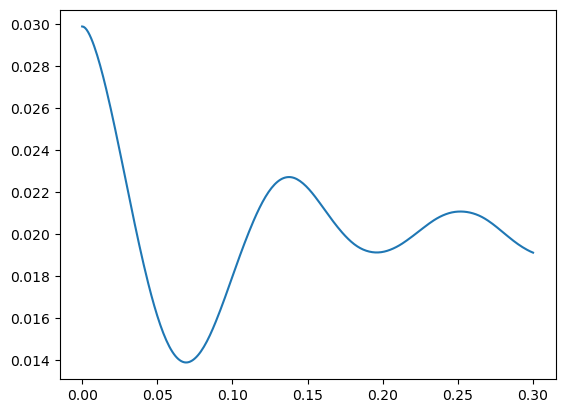

In [243]:
#plt.plot(f_axis, spectrum)
plt.plot(tau_list, np.real(Rabi_signal))
#plt.plot(tau, (sig_p_xz+sig_m_xz)/2)

In [16]:
f_axis[np.argmax(spectrum)]

np.complex128(3.323991630732043+0j)

In [11]:
#simulation_configuration=[phi_01, theta_01, chi_01,Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz]
import pickle
with open("2Dscans_B_vs_Rabi_and_DEER\\ZX_Four_Pulse_DEER_at_different_B_field_0_to_300mT_tau_1(50ns)_tau_2(2000ns).pkl", "wb") as f:
    pickle.dump([tau, Total_result_DEER.real], f)

with open("2Dscans_B_vs_Rabi_and_DEER\\ZX_Rabi_at_different_B_field_0_to_300mT_tau_1(50ns)_tau_2(2000ns).pkl", "wb") as f:
    pickle.dump([rabi_tau_list, Total_result_rabi.real], f)

with open("2Dscans_B_vs_Rabi_and_DEER\\ZX_Spectra_at_different_B_field_0_to_300mT_tau_1(50ns)_tau_2(2000ns).pkl", "wb") as f:
    pickle.dump([All_frequencies, All_spectra.real], f)

Text(0.5, 1.0, '2D 4-pulse DEER Signal of $T_z-T_x$ transition')

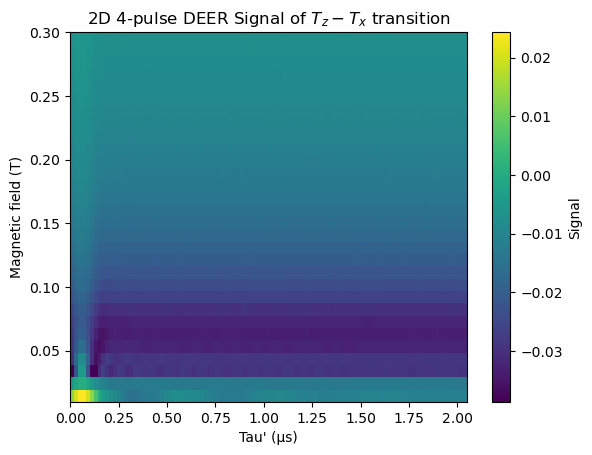

In [12]:
plt.imshow(Total_result_DEER.real[::-1,:], aspect='auto', extent=[tau[0], tau[-1], B_list[0], B_list[-1]])
plt.colorbar(label='Signal')
plt.xlabel('Tau\' (µs)')
plt.ylabel('Magnetic field (T)')
plt.title('2D 4-pulse DEER Signal of $T_z-T_x$ transition')

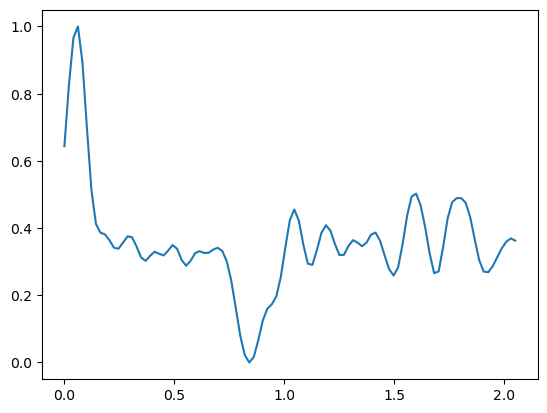

In [138]:
plt.plot(tau, Total_result[20])

In [ ]:
import pickle
with open("DEERLab_simulation_Tz-Ty_0422_20-by-20\DEERLab_fitresult_grid_20-by-20.pkl", "rb") as f:
    loaded_result = pickle.load(f) #Read the saved file and do not interrupt the type of the object

print(loaded_result)

In [130]:
import deerlab as dl
results_B = ['']*len(B_list)
r = np.arange(1.5,5,0.02) # nm
# Construct the model
Vmodel = dl.dipolarmodel(tau,r, experiment = dl.ex_4pdeer(tau_eyfp_1,tau_eyfp_2, pathways=[1,2, 3,4]))
# Fit the model to the data
#for i in range(len(B_list)):
#    Vexp = Total_result[i]
#    Vfit = dl.fit(Vmodel, Vexp)
#    results[i] = Vfit

from concurrent.futures import ThreadPoolExecutor


def worker(i):
    Vexp = Total_result[i]
    Vfit = dl.fit(Vmodel, Vexp)
    return i, Vfit
# Use ThreadPoolExecutor to parallelize the fitting process

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(worker, i) for i in range(len(B_list))]
    for future in futures:
        i, Vfit = future.result()
        results_B[i] = Vfit

B field: 0.3


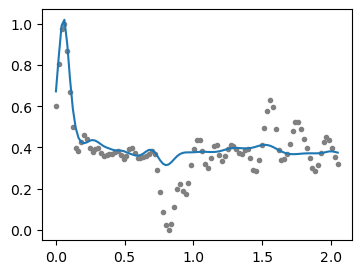

In [143]:
#Plot the fitting results
n=29
plt.figure(figsize=(4, 3))
plt.plot(tau, Total_result[n], '.', color='grey', label='Simulation data')
plt.plot(tau, results[n].model, label='Fitting result')
print('B field:', B_list[n])

In [132]:
def distance_from_fit(results):
    distance = np.zeros(len(results))
    Variance = np.zeros(len(results))
    for i in range(len(results)):
        P_i= results[i].P
        r_ave=0.0
        r_var=0.0
        dr=r[1]-r[0]
        for j in range(len(r)):
            r_ave += P_i[j]*r[j]*dr
        distance[i] = r_ave
        for j in range(len(r)):
            r_var += P_i[j]*(r[j]-distance[i])**2*dr
        Variance[i] = r_var
    return distance, Variance
distance_d, Variance_d = distance_from_fit(results)

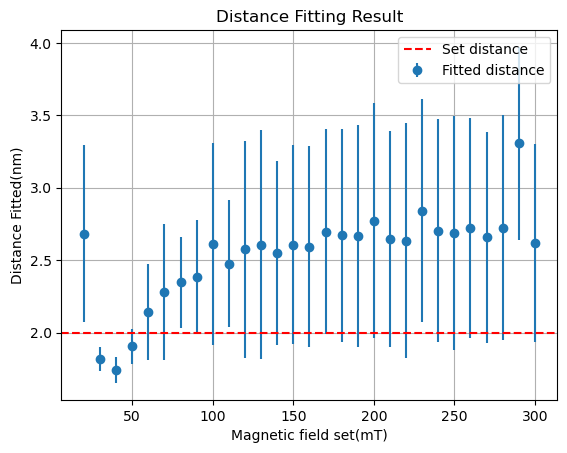

In [142]:
plt.errorbar(np.array(B_list[1::])*1000, distance_d[1::], yerr=np.sqrt(Variance_d[1::]), fmt='o', label='Fitted distance')
#plot an horizontal line at 2.0 nm
plt.axhline(y=2.0, color='r', linestyle='--', label='Set distance')
plt.xlabel('Magnetic field set(mT)')
plt.ylabel('Distance Fitted(nm)')
plt.legend()
plt.title('Distance Fitting Result')
plt.grid()
plt.show()

## Measuring distance with Tz-Tx transition by fitting with DEERlab

In [ ]:
d_list=np.linspace(2, 5, 30)
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note
tau_list=np.linspace(0, 0.3, 301) #Rabi pulse duration
N_tau=101
tau_eyfp_1, tau_eyfp_2 = 0.05, 2.00
Total_result = np.zeros((len(d_list), N_tau), dtype=np.complex128)
B0=0.03 # T


for i in range(len(d_list)):
    d_i = d_list[i] # 

    Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation_numba(B0, D0, E0, d_i, Omega1, phi_01, theta_01, chi_01, theta_12, phi_12)
    gamma_linewidth = 0.01 #GHz, linewidth
    f_axis = np.linspace(np.min(Txz)-gamma_linewidth*3, np.max(Txz)+gamma_linewidth*3, 1000)
    I_lines = np.ones(len(Txz))/(len(Txz)) #Intensity of each line

    # Simulate spectrum
    spectrum = convolve_spectrum_numba(Txz, I_lines, f_axis, gamma_linewidth)
    f_at_sig_max = f_axis[np.argmax(spectrum)] #Microwave pumping frequency at the maximum signal

    #Rabi simulation to obtain the pi pulse duration
    Rabi_signal = compute_rabi_signal(nx, nz, Rabi_freq_xz, deltaxz, Txz, f_at_sig_max, tau_list)
    pi_pulse_duration = tau_list[np.argmin(Rabi_signal)] #Duration of pi pulse

    #Simulate DEER signal
    detuning_xz = deltaxz + (np.mean(Txz) - f_at_sig_max) * 1000 * 2 * np.pi #Tz-Tx transition detuning
    tau, sig_p_xz, sig_m_xz, sig_c=DEER_4_pulse_numba(Rabi_freq_xz, pi_pulse_duration, Omega1, detuning_xz, Dss_zx, tau_eyfp_1, tau_eyfp_2, N_tau, nz, nx)
    Total_result[i] = (sig_p_xz + sig_m_xz) / 2
    Total_result[i] = (Total_result[i] - np.min(Total_result[i])) / (np.max(Total_result[i]) - np.min(Total_result[i])) #Normalization

In [126]:
import pickle
with open("Four_Pulse_DEER_for_different_distance_2_to_5nm(ArraySizeIs30)_tau_1(50ns)_tau_2(2000ns)_2.pkl", "wb") as f:
    pickle.dump(Total_result.real, f)

In [118]:
import deerlab as dl
results_d = ['']*len(d_list)
r = np.arange(1.5,5,0.02) # nm
# Construct the model
Vmodel = dl.dipolarmodel(tau,r, experiment = dl.ex_4pdeer(tau_eyfp_1,tau_eyfp_2, pathways=[1,2, 3,4]))
# Fit the model to the data
#for i in range(len(B_list)):
#    Vexp = Total_result[i]
#    Vfit = dl.fit(Vmodel, Vexp)
#    results[i] = Vfit

#Use ThreadPoolExecutor for parallel processing
from concurrent.futures import ThreadPoolExecutor

def worker(i):
    Vexp = Total_result[i]
    Vfit = dl.fit(Vmodel, Vexp)
    return i, Vfit

#results_d = np.zeros_like(Total_result)  # Or whatever shape fits Vfit

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(worker, i) for i in range(len(d_list))]
    for future in futures:
        i, Vfit = future.result()
        results_d[i] = Vfit    

KeyboardInterrupt: 

Distance set: 2.310344827586207


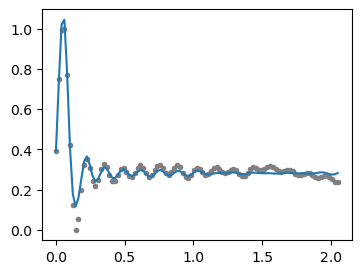

In [113]:
n=3
plt.figure(figsize=(4, 3))
plt.plot(tau, Total_result[n], '.', color='grey', label='Simulation data')
plt.plot(tau, results_d[n].model, label='Fitting result')
print('Distance set:', d_list[n])

In [85]:

def distance_from_fit(results):
    distance = np.zeros(len(results))
    Variance = np.zeros(len(results))
    for i in range(len(results)):
        P_i= results[i].P
        r_ave=0.0
        r_var=0.0
        dr=r[1]-r[0]
        for j in range(len(r)):
            r_ave += P_i[j]*r[j]*dr
        distance[i] = r_ave
        for j in range(len(r)):
            r_var += P_i[j]*(r[j]-distance[i])**2*dr
        Variance[i] = r_var
    return distance, Variance
distance_d, Variance_d = distance_from_fit(results_d)

In [108]:
#Fit the distance fitted results to the set distance with linear regression
x = np.array(d_list)[0:-2]
y = distance_d[0:-2]
sigma = np.sqrt(Variance_d[0:-2])  # standard deviations

# Weighted least squares design
w = 1 / sigma**2
W = np.diag(w)
X = np.vstack((x, np.ones_like(x))).T  # Design matrix

# Solve for best-fit coefficients: [a, b]
XTWX = X.T @ W @ X
XTWy = X.T @ W @ y
coeffs = np.linalg.solve(XTWX, XTWy)
a, b = coeffs

# Model prediction for full x (or truncated if you prefer)
x_full = np.array(d_list)
y_model = a * x_full + b

# Chi-squared over the same range as fit
y_fit = a * x + b
chi_squared = np.sum(((y - y_fit) / sigma) ** 2)

# Degrees of freedom
dof = len(x) - 2
reduced_chi_squared = chi_squared / dof

# Residual variance estimate
s_sq = chi_squared / dof

# Covariance matrix of [a, b]
cov = s_sq * np.linalg.inv(XTWX)
err_a, err_b = np.sqrt(np.diag(cov))

# Output
print(f"Slope a = {a:.4f} ± {err_a:.4f}")
print(f"Intercept b = {b:.4f} ± {err_b:.4f}")
print(f"Chi-squared: {chi_squared:.2f}")
print(f"Reduced chi-squared: {reduced_chi_squared:.2f}")


Slope a = 0.8604 ± 0.0035
Intercept b = 0.0289 ± 0.0110
Chi-squared: 0.32
Reduced chi-squared: 0.01


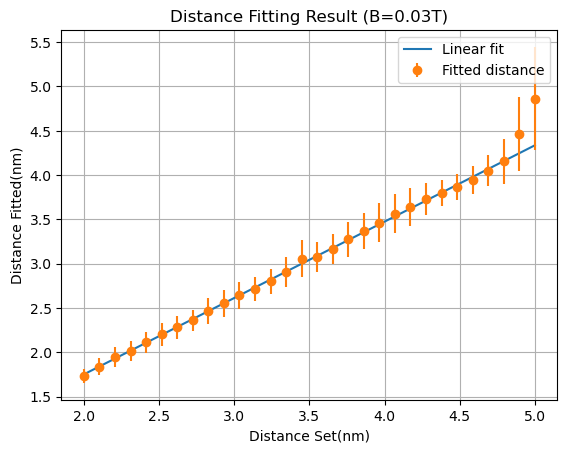

In [107]:
#plt.plot(np.array(d_list), distance_d)
#Fit the distance data
plt.plot(np.array(d_list) , a * np.array(d_list) + b, label='Linear fit')
plt.errorbar(np.array(d_list), distance_d, yerr=np.sqrt(Variance_d), fmt='o', label='Fitted distance')
plt.xlabel('Distance Set(nm)')
plt.ylabel('Distance Fitted(nm)')
plt.legend()
plt.title('Distance Fitting Result (B=0.03T)')
plt.grid()

plt.show()

In [116]:
#Save the fitting results
import pickle
fit_d_results = [Total_result, results_d, a, err_a, b, err_b, chi_squared, reduced_chi_squared, d_list, distance_d, Variance_d]
with open("DEERLab_simulation_0513_distance_fitting_results_at_30mT.pkl", "wb") as f:
    pickle.dump(fit_d_results, f)

## Tz-Ty 2D DEER

In [13]:
#2D DEER signal of Tz-Ty transition
B_list=np.linspace(0.01, 0.3, 30)
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note
tau_list=np.linspace(0, 0.3, 301)
N_tau=101
tau_eyfp_1, tau_eyfp_2 = 0.05, 2.00
Total_result = np.zeros((len(B_list), N_tau), dtype=np.complex128)
Total_result_DEER = np.zeros((len(B_list), N_tau), dtype=np.complex128)
Total_result_rabi = np.zeros((len(B_list), 301), dtype=np.complex128)
All_spectra = np.zeros((len(B_list), 1000), dtype=np.complex128)
All_frequencies = np.zeros((len(B_list), 1000), dtype=np.complex128)
theta_12, phi_12 = 0.0, 0.0 # Polar angle theta_12 is usually a fixed value for dumbbell model; Set phi_12=0 for simplicity; but generally it is not)

for i in range(len(B_list)):
    B_i = B_list[i] # 

    Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation_numba(B_i, D0, E0, d, Omega1, phi_01, theta_01, chi_01, theta_12, phi_12)
    gamma_linewidth = 0.01 #GHz, linewidth
    f_axis = np.linspace(np.min(Tyz)-gamma_linewidth*5, np.max(Tyz)+gamma_linewidth*5, 1000)
    All_frequencies[i] = f_axis #Store the frequency axis for each spectrum
    I_lines = np.ones(len(Tyz))/(len(Tyz)) #Intensity of each line

    # Simulate spectrum
    spectrum = convolve_spectrum_numba(Tyz, I_lines, f_axis, gamma_linewidth)
    All_spectra[i] = spectrum
    f_at_sig_max = f_axis[np.argmax(spectrum)] #Microwave pumping frequency at the maximum signal

    #Rabi simulation to obtain the pi pulse duration
    Rabi_signal = compute_rabi_signal(ny, nz, Rabi_freq_yz, deltayz, Tyz, f_at_sig_max, tau_list)
    Total_result_rabi[i] = Rabi_signal
    pi_pulse_duration = tau_list[np.argmin(Rabi_signal)] #Duration of pi pulse

    #Simulate DEER signal
    detuning_yz = deltayz + (np.mean(Tyz) - f_at_sig_max) * 1000 * 2 * np.pi #Tz-Tx transition detuning
    tau, sig_p_yz, sig_m_yz, sig_c=DEER_4_pulse_numba(Rabi_freq_yz, pi_pulse_duration, Omega1, detuning_yz, Dss_zy, tau_eyfp_1, tau_eyfp_2, N_tau, nz, ny)
    Total_result_DEER[i] = (sig_p_yz + sig_m_yz) / 2
    #Total_result[i] = (Total_result[i] - np.min(Total_result[i])) / (np.max(Total_result[i]) - np.min(Total_result[i])) #Normalization

In [ ]:
plt.plot(tau, (sig_p_xz+sig_m_xz)/2)

In [14]:

#simulation_configuration=[phi_01, theta_01, chi_01,Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz]
import pickle
with open("2Dscans_B_vs_Rabi_and_DEER\\ZY_Four_Pulse_DEER_at_different_B_field_0_to_300mT_tau_1(50ns)_tau_2(2000ns).pkl", "wb") as f:
    pickle.dump([tau, Total_result_DEER.real], f)

with open("2Dscans_B_vs_Rabi_and_DEER\\ZY_Rabi_at_different_B_field_0_to_300mT_tau_1(50ns)_tau_2(2000ns).pkl", "wb") as f:
    pickle.dump([rabi_tau_list, Total_result_rabi.real], f)

with open("2Dscans_B_vs_Rabi_and_DEER\\ZY_Spectra_at_different_B_field_0_to_300mT_tau_1(50ns)_tau_2(2000ns).pkl", "wb") as f:
    pickle.dump([All_frequencies, All_spectra.real], f)

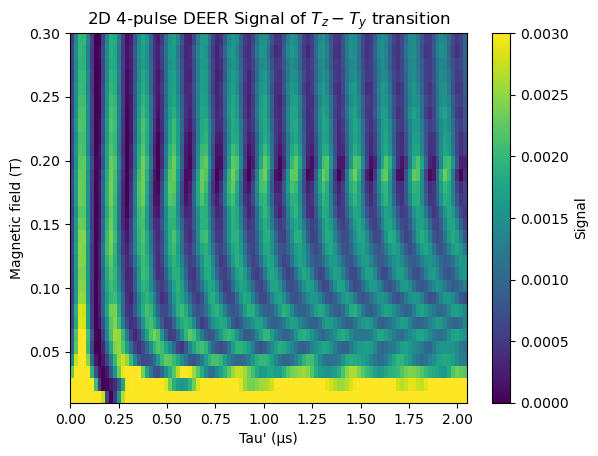

In [19]:
plt.imshow(Total_result_DEER.real[::-1,:]-np.min(Total_result_DEER.real[::-1,:], axis=1, keepdims=True), aspect='auto', extent=[tau[0], tau[-1], B_list[0], B_list[-1]], vmin=0, vmax=0.003)
plt.colorbar(label='Signal')
plt.xlabel('Tau\' (µs)')
plt.ylabel('Magnetic field (T)')
plt.title('2D 4-pulse DEER Signal of $T_z-T_y$ transition')
#plt.imshow(vmin=0, vmax=0.005)
plt.savefig('ZY_2D_DEER_signal.png', dpi=300)

In [16]:
import deerlab as dl
results_B = ['']*len(B_list)
r = np.arange(1.5,5,0.02) # nm
# Construct the model
Vmodel = dl.dipolarmodel(tau,r, experiment = dl.ex_4pdeer(tau_eyfp_1,tau_eyfp_2, pathways=[1,2, 3,4]))
# Fit the model to the data
#for i in range(len(B_list)):
#    Vexp = Total_result[i]
#    Vfit = dl.fit(Vmodel, Vexp)
#    results[i] = Vfit

from concurrent.futures import ThreadPoolExecutor


def worker_normed(i):
    Vexp = Total_result[i]
    Vexp = (Vexp - np.min(Vexp)) / (np.max(Vexp) - np.min(Vexp)) #Normalization
    Vfit = dl.fit(Vmodel, Vexp)
    return i, Vfit
# Use ThreadPoolExecutor to parallelize the fitting process

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(worker_normed, i) for i in range(len(B_list))]
    for future in futures:
        i, Vfit = future.result()
        results_B[i] = Vfit

c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\compt\AppData\Local\Temp\ipykernel_28944\1284575882.py:17: RuntimeWarning: invalid value encountered in divide
  Vexp = (Vexp - np.min(Vexp)) / (np.max(Vexp) - np.min(Vexp)) #Normalization
C:\Users\compt\AppData\Local\Temp\ipykernel_28944\1284575882.py:17: RuntimeWarning: invalid value encountered in divide
  Vexp = (Vexp - np.min(Vexp)) / (np.max(Vexp) - np.min(Vexp)) #Normalization
C:\Users\compt\AppData\Local\Temp\ipykernel_28944\1284575882.py:17: RuntimeWarning: invalid value encountered in divide
  Vexp = (Vexp - np.min(Vexp)) / (np.max(Vexp) - np.min(Vexp)) #Normalization
C:\Users\compt\AppData\Local\Temp\ipykernel_28944\1284575882.py:17: RuntimeWarning: invalid value encountered in divide
  Vexp = (Vexp - np.min(V

ValueError: Residuals are not finite in the initial point.

In [ ]:
def distance_from_fit(results):
    distance = np.zeros(len(results))
    Variance = np.zeros(len(results))
    for i in range(len(results)):
        P_i= results[i].P
        r_ave=0.0
        r_var=0.0
        dr=r[1]-r[0]
        for j in range(len(r)):
            r_ave += P_i[j]*r[j]*dr
        distance[i] = r_ave
        for j in range(len(r)):
            r_var += P_i[j]*(r[j]-distance[i])**2*dr
        Variance[i] = r_var
    return distance, Variance
distance_d, Variance_d = distance_from_fit(results_B)

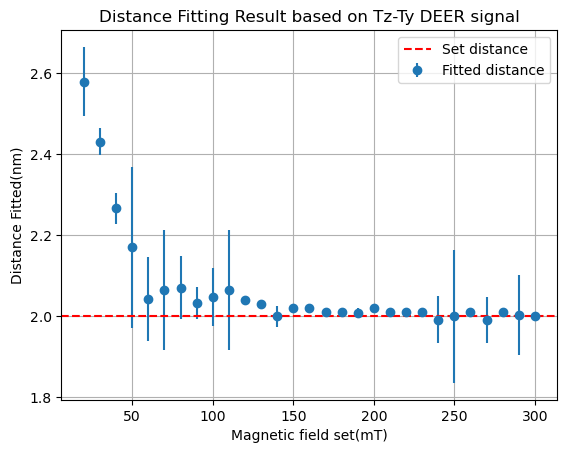

In [ ]:
plt.errorbar(np.array(B_list[1::])*1000, distance_d[1::], yerr=np.sqrt(Variance_d[1::]), fmt='o', label='Fitted distance')
#plot an horizontal line at 2.0 nm
plt.axhline(y=2.0, color='r', linestyle='--', label='Set distance')
plt.xlabel('Magnetic field set(mT)')
plt.ylabel('Distance Fitted(nm)')
plt.legend()
plt.title('Distance Fitting Result based on Tz-Ty DEER signal')
#plt.grid()
plt.savefig('Distance_Fitting_Result_based_on_Tz-Ty_DEER_signal.png', dpi=300, bbox_inches='tight')

## Orientation fitting

1. DEER over Tz-Tx vs. polar angle

In [4]:
phi_01, theta_01, chi_01=Generate_molecule_set_Fibonacci_sphere(10000, 30)

In [5]:
B0=0.03 # T
D0 = 2.356 #GHz
E0 = 0.458 #GHz
d=2.0 # distance, unit: nm


Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note
tau_list=np.linspace(0, 0.3, 301)
theta_12_list = np.linspace(0, np.pi/2, 50)
N_tau=101
tau_eyfp_1, tau_eyfp_2 = 0.05, 2.00
Total_result_theta_xz = np.zeros((len(theta_12_list), N_tau), dtype=np.complex128)
phi_12 = 0.0 # Set phi_12=0 for simplicity; but generally it is not)

for i in range(len(theta_12_list)):
    theta_12_i = theta_12_list[i] # 

    Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation_numba(B0, D0, E0, d, Omega1, phi_01, theta_01, chi_01, theta_12_i, phi_12)
    gamma_linewidth = 0.01 #GHz, linewidth
    f_axis = np.linspace(np.min(Txz)-gamma_linewidth*3, np.max(Txz)+gamma_linewidth*3, 1000)
    I_lines = np.ones(len(Txz))/(len(Txz)) #Intensity of each line

    # Simulate spectrum
    spectrum = convolve_spectrum_numba(Txz, I_lines, f_axis, gamma_linewidth)
    f_at_sig_max = f_axis[np.argmax(spectrum)] #Microwave pumping frequency at the maximum signal

    #Rabi simulation to obtain the pi pulse duration
    Rabi_signal = compute_rabi_signal(nx, nz, Rabi_freq_xz, deltaxz, Txz, f_at_sig_max, tau_list)
    pi_pulse_duration = tau_list[np.argmin(Rabi_signal)] #Duration of pi pulse

    #Simulate DEER signal
    detuning_xz = deltaxz + (np.mean(Txz) - f_at_sig_max) * 1000 * 2 * np.pi #Tz-Tx transition detuning
    tau, sig_p_xz, sig_m_xz, sig_c=DEER_4_pulse_numba(Rabi_freq_xz, pi_pulse_duration, Omega1, detuning_xz, Dss_zx, tau_eyfp_1, tau_eyfp_2, N_tau, nz, nx)
    Total_result_theta_xz[i] = (sig_p_xz + sig_m_xz) / 2

    #Add current progress and estimated time remaining
    if i % 10 == 0:
        print(f"Progress: {i}/{len(theta_12_list)} ({(i/len(theta_12_list))*100:.2f}%) - Estimated time remaining: {(len(theta_12_list)-i)*0.1:.2f} seconds")
        
    #Total_result[i] = (Total_result[i] - np.min(Total_result[i])) / (np.max(Total_result[i]) - np.min(Total_result[i])) #Normalization

Progress: 0/50 (0.00%) - Estimated time remaining: 5.00 seconds
Progress: 10/50 (20.00%) - Estimated time remaining: 4.00 seconds
Progress: 20/50 (40.00%) - Estimated time remaining: 3.00 seconds
Progress: 30/50 (60.00%) - Estimated time remaining: 2.00 seconds
Progress: 40/50 (80.00%) - Estimated time remaining: 1.00 seconds


In [6]:
import pickle
with open("DEER_simulation_0618\\DEER4_vs_theta_12_from_0_to_90_tau_1(50ns)_tau_2(2000ns)_Tz-Tx (phi_12=0).pkl", "wb") as f:
    pickle.dump(Total_result_theta_xz.real, f)

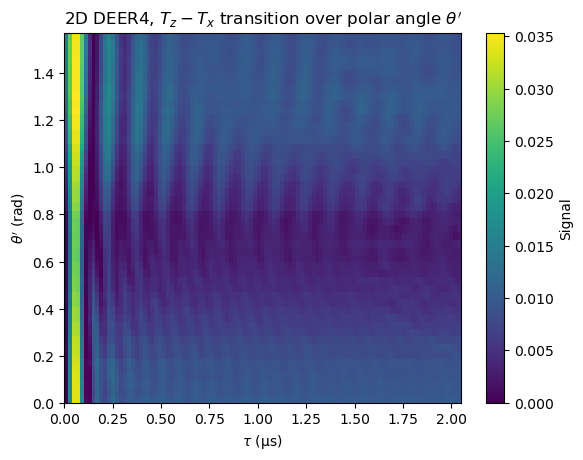

In [9]:
#plt.figure(figsize=(6, 4))
plt.imshow(Total_result_theta_xz.real[::-1,:]-np.min(Total_result_theta_xz.real[::-1,:], axis=1, keepdims=True), aspect='auto', extent=[tau[0], tau[-1], theta_12_list[0], theta_12_list[-1]])
plt.colorbar(label='Signal')
plt.xlabel('$\\tau$ (µs)')
plt.ylabel('$\\theta\'$ (rad)')
plt.title('2D DEER4, $T_z-T_x$ transition over polar angle $\\theta\'$')
plt.savefig('DEER_simulation_0618\\2D_4_pulse_DEER_signal_Tz-Tx_over_theta_12.pdf', dpi=600, bbox_inches='tight')

#plt.imshow(vmin=0, vmax=0.005)

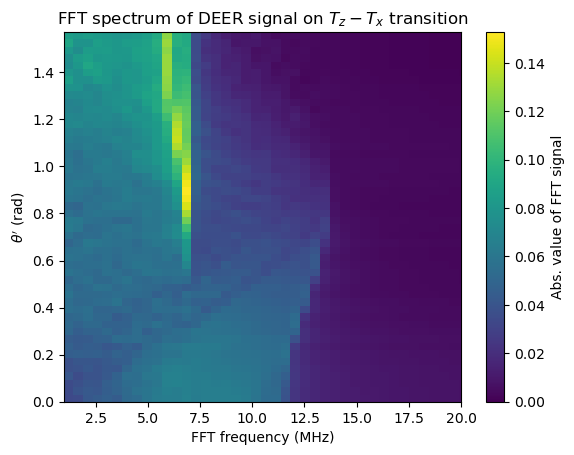

In [10]:
fft_freq=np.fft.rfftfreq(len(tau), tau[1]-tau[0])
sig_fft_theta_xz = np.fft.rfft(Total_result_theta_xz.real-np.mean(Total_result_theta_xz.real, axis=1, keepdims=True), axis=1)
plt.imshow(np.abs(sig_fft_theta_xz[::-1,:]), aspect='auto', extent=[fft_freq[0], fft_freq[-1], theta_12_list[0], theta_12_list[-1]])
plt.colorbar(label='Abs. value of FFT signal')
plt.xlabel('FFT frequency (MHz)')
plt.xlim(1, 20)
plt.ylabel('$\\theta\'$ (rad)')
plt.title('FFT spectrum of DEER signal on $T_z-T_x$ transition')
plt.savefig('FFT_spectrum_of_DEER_signal_on_Tz-Tx_transition_over_theta_12.pdf', dpi=600, bbox_inches='tight')

In [198]:
import deerlab as dl
results_theta_xz = ['']*len(theta_12_list)
r = np.arange(1.5,5,0.02) # nm
# Construct the model
Vmodel = dl.dipolarmodel(tau,r, experiment = dl.ex_4pdeer(tau_eyfp_1,tau_eyfp_2, pathways=[1,2, 3,4]))
# Fit the model to the data
#for i in range(len(B_list)):
#    Vexp = Total_result[i]
#    Vfit = dl.fit(Vmodel, Vexp)
#    results[i] = Vfit

from concurrent.futures import ThreadPoolExecutor


def worker_theta_xz(i):
    Vexp = Total_result_theta_xz[i]
    Vexp = (Vexp - np.min(Vexp)) / (np.max(Vexp) - np.min(Vexp)) #Normalization
    Vfit = dl.fit(Vmodel, Vexp)
    return i, Vfit
# Use ThreadPoolExecutor to parallelize the fitting process

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(worker_theta_xz, i) for i in range(len(theta_12_list))]
    for future in futures:
        i, Vfit = future.result()
        results_theta_xz[i] = Vfit

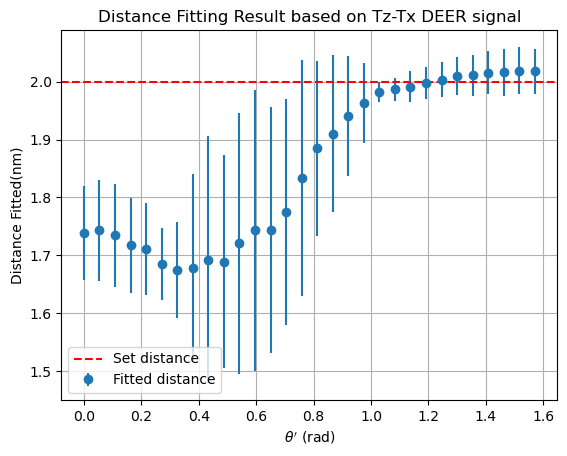

In [219]:
distance_d, Variance_d = distance_from_fit(results_theta_xz)
plt.errorbar(theta_12_list, distance_d, yerr=np.sqrt(Variance_d), fmt='o', label='Fitted distance')
#plot an horizontal line at 2.0 nm
plt.axhline(y=2.0, color='r', linestyle='--', label='Set distance')
plt.xlabel('$\\theta\'$ (rad)')
plt.ylabel('Distance Fitted(nm)')
plt.legend()
plt.title('Distance Fitting Result based on Tz-Tx DEER signal')
plt.grid()
plt.show()

## 2. DEER over Tz-Ty vs. polar angle

In [11]:
B0=0.03 # T
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note
tau_list=np.linspace(0, 0.3, 301)
theta_12_list = np.linspace(0, np.pi/2, 50)
N_tau=101
tau_eyfp_1, tau_eyfp_2 = 0.05, 2.00
Total_result_theta_yz = np.zeros((len(theta_12_list), N_tau), dtype=np.complex128)
phi_12 = 0.0 # Set phi_12=0 for simplicity; but generally it is not)

for i in range(len(theta_12_list)):
    theta_12_i = theta_12_list[i] # 

    Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation_numba(B0, D0, E0, d, Omega1, phi_01, theta_01, chi_01, theta_12_i, phi_12)
    gamma_linewidth = 0.01 #GHz, linewidth
    f_axis = np.linspace(np.min(Tyz)-gamma_linewidth*3, np.max(Tyz)+gamma_linewidth*3, 1000)
    I_lines = np.ones(len(Tyz))/(len(Tyz)) #Intensity of each line

    # Simulate spectrum
    spectrum = convolve_spectrum_numba(Tyz, I_lines, f_axis, gamma_linewidth)
    f_at_sig_max = f_axis[np.argmax(spectrum)] #Microwave pumping frequency at the maximum signal

    #Rabi simulation to obtain the pi pulse duration
    Rabi_signal = compute_rabi_signal(ny, nz, Rabi_freq_yz, deltayz, Tyz, f_at_sig_max, tau_list)
    pi_pulse_duration = tau_list[np.argmin(Rabi_signal)] #Duration of pi pulse

    #Simulate DEER signal
    detuning_yz = deltayz + (np.mean(Tyz) - f_at_sig_max) * 1000 * 2 * np.pi #Tz-Tx transition detuning
    tau, sig_p_yz, sig_m_yz, sig_c=DEER_4_pulse_numba(Rabi_freq_yz, pi_pulse_duration, Omega1, detuning_yz, Dss_zy, tau_eyfp_1, tau_eyfp_2, N_tau, nz, ny)
    Total_result_theta_yz[i] = (sig_p_yz + sig_m_yz) / 2
    #Total_result[i] = (Total_result[i] - np.min(Total_result[i])) / (np.max(Total_result[i]) - np.min(Total_result[i])) #Normalization

In [12]:
import pickle
with open("DEER_simulation_0618\\Four_Pulse_DEER_for_different_theta_12_from_0_to_90_tau_1(50ns)_tau_2(2000ns)_Tz-Ty(phi12=0).pkl", "wb") as f:
    pickle.dump(Total_result_theta_yz.real, f)

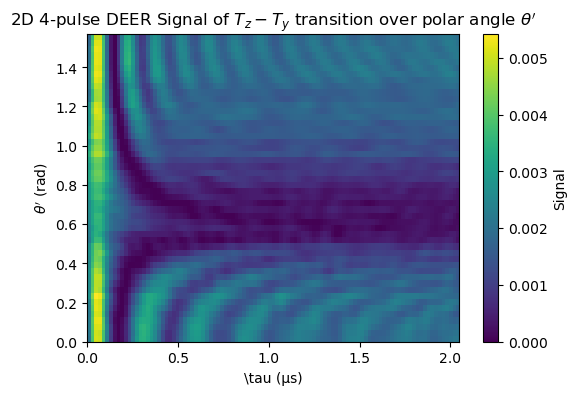

In [13]:
plt.figure(figsize=(6, 4))
plt.imshow(Total_result_theta_yz.real[::-1,:]-np.min(Total_result_theta_yz.real[::-1,:], axis=1, keepdims=True), aspect='auto', extent=[tau[0], tau[-1], theta_12_list[0], theta_12_list[-1]])
plt.colorbar(label='Signal')
plt.xlabel('\\tau (µs)')
plt.ylabel('$\\theta\'$ (rad)')
plt.title('2D 4-pulse DEER Signal of $T_z-T_y$ transition over polar angle $\\theta\'$')
#plt.imshow(vmin=0, vmax=0.005)
plt.savefig('DEER_simulation_0618\\2D_4_pulse_DEER_signal_Tz-Ty_over_theta_12.pdf', dpi=300, bbox_inches='tight')

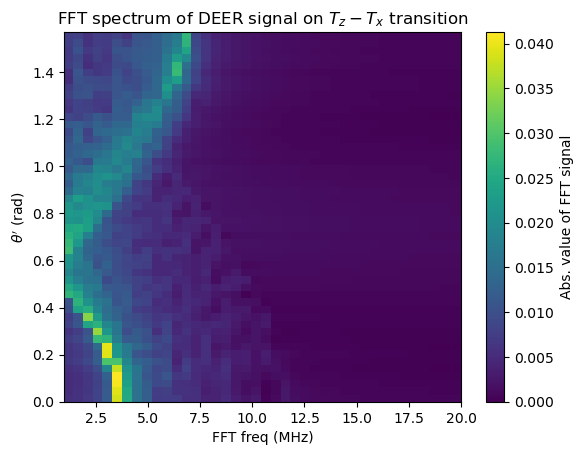

In [14]:
fft_freq=np.fft.rfftfreq(len(tau), tau[1]-tau[0])
sig_fft_theta_yz = np.fft.rfft(Total_result_theta_yz.real[::-1,:]-np.mean(Total_result_theta_yz.real[::-1,:], axis=1, keepdims=True), axis=1)
plt.imshow(np.abs(sig_fft_theta_yz), aspect='auto', extent=[fft_freq[0], fft_freq[-1], theta_12_list[0], theta_12_list[-1]])
plt.colorbar(label='Abs. value of FFT signal')
plt.xlabel('FFT freq (MHz)')
plt.xlim(1, 20)
plt.ylabel('$\\theta\'$ (rad)')
plt.title('FFT spectrum of DEER signal on $T_z-T_x$ transition')
plt.savefig('DEER_simulation_0618\\FFT_spectrum_of_DEER_signal_on_Tz-Ty_transition_over_theta_12.pdf', dpi=600, bbox_inches='tight')

In [203]:
import deerlab as dl
results_theta_yz = ['']*len(theta_12_list)
r = np.arange(1.5,5,0.02) # nm
# Construct the model
Vmodel = dl.dipolarmodel(tau,r, experiment = dl.ex_4pdeer(tau_eyfp_1,tau_eyfp_2, pathways=[1,2, 3,4]))
# Fit the model to the data
#for i in range(len(B_list)):
#    Vexp = Total_result[i]
#    Vfit = dl.fit(Vmodel, Vexp)
#    results[i] = Vfit

from concurrent.futures import ThreadPoolExecutor


def worker_theta_yz(i):
    Vexp = Total_result_theta_yz[i]
    Vexp = (Vexp - np.min(Vexp)) / (np.max(Vexp) - np.min(Vexp)) #Normalization
    Vfit = dl.fit(Vmodel, Vexp)
    return i, Vfit
# Use ThreadPoolExecutor to parallelize the fitting process

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(worker_theta_yz, i) for i in range(len(theta_12_list))]
    for future in futures:
        i, Vfit = future.result()
        results_theta_yz[i] = Vfit

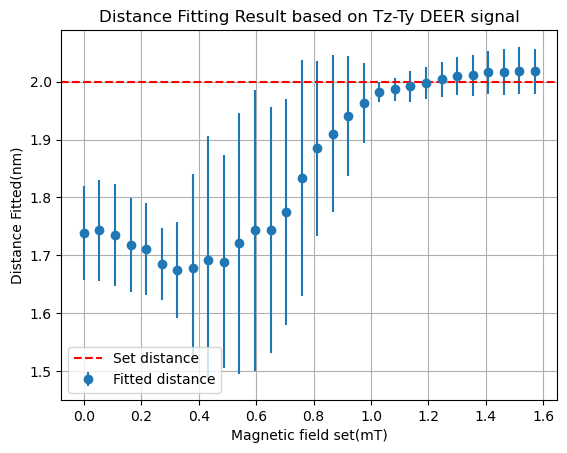

In [220]:
distance_d, Variance_d = distance_from_fit(results_theta_xz)
plt.errorbar(theta_12_list, distance_d, yerr=np.sqrt(Variance_d), fmt='o', label='Fitted distance')
#plot an horizontal line at 2.0 nm
plt.axhline(y=2.0, color='r', linestyle='--', label='Set distance')
plt.xlabel('Magnetic field set(mT)')
plt.ylabel('Distance Fitted(nm)')
plt.legend()
plt.title('Distance Fitting Result based on Tz-Ty DEER signal')
plt.grid()
plt.show()

3. DEER over Tz-Tx vs. azimuthal angle

In [15]:
B0=0.03 # T
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note
tau_list=np.linspace(0, 0.3, 301)
phi_12_list = np.linspace(0, np.pi*2, 60)
N_tau=101
tau_eyfp_1, tau_eyfp_2 = 0.05, 2.00
Total_result_phi_xz = np.zeros((len(phi_12_list), N_tau), dtype=np.complex128)
theta_12 = np.pi/2 

for i in range(len(phi_12_list)):
    phi_12_i = phi_12_list[i] # 

    Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation_numba(B0, D0, E0, d, Omega1, phi_01, theta_01, chi_01, theta_12, phi_12_i)
    gamma_linewidth = 0.01 #GHz, linewidth
    f_axis = np.linspace(np.min(Txz)-gamma_linewidth*3, np.max(Txz)+gamma_linewidth*3, 1000)
    I_lines = np.ones(len(Txz))/(len(Txz)) #Intensity of each line

    # Simulate spectrum
    spectrum = convolve_spectrum_numba(Txz, I_lines, f_axis, gamma_linewidth)
    f_at_sig_max = f_axis[np.argmax(spectrum)] #Microwave pumping frequency at the maximum signal

    #Rabi simulation to obtain the pi pulse duration
    Rabi_signal = compute_rabi_signal(nx, nz, Rabi_freq_xz, deltaxz, Txz, f_at_sig_max, tau_list)
    pi_pulse_duration = tau_list[np.argmin(Rabi_signal)] #Duration of pi pulse

    #Simulate DEER signal
    detuning_xz = deltaxz + (np.mean(Txz) - f_at_sig_max) * 1000 * 2 * np.pi #Tz-Tx transition detuning
    tau, sig_p_xz, sig_m_xz, sig_c=DEER_4_pulse_numba(Rabi_freq_xz, pi_pulse_duration, Omega1, detuning_xz, Dss_zx, tau_eyfp_1, tau_eyfp_2, N_tau, nz, nx)
    Total_result_phi_xz[i] = (sig_p_xz + sig_m_xz) / 2

In [16]:
import pickle
with open("DEER_simulation_0618\\Four_Pulse_DEER_for_different_phi_12_from_0_to_360_tau_1(50ns)_tau_2(2000ns)_Tz-Tx.pkl", "wb") as f:
    pickle.dump(Total_result_phi_xz.real, f)

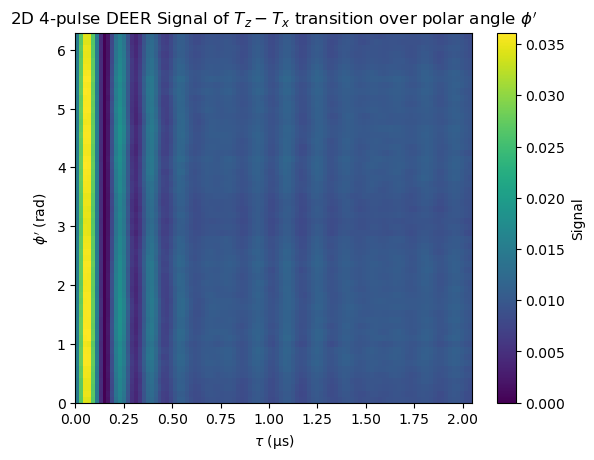

In [17]:
#plt.figure(figsize=(6, 4))
plt.imshow(Total_result_phi_xz.real-np.min(Total_result_phi_xz.real, axis=1, keepdims=True), aspect='auto', extent=[tau[0], tau[-1], phi_12_list[0], phi_12_list[-1]])
plt.colorbar(label='Signal')
plt.xlabel('$\\tau$ (µs)')
plt.ylabel('$\\phi\'$ (rad)')
plt.title('2D 4-pulse DEER Signal of $T_z-T_x$ transition over polar angle $\\phi\'$')
#plt.imshow(vmin=0, vmax=0.005)
plt.savefig('DEER_simulation_0618\\2D_4_pulse_DEER_signal_Tz-Tx_over_phi_12.pdf', dpi=300, bbox_inches='tight')

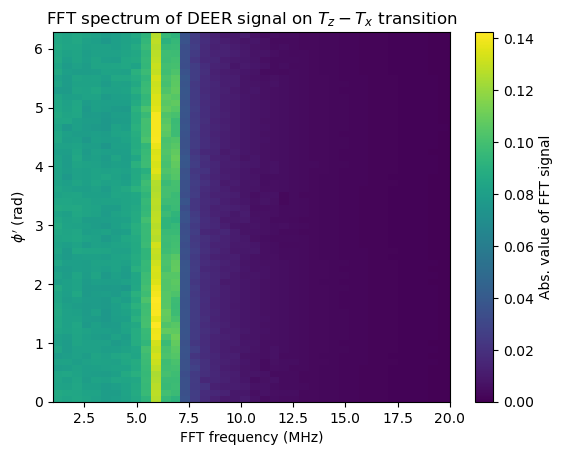

In [18]:
fft_freq=np.fft.rfftfreq(len(tau), tau[1]-tau[0])
sig_fft_phi_xz = np.fft.rfft(Total_result_phi_xz.real-np.mean(Total_result_phi_xz.real, axis=1, keepdims=True), axis=1)
plt.imshow(np.abs(sig_fft_phi_xz), aspect='auto', extent=[fft_freq[0], fft_freq[-1], phi_12_list[0], phi_12_list[-1]])
plt.colorbar(label='Abs. value of FFT signal')
plt.xlabel('FFT frequency (MHz)')
plt.xlim(1, 20)
plt.ylabel('$\\phi\'$ (rad)')
plt.title('FFT spectrum of DEER signal on $T_z-T_x$ transition')
plt.savefig('DEER_simulation_0618\\FFT_spectrum_of_DEER_signal_on_Tz-Tx_transition_over_phi_12.pdf', dpi=300, bbox_inches='tight')

In [208]:
import deerlab as dl
results_phi_xz = ['']*len(phi_12_list)
r = np.arange(1.5,5,0.02) # nm
# Construct the model
Vmodel = dl.dipolarmodel(tau,r, experiment = dl.ex_4pdeer(tau_eyfp_1,tau_eyfp_2, pathways=[1,2, 3,4]))
# Fit the model to the data
#for i in range(len(B_list)):
#    Vexp = Total_result[i]
#    Vfit = dl.fit(Vmodel, Vexp)
#    results[i] = Vfit

from concurrent.futures import ThreadPoolExecutor


def worker_phi_xz(i):
    Vexp = Total_result_phi_xz[i]
    Vexp = (Vexp - np.min(Vexp)) / (np.max(Vexp) - np.min(Vexp)) #Normalization
    Vfit = dl.fit(Vmodel, Vexp)
    return i, Vfit
# Use ThreadPoolExecutor to parallelize the fitting process

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(worker_phi_xz, i) for i in range(len(phi_12_list))]
    for future in futures:
        i, Vfit = future.result()
        results_phi_xz[i] = Vfit

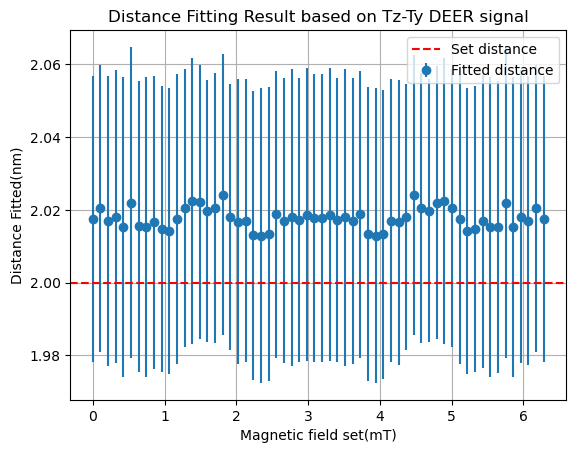

In [221]:
distance_d, Variance_d = distance_from_fit(results_phi_xz)
plt.errorbar(phi_12_list, distance_d, yerr=np.sqrt(Variance_d), fmt='o', label='Fitted distance')
#plot an horizontal line at 2.0 nm
plt.axhline(y=2.0, color='r', linestyle='--', label='Set distance')
plt.xlabel('Magnetic field set(mT)')
plt.ylabel('Distance Fitted(nm)')
plt.legend()
plt.title('Distance Fitting Result based on Tz-Ty DEER signal')
plt.grid()
plt.show()

4. DEER over Tz-Ty vs. azimuthal angle

In [ ]:
B0=0.03 # T
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note
tau_list=np.linspace(0, 0.3, 301)
phi_12_list = np.linspace(0, np.pi*2, 60)
N_tau=101
tau_eyfp_1, tau_eyfp_2 = 0.05, 2.00
Total_result_phi_yz = np.zeros((len(phi_12_list), N_tau), dtype=np.complex128)
theta_12 = np.pi/2 

for i in range(len(phi_12_list)):
    phi_12_i = phi_12_list[i] # 

    Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation_numba(B0, D0, E0, d, Omega1, phi_01, theta_01, chi_01, theta_12, phi_12_i)
    gamma_linewidth = 0.01 #GHz, linewidth
    f_axis = np.linspace(np.min(Tyz)-gamma_linewidth*3, np.max(Tyz)+gamma_linewidth*3, 1000)
    I_lines = np.ones(len(Tyz))/(len(Tyz)) #Intensity of each line

    # Simulate spectrum
    spectrum = convolve_spectrum_numba(Tyz, I_lines, f_axis, gamma_linewidth)
    f_at_sig_max = f_axis[np.argmax(spectrum)] #Microwave pumping frequency at the maximum signal

    #Rabi simulation to obtain the pi pulse duration
    Rabi_signal = compute_rabi_signal(ny, nz, Rabi_freq_yz, deltayz, Tyz, f_at_sig_max, tau_list)
    pi_pulse_duration = tau_list[np.argmin(Rabi_signal)] #Duration of pi pulse

    #Simulate DEER signal
    detuning_yz = deltayz + (np.mean(Tyz) - f_at_sig_max) * 1000 * 2 * np.pi #Tz-Tx transition detuning
    tau, sig_p_yz, sig_m_yz, sig_c=DEER_4_pulse_numba(Rabi_freq_yz, pi_pulse_duration, Omega1, detuning_yz, Dss_zy, tau_eyfp_1, tau_eyfp_2, N_tau, nz, ny)
    Total_result_phi_yz[i] = (sig_p_yz + sig_m_yz) / 2
    #Total_result[i] = (Total_result[i] - np.min(Total_result[i])) / (np.max(Total_result[i]) - np.min(Total_result[i])) #Normalization

In [ ]:
import pickle
with open("DEER_simulation_0618\\Four_Pulse_DEER_for_different_phi_12_from_0_to_360_tau_1(50ns)_tau_2(2000ns)_Tz-Ty.pkl", "wb") as f:
    pickle.dump(Total_result_phi_yz.real, f)

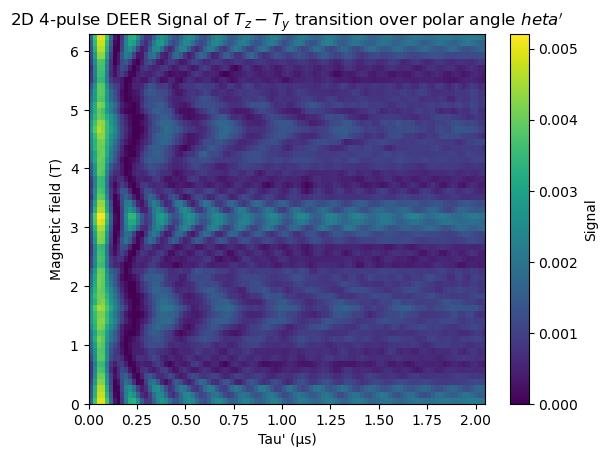

In [ ]:
plt.imshow(Total_result_phi_yz.real-np.min(Total_result_phi_yz.real, axis=1, keepdims=True), aspect='auto', extent=[tau[0], tau[-1], phi_12_list[0], phi_12_list[-1]])
plt.colorbar(label='Signal')
plt.xlabel('$\\tau$ (µs)')
plt.ylabel('Magnetic field (T)')
plt.title('2D 4-pulse DEER Signal of $T_z-T_y$ transition over polar angle $\\phi\'$')
#plt.imshow(vmin=0, vmax=0.005)
plt.savefig('DEER_simulation_0618\\2D_4_pulse_DEER_signal_Tz-Ty_over_phi_12.pdf', dpi=300, bbox_inches='tight')

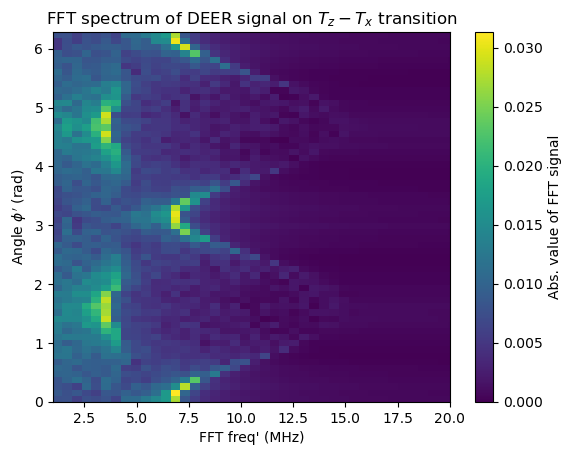

In [ ]:
fft_freq=np.fft.rfftfreq(len(tau), tau[1]-tau[0])
sig_fft_phi_yz = np.fft.rfft(Total_result_phi_yz.real-np.mean(Total_result_phi_yz.real, axis=1, keepdims=True), axis=1)
plt.imshow(np.abs(sig_fft_phi_yz), aspect='auto', extent=[fft_freq[0], fft_freq[-1], phi_12_list[0], phi_12_list[-1]])
plt.colorbar(label='Abs. value of FFT signal')
plt.xlabel('FFT frequency (MHz)')
plt.xlim(1, 20)
plt.ylabel('$\\phi\'$ (rad)')
plt.title('FFT spectrum of DEER signal on $T_z-T_x$ transition')
plt.savefig('DEER_simulation_0618\\FFT_spectrum_of_DEER_signal_on_Tz-Ty_transition_over_phi_12.pdf', dpi=300, bbox_inches='tight')

In [223]:
import deerlab as dl
results_phi_yz = ['']*len(phi_12_list)
r = np.arange(1.5,5,0.02) # nm
# Construct the model
Vmodel = dl.dipolarmodel(tau,r, experiment = dl.ex_4pdeer(tau_eyfp_1,tau_eyfp_2, pathways=[1,2, 3,4]))
# Fit the model to the data
#for i in range(len(B_list)):
#    Vexp = Total_result[i]
#    Vfit = dl.fit(Vmodel, Vexp)
#    results[i] = Vfit

from concurrent.futures import ThreadPoolExecutor


def worker_phi_yz(i):
    Vexp = Total_result_phi_yz[i]
    Vexp = (Vexp - np.min(Vexp)) / (np.max(Vexp) - np.min(Vexp)) #Normalization
    Vfit = dl.fit(Vmodel, Vexp)
    return i, Vfit
# Use ThreadPoolExecutor to parallelize the fitting process

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(worker_phi_yz, i) for i in range(len(phi_12_list))]
    for future in futures:
        i, Vfit = future.result()
        results_phi_yz[i] = Vfit

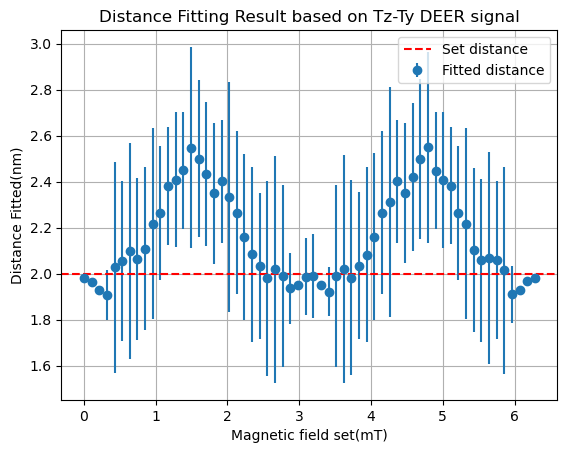

In [224]:
distance_d, Variance_d = distance_from_fit(results_phi_yz)
plt.errorbar(phi_12_list, distance_d, yerr=np.sqrt(Variance_d), fmt='o', label='Fitted distance')
#plot an horizontal line at 2.0 nm
plt.axhline(y=2.0, color='r', linestyle='--', label='Set distance')
plt.xlabel('Magnetic field set(mT)')
plt.ylabel('Distance Fitted(nm)')
plt.legend()
plt.title('Distance Fitting Result based on Tz-Ty DEER signal')
plt.grid()
plt.show()

## Using spin-echo DEER pulse sequence

In [ ]:
B0=0.03 # T
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note
tau_list=np.linspace(0, 0.1, 101)
N_tau=201
tau_NV_DEER=1.0
theta_12 = np.pi/2 
phi_12 = 0.0 # Set phi_12=0 for simplicity; but generally it is not)
V = 52.16/1000 # Hss coefficient, unit: 2pi*GHz*nm^3
d=2 # distance, unit: nm
tau_max=1.0 # maximum tau for DEER, unit: us

#H0 and eigenvectors
D0 = 2.348 #GHz
E0 = 0.458 #GHz
phi_01, theta_01, chi_01=Generate_molecule_set_Fibonacci_sphere(10000, 30)

#Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation_numba(B0, D0, E0, d, Omega1, phi_01, theta_01, chi_01, theta_12, phi_12)

#tau, sig=DEER_NV_numba(Rabi_freq_xz, 0.014, Omega1, deltaxz, Dss_zx, tau_max, N_tau, nz, nx)

In [64]:
np.mean(nx-nz)

np.float64(0.17938557762701834)

In [62]:
Rabi_signal = compute_rabi_signal(nx, nz, Rabi_freq_xz, deltaxz, Txz, 3.325, tau_list)
print(tau_list[np.argmin(Rabi_signal)]) #Duration of pi pulse

0.014


c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


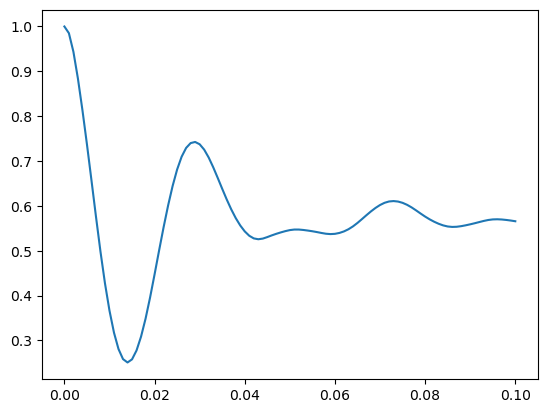

In [65]:
plt.plot(tau_list,Rabi_signal/np.mean(nx-nz))

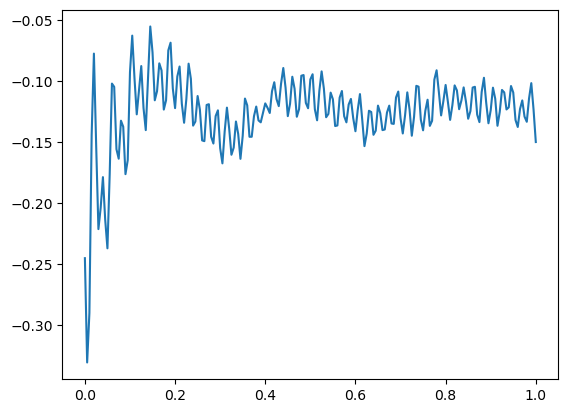

In [66]:
plt.plot(tau, sig/np.mean(nx-nz), label='DEER signal')

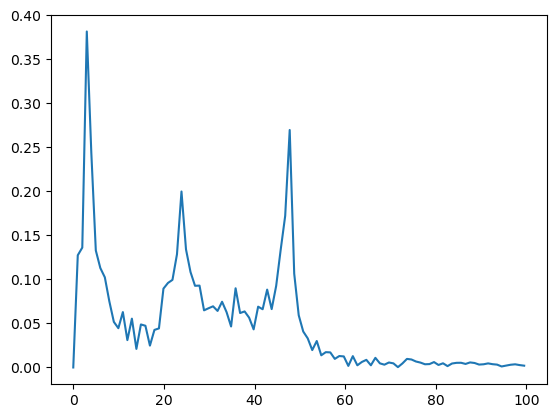

In [67]:
sig_fft= np.fft.rfft(sig-np.mean(sig), axis=0)
plt.plot(np.fft.rfftfreq(len(tau), tau[1]-tau[0]), np.abs(sig_fft), label='FFT of DEER signal')

In [68]:
Rabi_signal = compute_rabi_signal(ny, nz, Rabi_freq_yz, deltayz, Tyz, 2.13, tau_list)
print(tau_list[np.argmin(Rabi_signal)]) #Duration of pi pulse

0.012


c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\compt\miniforge3\envs\EYPsim\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


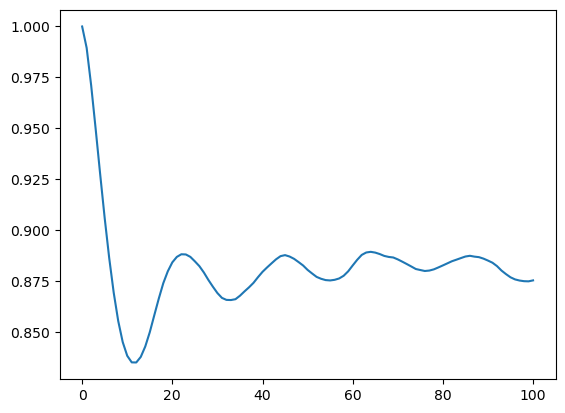

In [71]:
plt.plot(Rabi_signal/np.mean(ny-nz), label='DEER signal')

In [45]:
tau, sig=DEER_NV_numba(Rabi_freq_yz, 0.012, Omega1, deltayz, Dss_zy, tau_max, N_tau, nz, ny)

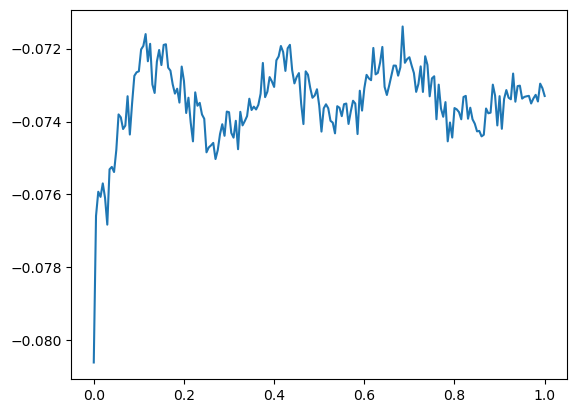

In [46]:
plt.plot(tau, sig.real, label='DEER signal')

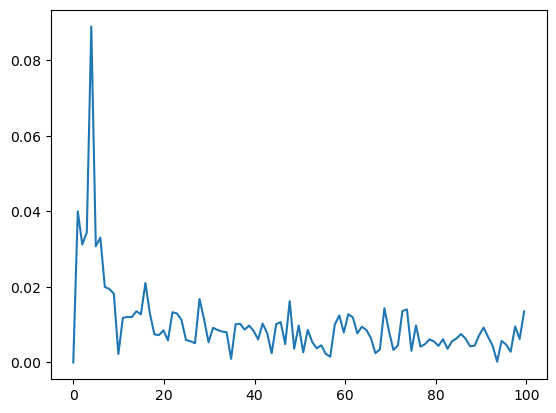

In [47]:
sig_fft= np.fft.rfft(sig-np.mean(sig), axis=0)
plt.plot(np.fft.rfftfreq(len(tau), tau[1]-tau[0]), np.abs(sig_fft), label='FFT of DEER signal')

1. DEER over Tz-Tx vs. polar angle

In [ ]:
B0=0.03 # T
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note
tau_list=np.linspace(0, 0.3, 301)
theta_12_list = np.linspace(0, np.pi/2, 50)
N_tau=201
tau_max=2.0
Total_result_theta_xz = np.zeros((len(theta_12_list), N_tau), dtype=np.complex128)
phi_12 = 0.0 # Set phi_12=0 for simplicity; but generally it is not)

for i in range(len(theta_12_list)):
    theta_12_i = theta_12_list[i] # 

    Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation_numba(B0, D0, E0, d, Omega1, phi_01, theta_01, chi_01, theta_12_i, phi_12)
    gamma_linewidth = 0.01 #GHz, linewidth
    f_axis = np.linspace(np.min(Txz)-gamma_linewidth*3, np.max(Txz)+gamma_linewidth*3, 1000)
    I_lines = np.ones(len(Txz))/(len(Txz)) #Intensity of each line

    # Simulate spectrum
    spectrum = convolve_spectrum_numba(Txz, I_lines, f_axis, gamma_linewidth)
    f_at_sig_max = f_axis[np.argmax(spectrum)] #Microwave pumping frequency at the maximum signal

    #Rabi simulation to obtain the pi pulse duration
    Rabi_signal = compute_rabi_signal(nx, nz, Rabi_freq_xz, deltaxz, Txz, f_at_sig_max, tau_list)
    pi_pulse_duration = tau_list[np.argmin(Rabi_signal)] #Duration of pi pulse

    #Simulate DEER signal
    detuning_xz = deltaxz + (np.mean(Txz) - f_at_sig_max) * 1000 * 2 * np.pi #Tz-Tx transition detuning
    tau_exp, sig_xz=DEER_NV_numba(Rabi_freq_xz, pi_pulse_duration, Omega1, detuning_xz, Dss_zx, tau_max, N_tau, nz, nx)

    Total_result_theta_xz[i] = sig_xz

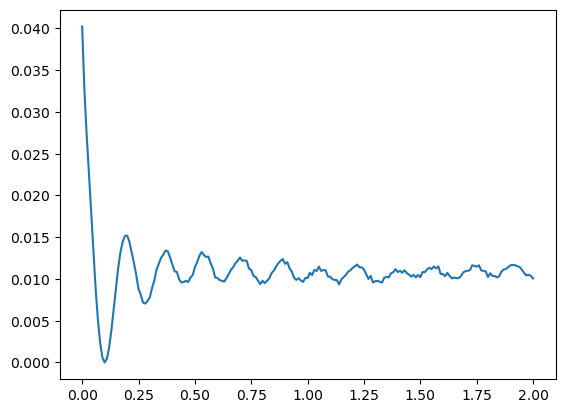

In [138]:
plt.plot(tau_exp, np.max(Total_result_theta_xz.real[5])-Total_result_theta_xz[5].real, label='DEER signal for theta_12=0')

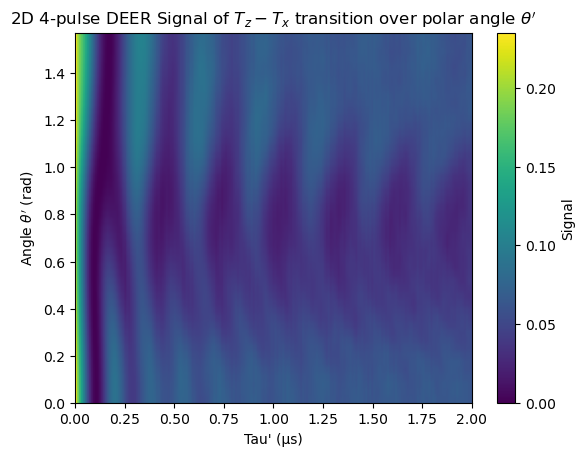

In [ ]:
plt.imshow((-Total_result_theta_xz.real[::-1,:]+np.max(Total_result_theta_xz.real[::-1,:], axis=1, keepdims=True))/np.mean(nx-nz), aspect='auto', extent=[tau[0], tau[-1], theta_12_list[0], theta_12_list[-1]])
plt.colorbar(label='Signal')
plt.xlabel('\\tau (µs)')
plt.ylabel('$\\theta\'$ (rad)')
plt.title('2D 4-pulse DEER Signal of $T_z-T_x$ transition over polar angle $\\theta\'$')
plt.savefig('Spin-echo_DEER_simulation\\2D_NV_DEER_signal_Tz-Tx_over_theta_12.pdf', dpi=300, bbox_inches='tight')

In [ ]:
import pickle
with open("Spin-echo_DEER_simulation\\NV_DEER_for_different_theta_12_from_0_to_90_tau(2000ns)_Tz-Tx.pkl", "wb") as f:
    pickle.dump(Total_result_theta_xz.real, f)

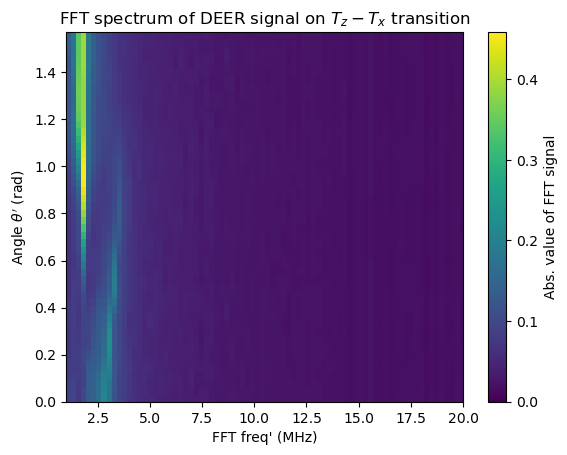

In [ ]:
fft_freq=np.fft.rfftfreq(len(tau), tau[1]-tau[0])
sig_fft_theta_xz = np.fft.rfft(Total_result_theta_xz.real-np.mean(Total_result_theta_xz.real, axis=1, keepdims=True), axis=1)
plt.imshow(np.abs(sig_fft_theta_xz[::-1,:]), aspect='auto', extent=[fft_freq[0], fft_freq[-1], theta_12_list[0], theta_12_list[-1]])
plt.colorbar(label='Abs. value of FFT signal')
plt.xlabel('FFT frequency (MHz)')
plt.xlim(1, 20)
plt.ylabel('$\\theta\'$ (rad)')
plt.title('FFT spectrum of DEER signal on $T_z-T_x$ transition')
plt.savefig('Spin-echo_DEER_simulation\\FFT_spectrum_of_NV_DEER_signal_on_Tz-Tx_transition_over_theta_12.pdf', dpi=300, bbox_inches='tight')

2. DEER with Tz-Ty vs polar angle

In [ ]:
B0=0.03 # T
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note
tau_list=np.linspace(0, 0.3, 301)
theta_12_list = np.linspace(0, np.pi/2, 50)
N_tau=201
tau_max=2.0
Total_result_theta_yz = np.zeros((len(theta_12_list), N_tau), dtype=np.complex128)
phi_12 = 0.0 # Set phi_12=0 for simplicity; but generally it is not)

for i in range(len(theta_12_list)):
    theta_12_i = theta_12_list[i] # 

    Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation_numba(B0, D0, E0, d, Omega1, phi_01, theta_01, chi_01, theta_12_i, phi_12)
    gamma_linewidth = 0.01 #GHz, linewidth
    f_axis = np.linspace(np.min(Tyz)-gamma_linewidth*3, np.max(Tyz)+gamma_linewidth*3, 1000)
    I_lines = np.ones(len(Tyz))/(len(Tyz)) #Intensity of each line

    # Simulate spectrum
    spectrum = convolve_spectrum_numba(Tyz, I_lines, f_axis, gamma_linewidth)
    f_at_sig_max = f_axis[np.argmax(spectrum)] #Microwave pumping frequency at the maximum signal

    #Rabi simulation to obtain the pi pulse duration
    Rabi_signal = compute_rabi_signal(ny, nz, Rabi_freq_yz, deltayz, Tyz, f_at_sig_max, tau_list)
    pi_pulse_duration = tau_list[np.argmin(Rabi_signal)] #Duration of pi pulse

    #Simulate DEER signal
    detuning_yz = deltayz + (np.mean(Tyz) - f_at_sig_max) * 1000 * 2 * np.pi #Tz-Tx transition detuning
    tau_exp, sig_yz=DEER_NV_numba(Rabi_freq_yz, pi_pulse_duration, Omega1, detuning_yz, Dss_zy, tau_max, N_tau, nz, ny)
    Total_result_theta_yz[i] = sig_yz

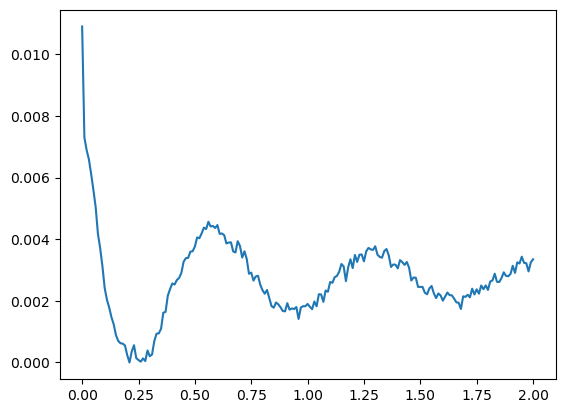

In [139]:
plt.plot(tau_exp, np.max(Total_result_theta_yz.real[7])-Total_result_theta_yz[7].real, label='DEER signal for theta_12=0')

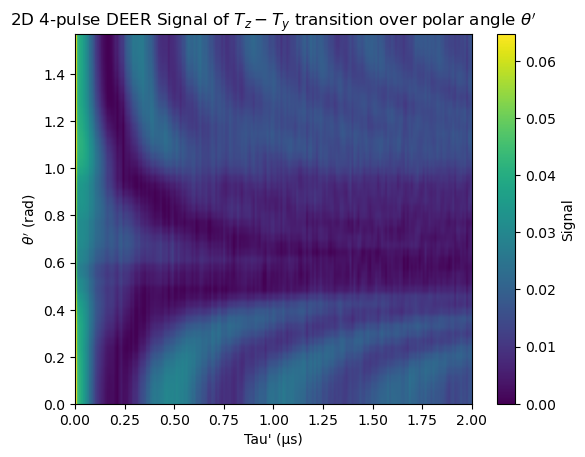

In [ ]:
plt.imshow((-Total_result_theta_yz.real[::-1,:]+np.max(Total_result_theta_yz.real[::-1,:], axis=1, keepdims=True))/np.mean(ny-nz), aspect='auto', extent=[tau[0], tau[-1], theta_12_list[0], theta_12_list[-1]])
plt.colorbar(label='Signal')
plt.xlabel('\\tau (µs)')
plt.ylabel('$\\theta\'$ (rad)')
plt.title('2D 4-pulse DEER Signal of $T_z-T_y$ transition over polar angle $\\theta\'$')
#plt.imshow(vmin=0, vmax=0.005)
plt.savefig('Spin-echo_DEER_simulation\\2D_NV_DEER_signal_Tz-Ty_over_theta_12.pdf', dpi=600, bbox_inches='tight')

In [ ]:
import pickle
with open("Spin-echo_DEER_simulation\\NV_DEER_for_different_theta_12_from_0_to_90_tau(2000ns)_Tz-Ty.pkl", "wb") as f:
    pickle.dump(Total_result_theta_yz.real, f)

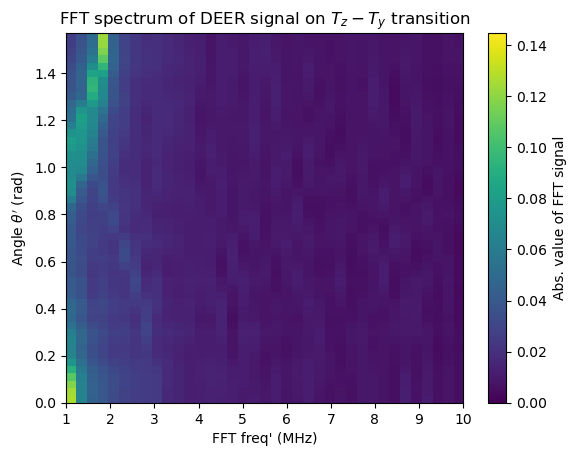

In [ ]:
fft_freq=np.fft.rfftfreq(len(tau), tau[1]-tau[0])
sig_fft_theta_yz = np.fft.rfft(Total_result_theta_yz.real-np.mean(Total_result_theta_yz.real, axis=1, keepdims=True), axis=1)
plt.imshow(np.abs(sig_fft_theta_yz[::-1,:]), aspect='auto', extent=[fft_freq[0], fft_freq[-1], theta_12_list[0], theta_12_list[-1]])
plt.colorbar(label='Abs. value of FFT signal')
plt.xlabel('FFT freq (MHz)')
plt.xlim(1, 10)
plt.ylabel('$\\theta\'$ (rad)')
plt.title('FFT spectrum of DEER signal on $T_z-T_y$ transition')
plt.savefig('Spin-echo_DEER_simulation\\FFT_spectrum_of_NV_DEER_signal_on_Tz-Ty_transition_over_theta_12.pdf', dpi=300, bbox_inches='tight')

3. NV DEER on Tz-Tx vs. azimuthal angle

In [ ]:
B0=0.03 # T
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note
tau_list=np.linspace(0, 0.3, 301)
phi_12_list = np.linspace(0, 2*np.pi, 60)
N_tau=201
tau_max=2.0
Total_result_phi_xz = np.zeros((len(theta_12_list), N_tau), dtype=np.complex128)
theta_12 = np.pi/2 

for i in range(len(phi_12_list)):
    phi_12_i = phi_12_list[i] # 

    Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation_numba(B0, D0, E0, d, Omega1, phi_01, theta_01, chi_01, theta_12, phi_12_i)
    gamma_linewidth = 0.01 #GHz, linewidth
    f_axis = np.linspace(np.min(Txz)-gamma_linewidth*3, np.max(Txz)+gamma_linewidth*3, 1000)
    I_lines = np.ones(len(Txz))/(len(Txz)) #Intensity of each line

    # Simulate spectrum
    spectrum = convolve_spectrum_numba(Txz, I_lines, f_axis, gamma_linewidth)
    f_at_sig_max = f_axis[np.argmax(spectrum)] #Microwave pumping frequency at the maximum signal

    #Rabi simulation to obtain the pi pulse duration
    Rabi_signal = compute_rabi_signal(nx, nz, Rabi_freq_xz, deltaxz, Txz, f_at_sig_max, tau_list)
    pi_pulse_duration = tau_list[np.argmin(Rabi_signal)] #Duration of pi pulse

    #Simulate DEER signal
    detuning_xz = deltaxz + (np.mean(Txz) - f_at_sig_max) * 1000 * 2 * np.pi #Tz-Tx transition detuning
    tau_exp, sig_xz=DEER_NV_numba(Rabi_freq_xz, pi_pulse_duration, Omega1, detuning_xz, Dss_zx, tau_max, N_tau, nz, nx)

    Total_result_phi_xz[i] = sig_xz

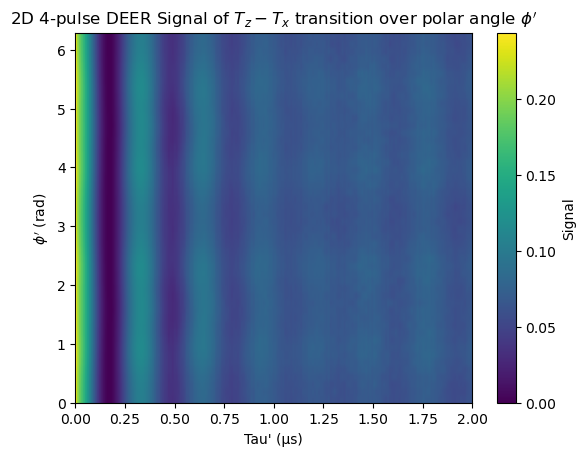

In [ ]:
plt.imshow((-Total_result_phi_xz.real[::-1,:]+np.max(Total_result_phi_xz.real[::-1,:], axis=1, keepdims=True))/np.mean(nx-nz), aspect='auto', extent=[tau[0], tau[-1], phi_12_list[0], phi_12_list[-1]])
plt.colorbar(label='Signal')
plt.xlabel('\\tau (µs)')
plt.ylabel('$\\phi\'$ (rad)')
plt.title('2D 4-pulse DEER Signal of $T_z-T_x$ transition over polar angle $\\phi\'$')
plt.savefig('Spin-echo_DEER_simulation\\2D_4_pulse_DEER_signal_Tz-Tx_over_phi_12.pdf', dpi=300, bbox_inches='tight')

In [ ]:
import pickle
with open("Spin-echo_DEER_simulation\\NV_DEER_for_different_phi_12_from_0_to_360_tau(2000ns)_Tz-Tx.pkl", "wb") as f:
    pickle.dump(Total_result_phi_xz.real, f)

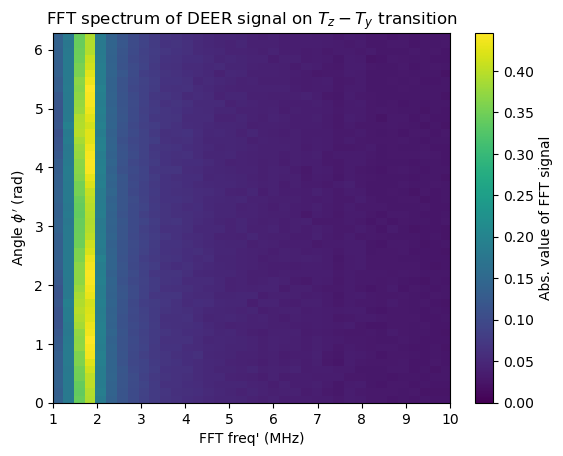

In [ ]:
fft_freq=np.fft.rfftfreq(len(tau), tau[1]-tau[0])
sig_fft_phi_xz = np.fft.rfft(Total_result_phi_xz.real-np.mean(Total_result_phi_xz.real, axis=1, keepdims=True), axis=1)
plt.imshow(np.abs(sig_fft_phi_xz[::-1,:]), aspect='auto', extent=[fft_freq[0], fft_freq[-1], phi_12_list[0], phi_12_list[-1]])
plt.colorbar(label='Abs. value of FFT signal')
plt.xlabel('FFT freq\' (MHz)')
plt.xlim(1, 10)
plt.ylabel('Angle $\\phi\'$ (rad)')
plt.title('FFT spectrum of DEER signal on $T_z-T_y$ transition')
plt.savefig('Spin-echo_DEER_simulation\\FFT_spectrum_of_NV_DEER_signal_on_Tz-Tx_transition_over_phi_12.pdf', dpi=300, bbox_inches='tight')

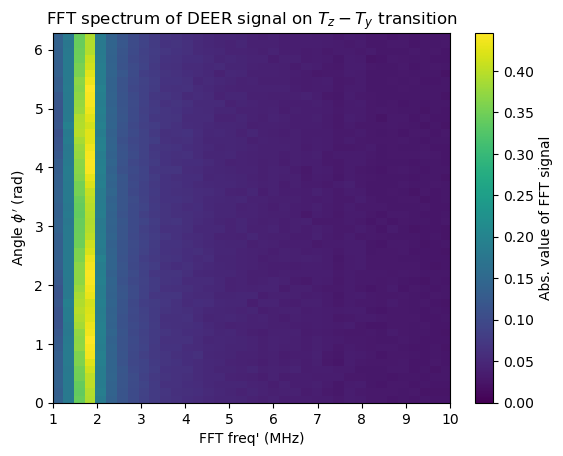

In [ ]:
fft_freq=np.fft.rfftfreq(len(tau), tau[1]-tau[0])
sig_fft_phi_xz = np.fft.rfft(Total_result_phi_xz.real-np.mean(Total_result_phi_xz.real, axis=1, keepdims=True), axis=1)
plt.imshow(np.abs(sig_fft_phi_xz[::-1,:]), aspect='auto', extent=[fft_freq[0], fft_freq[-1], phi_12_list[0], phi_12_list[-1]])
plt.colorbar(label='Abs. value of FFT signal')
plt.xlabel('FFT freq\' (MHz)')
plt.xlim(1, 10)
plt.ylabel('Angle $\\phi\'$ (rad)')
plt.title('FFT spectrum of DEER signal on $T_z-T_y$ transition')
plt.savefig('Spin-echo_DEER_simulation\\FFT_spectrum_of_NV_DEER_signal_on_Tz-Tx_transition_over_phi_12.pdf', dpi=300, bbox_inches='tight')

4. DEER over Tz-Ty vs. azimuthal angle phi

In [ ]:
B0=0.03 # T
Omega1=2*np.pi*50 #microwave strength for driving Rabi oscillation, MHz; equivalent to \gamma_B \times B_1 in the note
tau_list=np.linspace(0, 0.3, 301)
phi_12_list = np.linspace(0, 2*np.pi, 60)
N_tau=201
tau_max=2.0
Total_result_phi_yz = np.zeros((len(theta_12_list), N_tau), dtype=np.complex128)
theta_12 = np.pi/2 

for i in range(len(phi_12_list)):
    phi_12_i = phi_12_list[i] # 

    Txz,Tyz, deltaxz, deltayz, Rabi_freq_xz, Rabi_freq_yz, Dss_zx, Dss_zy, nx, ny, nz = Transitions_and_couplings_calculation_numba(B0, D0, E0, d, Omega1, phi_01, theta_01, chi_01, theta_12, phi_12_i)
    gamma_linewidth = 0.01 #GHz, linewidth
    f_axis = np.linspace(np.min(Tyz)-gamma_linewidth*3, np.max(Tyz)+gamma_linewidth*3, 1000)
    I_lines = np.ones(len(Tyz))/(len(Tyz)) #Intensity of each line

    # Simulate spectrum
    spectrum = convolve_spectrum_numba(Tyz, I_lines, f_axis, gamma_linewidth)
    f_at_sig_max = f_axis[np.argmax(spectrum)] #Microwave pumping frequency at the maximum signal

    #Rabi simulation to obtain the pi pulse duration
    Rabi_signal = compute_rabi_signal(ny, nz, Rabi_freq_yz, deltayz, Tyz, f_at_sig_max, tau_list)
    pi_pulse_duration = tau_list[np.argmin(Rabi_signal)] #Duration of pi pulse

    #Simulate DEER signal
    detuning_yz = deltayz + (np.mean(Tyz) - f_at_sig_max) * 1000 * 2 * np.pi #Tz-Tx transition detuning
    tau_exp, sig_yz=DEER_NV_numba(Rabi_freq_yz, pi_pulse_duration, Omega1, detuning_yz, Dss_zy, tau_max, N_tau, nz, ny)
    Total_result_phi_yz[i] = sig_yz
    #Total_result[i] = (Total_result[i] - np.min(Total_result[i])) / (np.max(Total_result[i]) - np.min(Total_result[i])) #Normalization

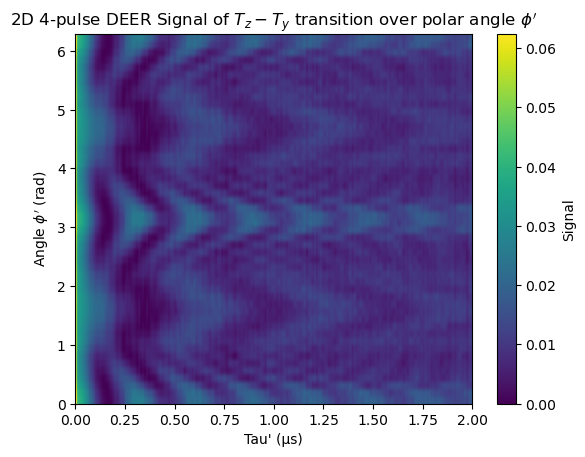

In [ ]:
plt.imshow((-Total_result_phi_yz.real[::-1,:]+np.max(Total_result_phi_yz.real[::-1,:], axis=1, keepdims=True))/np.mean(ny-nz), aspect='auto', extent=[tau[0], tau[-1], phi_12_list[0], phi_12_list[-1]])
plt.colorbar(label='Signal')
plt.xlabel('\\tau (µs)')
plt.ylabel('$\\phi\'$ (rad)')
plt.title('2D 4-pulse DEER Signal of $T_z-T_y$ transition over polar angle $\\phi\'$')
plt.savefig('Spin-echo_DEER_simulation\\2D_4_pulse_DEER_signal_Tz-Ty_over_phi_12.pdf', dpi=600, bbox_inches='tight')

In [ ]:
import pickle
with open("Spin-echo_DEER_simulation\\NV_DEER_for_different_phi_12_from_0_to_360_tau(2000ns)_Tz-Ty.pkl", "wb") as f:
    pickle.dump(Total_result_phi_yz.real, f)

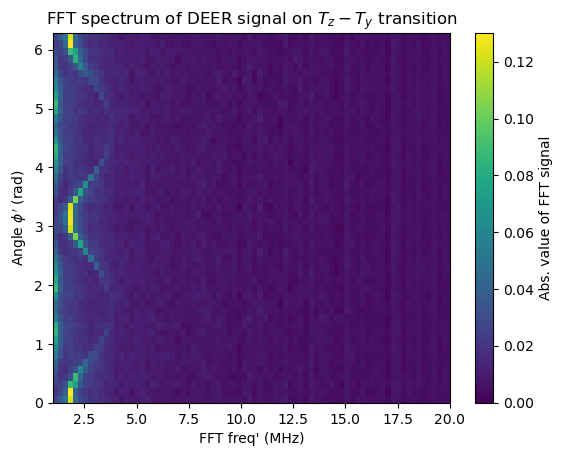

In [ ]:
fft_freq=np.fft.rfftfreq(len(tau), tau[1]-tau[0])
sig_fft_phi_yz = np.fft.rfft(Total_result_phi_yz.real-np.mean(Total_result_phi_yz.real, axis=1, keepdims=True), axis=1)
plt.imshow(np.abs(sig_fft_phi_yz[::-1,:]), aspect='auto', extent=[fft_freq[0], fft_freq[-1], phi_12_list[0], phi_12_list[-1]])
plt.colorbar(label='Abs. value of FFT signal')
plt.xlabel('FFT freq\' (MHz)')
plt.xlim(1, 20)
plt.ylabel('Angle $\\phi\'$ (rad)')
plt.title('FFT spectrum of DEER signal on $T_z-T_y$ transition')
plt.savefig('Spin-echo_DEER_simulation\\FFT_spectrum_of_NV_DEER_signal_on_Tz-Ty_transition_over_phi_12.pdf', dpi=300, bbox_inches='tight')